# Preparation of all functions

# Data functions and cointegration functions

In [1]:
!pip install pandas-datareader
import pandas_datareader as web

In [2]:
# import pandas_datareader.data as web
import datetime
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# a function to read a single stock
def get_stock(ticker,start,end):
    data = web.DataReader(f"{ticker}","yahoo",start,end)
    data[f'{ticker}'] = data["Adj Close"]
    data = data[[f'{ticker}']] 
    print(data.head())
    return data 

import functools as ft
# from functools import reduce

# a function to read different stocks and combine them into a single table
def combine_stocks(tickers,start,end):
    data_frames = []
    for i in tickers:
        data_frames.append(get_stock(i,start,end))
        
    df_merged = ft.reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), data_frames)
    print(df_merged.head())
    return df_merged

functions to test cointegration

In [4]:
#figure out all cointegration pairs in a large dataset
import statsmodels.tsa.stattools as ts
def cointegrated_pairs(data):
    n =  (len(data.columns) -1)
    stocks = data.iloc[:,1:].columns.values #pulls all stock names 
    data = data.to_numpy()
    pvalue_matrix = np.zeros((n,n),dtype = float)
    pairs = np.empty((n*n,2),dtype=object)
    m = 0
    #loop through all possilbe combintions of stocks ie 3!=6
    for i in range(0,n):
        for j in range(0,n):
            S1 = data[:,i+1]
            S2 = data[:,j+1]
            result = ts.coint(S1,S2)
            pvalue_matrix[i,j] = result[1]
            #storing all paris in matrix form
            if (result[1] < 0.05) & (i!=j):
                pairs[m,0] = stocks[i]
                pairs[m,1] = stocks[j] 
                m = m +1
    return pvalue_matrix,  pairs

Functions to test stationarity of data

In [5]:
from statsmodels.tsa.stattools import adfuller


# adf test
def adf_t(data):
    # adf test for all stock price
    stationp=pd.DataFrame(columns=data.columns)
    for column in data.columns:
        dftest = adfuller(data[column],autolag='AIC')
        dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
        for key,value in dftest[4].items():
            dfoutput['critical value (%s)'%key]= value
        result=pd.DataFrame(dfoutput)
        if result.iloc[1,0]<0.05:
            stationp[column]=['stationary']
        else:
            stationp[column]=['not stationary']
    return stationp

# functions to conduct normal pair trading

In [6]:
def data_prep(time_period,data,S1,S2):
    #create a column for price ratio
    data['price ratio']=data[S1]/data[S2]
    # create columns for moving averages, standard deviations, and z_scores
    averages=[0]*time_period
    sds=[0]*time_period
    z_scores=[0]*time_period
    for i in range(time_period,len(data.iloc[:,0])):
        averages.append(np.mean(data.iloc[i-time_period:i,2]))
        sds.append(np.std(data.iloc[i-time_period:i,2]))
        z_scores.append((data.iloc[i,2]-np.mean(data.iloc[i-time_period:i,2]))/np.std(data.iloc[i-time_period:i,2]))
    data['moving_averages']=averages
    data['moving_stds']=sds
    data['moving_zs']=z_scores
    return data

In [7]:
# function to create trading signal table and plot the trading strategy
def pair_trading1(data,S1,S2,threshold):
    '''
    data: output dataframe from previous function
    S1: stock1 name (string)
    S2: stock2 name (string)
    threshold: z-scored threshold
    '''
    # create trading signals
    # create signal - short if z-score is greater than upper limit else long
    data['signals1'] = 0
    data['signals1'] = np.select([data['moving_zs'] > threshold, data['moving_zs'] < -threshold], [-1, 1], default=0)
    data['signals2'] = -data['signals1']

    # calculate positions of every day (1day of holding normally whereas if continuous buying, hold until buying everything)
    positions1=list(data['signals1'])
    positions2=list(data['signals2'])

    for i in range(len(data['signals1'])-1): 
        if positions1[i]!=0 and positions1[i+1]==0:
            if np.where(np.array(positions1[:i+1])==0)[0].size!=0:
                if np.max(np.where(np.array(positions1[:i+1])==0))==i-1:
                    positions1[i+1]=0-positions1[i]
                elif np.max(np.where(np.array(positions1[:i+1])==0))!=i-1:
                    positions1[i+1]=0-sum(positions1[np.max(np.where(np.array(positions1[:i+1])==0))+1:i+1])
        elif positions1[i]!=0 and np.where(np.array(positions1[i:])==0)[0].size==0:
            if np.where(np.array(positions1[:i+1])==0)[0].size!=0:
                if np.max(np.where(np.array(positions1[:i+1])==0))==i-1:
                    positions1[-1]=0-positions1[i]
                elif np.max(np.where(np.array(positions1[:i+1])==0))!=i-1:
                    positions1[-1]=0-sum(positions1[i:-1])
            
            
        
    for i in range(len(data['signals2'])-1): #holding days is 3 in this case
        if positions2[i]!=0 and positions2[i+1]==0:
            if np.where(np.array(positions2[:i+1])==0)[0].size!=0:
                if np.max(np.where(np.array(positions2[:i+1])==0))==i-1:
                    positions2[i+1]=0-positions2[i]
                elif np.max(np.where(np.array(positions2[:i+1])==0))!=i-1:
                    positions2[i+1]=0-sum(positions2[np.max(np.where(np.array(positions2[:i+1])==0))+1:i+1])
        elif positions2[i]!=0 and np.where(np.array(positions2[i:])==0)[0].size==0:
            if np.where(np.array(positions2[:i+1])==0)[0].size!=0:
                if np.max(np.where(np.array(positions2[:i+1])==0))==i-1:
                    positions2[-1]=0-positions2[i]
                elif np.max(np.where(np.array(positions2[:i+1])==0))!=i-1:
                    positions2[-1]=0-sum(positions2[i:-1])

    data['positions1']=np.array(positions1)
    data['positions2']=np.array(positions2)
    # verify datafame head and tail
    # data.head(3).append(data.tail(3))

    # visualize trading signals and position
    fig=plt.figure(figsize=(14,6))
    bx = fig.add_subplot(111)   
    bx2 = bx.twinx()

    #plot two different assets
    l1, = bx.plot(data[S1], c='#4abdac')
    l2, = bx2.plot(data[S2], c='#907163')
    u1, = bx.plot(data[S1][data['positions1'] >0], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
    d1, = bx.plot(data[S1][data['positions1'] <0], lw=0,marker='v',markersize=8, c='r',alpha=0.7)
    u2, = bx2.plot(data[S2][data['positions2'] >0], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)
    d2, = bx2.plot(data[S2][data['positions2'] <0], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)
    bx.set_ylabel(S1,)
    bx2.set_ylabel(S2, rotation=270)
    bx.yaxis.labelpad=15
    bx2.yaxis.labelpad=15
    bx.set_xlabel('Date')
    bx.xaxis.labelpad=15
    plt.legend([l1,l2,u1,d1,u2,d2], [S1,S2,'LONG {}'.format(S1),
            'SHORT {}'.format(S1),
           'LONG {}'.format(S2),
           'SHORT {}'.format(S2)], loc ='best')
    plt.title('Pair Trading')
    plt.xlabel('Date')
    plt.grid(True)

    plt.tight_layout()
    return data




In [31]:
# functions to calculate profit and losses!!!
def pnl1(data,S1,S2):
    '''
    data: output dataframe from previous function
    S1: stock1 name (string)
    S2: stock2 name (string)
    threshold: z-scored threshold
    '''
    # function to calculate returns and do backtesting
    # code to calculate the profit and loss
    # initial capital to calculate the actual pnl
    initial_capital = 100000

    # shares to buy for each position
    positions1 = initial_capital// max(data[S1])
    positions2 = initial_capital// max(data[S2])

    # since there are two assets, we calculate each asset Pnl 
    # separately and in the end we aggregate them into one portfolio
    portfolio = pd.DataFrame()
    portfolio[S1] = data[S1]
    portfolio['holdings1'] = data['positions1'].cumsum() * data[S1] * positions1
    portfolio['cash1'] = initial_capital - (data['positions1'].cumsum() * data[S1] * positions1)
    portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total asset1'].pct_change()
    portfolio['positions1'] = data['positions1']

    # pnl for the 2nd asset
    portfolio[S2] = data[S2]
    portfolio['holdings2'] = (data['positions2']* data[S2] * positions2).cumsum()
    portfolio['cash2'] = initial_capital - (data['positions2'].cumsum() * data[S2] * positions2)
    portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total asset2'].pct_change()
    portfolio['positions2'] = data['positions2']

    # total pnl and z-score
    portfolio['z'] = data['moving_zs'] #tells when the trade occurs!!!
    portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
    portfolio['z upper limit'] = 1.5
    portfolio['z lower limit'] = -1.5
    portfolio = portfolio.dropna()

    # plot the asset value change of the portfolio and pnl along with z-score
    fig = plt.figure(figsize=(14,6),)
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    l1, = ax.plot(portfolio['total asset'], c='g')
    l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
    b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],portfolio['z lower limit'], alpha=0.2,color='#ffb48f')
    ax.set_ylabel('Asset Value')
    ax2.set_ylabel('Z Statistics',rotation=270)
    ax.yaxis.labelpad=15
    ax2.yaxis.labelpad=15
    ax.set_xlabel('Date')
    ax.xaxis.labelpad=15
    plt.title('Portfolio Performance with Profit and Loss')
    plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');

    # calculate CAGR
    final_portfolio = portfolio['total asset'].iloc[-1]
    delta = (portfolio.index[-1] - portfolio.index[0]).days
    print('Number of days = ', delta)
    YEAR_DAYS = 365
    returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
    print('CAGR = {:.3f}%' .format(returns * 100))
    #return portfolio



In [9]:
# function for backtesting
def backtesting(vec_sig,S1,S2):
    num_shares_y = vec_sig.iloc[1:] * 1000
    num_shares_x = vec_sig.iloc[1:] * -1000
    #forward fill x & y postion 
    PLX = num_shares_x.values * S1.pct_change().iloc[1:].values # difference of column X 
    PLY = (num_shares_y.values)  * S2.pct_change().iloc[1:].values #difference of column y 
    profit_loss = PLX + PLY
    buy_hold_x = 1000
    buy_hold_y = 1000
    buy_hold_x = buy_hold_x *  S1.pct_change().iloc[1:] # 
    buy_hold_y = buy_hold_y *  S2.pct_change().iloc[1:]
    buy_hold   = buy_hold_x + buy_hold_y    
    buy_hold = sum(buy_hold)
    profit_loss = sum(profit_loss)
    return profit_loss , buy_hold

# Functions to do pair trading with GBM

In [10]:
# for GBM
# a function to get S0, dt, T, N, t
def inputs_get(data,time_period,day,col_num):
    '''
    data: all the data, including both historical and future actual data
    time_period: number of days for forecasting
    day: the starting day num for forecasting
    col_num: index of column for the stock we want to forecast
    '''
    #stocks is the stock ticker
    # start date is the start of forecasting period
    S0=data.iloc[day,col_num]
    dt=1
    #n_of_wkdays = pd.date_range(start = start_date, end = pd.to_datetime(end_date, format = "%Y-%m-%d")).to_series().map(lambda x: 1 if x.isoweekday() in range(1,6) else 0).sum()
    #n_of_wkdays = pd.date_range(start = start_date, end = pd.to_datetime(end_date, format = "%Y-%m-%d")).to_series().map(lambda x: 1 if x.isoweekday() in range(1,6) else 0).sum()
    n_of_wkdays=len(data.iloc[day:,0])
    T = n_of_wkdays
    N=T/dt
    t=np.arange(1, int(N) + 1)
    return S0,dt,T,N,t

In [11]:
# for GBM
# a function calculating historical mean return and volatility
def mean_and_sigma(data,col_num):
    '''
    data: historical data before starting day of forecasting
    col_num: index of column for the stock we want to forecast
    '''
    returnt=pd.DataFrame(columns=data.columns)
    for i in returnt:
        returnt[i]=np.log(data[i]).pct_change()
    mu=np.mean(returnt.iloc[:,col_num])
    sigma=np.std(returnt.iloc[:,col_num])
    return mu, sigma

In [12]:
# a function to obtain covariance between stocks
def cov_stocks(data):
    '''
    data: historical data before starting day of forecasting
    '''
    returnt=pd.DataFrame(columns=data.columns)
    for i in returnt.columns:
        returnt[i]=np.log(data[i]).pct_change()

    Cov = np.cov(returnt.iloc[1:,0],returnt.iloc[1:,1] )   
    return Cov

In [13]:
# function to estimate prices of an correlated stock
def GBMsimulatormulti(So, t, mu, sigma, cov, T, N, dim):
    """
    Parameters
    So:     initial stocks' price
    mu:     expected return
    sigma:  volatility
    Cov:    covariance matrix
    T:      time period
    N:      number of increments
    dim: number of stocks within the portfolio
    """
    A = np.linalg.cholesky(cov)
    S = np.zeros([dim, int(N)])
    S[:, 0] = So
    for i in range(1, int(N)):    
        drift = (mu - 0.5 * sigma**2) * (t[i] - t[i-1])
        Z = np.random.normal(0., 1., dim)
        diffusion = np.matmul(A, Z) * (np.sqrt(t[i] - t[i-1]))
        S[:, i] = S[:, i-1]*np.exp(drift + diffusion)
    return S, t

# function of monte carlo simulation and later average calculating
def monte_carlo_multi(S0,t,mu,sigma,cov,T,N,portfolio_pre,dim):
    """
    Parameters
    So:     initial stocks' price
    mu:     expected return
    sigma:  volatility
    Cov:    covariance matrix
    T:      time period
    N:      number of increments
    portfolio_pre: dataframe of future actual data
    dim: number of stocks within the portfolio
    """
    prices_matrix=[]
    means=[]
    volatilities=[]
    for i in range(500):
        prices=GBMsimulatormulti(S0,t,mu,sigma,cov,T,N,dim)[0]
        prices_matrix.append(prices)
        means.append(np.mean(prices))
        volatilities.append(np.std(prices))
    prices_matrixframe=pd.DataFrame(np.concatenate(prices_matrix))
    forecasted_price=[]
    for i in range(len(t)):
        forecasted_price.append(np.mean(prices_matrixframe[i]))
    portfolio_pre['forecasted_price3']=forecasted_price
    return portfolio_pre
    
# function of final result estimating
def forecast_multi(S0,t,mu,sigma,cov,T,N,dim):
    """
    Parameters
    So:     initial stocks' price
    mu:     expected return
    sigma:  volatility
    Cov:    covariance matrix
    T:      time period
    N:      number of increments
    dim: number of stocks within the portfolio
    """
    prices=GBMsimulatormulti(S0,t,mu,sigma,cov,T,N,dim)[0]
    prices_matrixframe=pd.DataFrame()
    for i in range(2):
        prices_matrixframe[i]=prices[i]
    new_price=[]
    for i in range(len(t)):
        mu=np.mean(prices_matrixframe.iloc[i,:])
        new_price.append(mu)
    return new_price

Setting trading signals and trading time

In [14]:
# a function to determine signals!!!
'''
Notice:only care about future without considering previous performance 
will future price revert to mean？ --- yes，then must trade now，and sell it
will future price keep increasing？ --- yes，then hold until maximum is reached to trade
'''
def signals(new_portfolio,i,threshold):
    if new_portfolio['moving_zs'][i]>threshold:
        if new_portfolio['moving_zs'][i+1]<threshold:
            #will tmr convert to mean? --yes
            return -1
        elif new_portfolio['moving_zs'][i+1]>threshold:
            # tmr won't convert to mean? then is today the highest point to trade before the price spread convert to mean next time?
            if np.where(np.array(new_portfolio['moving_zs'][i:])<threshold)[0].size!=0:
                if np.argmax(new_portfolio['moving_zs'][i:np.min(np.where(np.array(new_portfolio['moving_zs'][i:])<threshold))+i+1])==0:
                    return -1
            else:
                if np.argmax(new_portfolio['moving_zs'][i:-1])==0:
                    return -1
            
                        
    elif new_portfolio['moving_zs'][i]<-threshold:
        if new_portfolio['moving_zs'][i+1]>-threshold:
            return 1
        elif new_portfolio['moving_zs'][i+1]<-threshold:
            if np.where(np.array(new_portfolio['moving_zs'][i:])>-threshold)[0].size!=0:
                if np.argmin(new_portfolio['moving_zs'][i:np.min(np.where(np.array(new_portfolio['moving_zs'][i:])>-threshold))+i+1])==0:
                    return 1
            else:
                if np.argmin(new_portfolio['moving_zs'][i:-1])==0:
                    return 1
           
    return 0

In [32]:
import numpy as np
# functins to determine signals and whether to trade for every day!!!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=new_portfolio.iloc[:,0]/new_portfolio.iloc[:,1]

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['signals2'] = -data['signals1']
    data['movingzs']=movingzs
    return data

Functions to determine postisions and plot the trading point

In [33]:
import matplotlib.pyplot as plt
# function to create trading signal & position table and plot the trading strategy
def pair_trading2(data,S1,S2,threshold):
    '''
    data: output dataframe from previous function
    S1: stock1 name (string)
    S2: stock2 name (string)
    threshold: z-scored threshold
    '''
    # calculate positions of every day (1day of holding normally whereas if continuous buying, hold until buying everything)
    positions1=list(data['signals1'])
    positions2=list(data['signals2'])

    for i in range(len(data['signals1'])-1): 
        if positions1[i]!=0 and positions1[i+1]==0:
            if np.where(np.array(positions1[:i+1])==0)[0].size!=0:
                if np.max(np.where(np.array(positions1[:i+1])==0))==i-1:
                    positions1[i+1]=0-positions1[i]
                elif np.max(np.where(np.array(positions1[:i+1])==0))!=i-1:
                    positions1[i+1]=0-sum(positions1[np.max(np.where(np.array(positions1[:i+1])==0))+1:i+1])
        elif positions1[i]!=0 and np.where(np.array(positions1[i+1:])==0)[0].size==0:
            if np.where(np.array(positions1[:i+1])==0)[0].size!=0:
                if np.max(np.where(np.array(positions1[:i+1])==0))==i-1:
                    positions1[-1]=0-positions1[i]
                elif np.max(np.where(np.array(positions1[:i+1])==0))!=i-1:
                    positions1[-1]=0-sum(positions1[i:-1])

    data['positions1']=np.array(positions1)
    data['positions2']=np.array(positions2)
    # verify datafame head and tail
    # data.head(3).append(data.tail(3))

    # visualize trading signals and position
    fig=plt.figure(figsize=(14,6))
    bx = fig.add_subplot(111)   
    bx2 = bx.twinx()

    #plot two different assets
    l1, = bx.plot(data[S1], c='#4abdac')
    l2, = bx2.plot(data[S2], c='#907163')
    u1, = bx.plot(data[S1][data['positions1'] >0], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
    d1, = bx.plot(data[S1][data['positions1'] <0], lw=0,marker='v',markersize=8, c='r',alpha=0.7)
    u2, = bx2.plot(data[S2][data['positions2'] >0], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)
    d2, = bx2.plot(data[S2][data['positions2'] <0], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)
    bx.set_ylabel(S1,)
    bx2.set_ylabel(S2, rotation=270)
    bx.yaxis.labelpad=15
    bx2.yaxis.labelpad=15
    bx.set_xlabel('Date')
    bx.xaxis.labelpad=15
    plt.legend([l1,l2,u1,d1,u2,d2], [S1,S2,'LONG {}'.format(S1),
            'SHORT {}'.format(S1),
           'LONG {}'.format(S2),
           'SHORT {}'.format(S2)], loc ='best')
    plt.title('Pair Trading')
    plt.xlabel('Date')
    plt.grid(True)

    plt.tight_layout()
    return data



Functions to calculate the return and evaluation

In [17]:
# functions to calculate profit and losses!!!
def pnl2(data,S1,S2):
    '''
    data: output dataframe from previous function
    S1: stock1 name (string)
    S2: stock2 name (string)
    threshold: z-scored threshold
    '''
    # function to calculate returns and do backtesting
    # code to calculate the profit and loss
    # initial capital to calculate the actual pnl
    initial_capital = 100000

    # shares to buy for each position
    positions1 = initial_capital// max(data[S1])
    positions2 = initial_capital// max(data[S2])

    # since there are two assets, we calculate each asset Pnl 
    # separately and in the end we aggregate them into one portfolio
    portfolio = pd.DataFrame()
    portfolio[S1] = data[S1]
    portfolio['holdings1'] = data['positions1'].cumsum() * data[S1] * positions1
    portfolio['cash1'] = initial_capital - (data['positions1'].cumsum() * data[S1] * positions1)
    portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total asset1'].pct_change()
    portfolio['positions1'] = data['positions1']

    # pnl for the 2nd asset
    portfolio[S2] = data[S2]
    portfolio['holdings2'] = (data['positions2']* data[S2] * positions2).cumsum()
    portfolio['cash2'] = initial_capital - (data['positions2'].cumsum() * data[S2] * positions2)
    portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total asset2'].pct_change()
    portfolio['positions2'] = data['positions2']

    # total pnl and z-score
    portfolio['z'] = data['movingzs'] #tells when the trade occurs!!!
    portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
    portfolio['z upper limit'] = 1.5
    portfolio['z lower limit'] = -1.5
    portfolio = portfolio.dropna()

    # plot the asset value change of the portfolio and pnl along with z-score
    fig = plt.figure(figsize=(14,6),)
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    l1, = ax.plot(portfolio['total asset'], c='g')
    l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
    b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],portfolio['z lower limit'], alpha=0.2,color='#ffb48f')
    ax.set_ylabel('Asset Value')
    ax2.set_ylabel('Z Statistics',rotation=270)
    ax.yaxis.labelpad=15
    ax2.yaxis.labelpad=15
    ax.set_xlabel('Date')
    ax.xaxis.labelpad=15
    plt.title('Portfolio Performance with Profit and Loss')
    plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');

    # calculate CAGR
    final_portfolio = portfolio['total asset'].iloc[-1]
    delta = ((portfolio.index[-1] - portfolio.index[0]).days)/2
    print('Number of days = ', delta)
    YEAR_DAYS = 365
    returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
    print('CAGR = {:.3f}%' .format(returns * 100))
    #return portfolio

In [18]:
# functions to calculate profit and losses!!!
def pnl10(data,S1,S2):
    '''
    data: output dataframe from previous function
    S1: stock1 name (string)
    S2: stock2 name (string)
    threshold: z-scored threshold
    '''
    # function to calculate returns and do backtesting
    # code to calculate the profit and loss
    # initial capital to calculate the actual pnl
    initial_capital = 100000

    # shares to buy for each position
    positions1 = initial_capital// max(data[S1])
    positions2 = initial_capital// max(data[S2])

    # since there are two assets, we calculate each asset Pnl 
    # separately and in the end we aggregate them into one portfolio
    portfolio = pd.DataFrame()
    portfolio[S1] = data[S1]
    portfolio['positions1']=0*data['positions1']
    portfolio['holdings1'] = portfolio['positions1'].cumsum() * data[S1] * positions1
    portfolio['cash1'] = initial_capital - (portfolio['positions1'].cumsum() * data[S1] * positions1)
    portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total asset1'].pct_change()
    

    # pnl for the 2nd asset
    portfolio[S2] = data[S2]
    portfolio['positions2']=0*data['positions2']
    portfolio['holdings2'] = (portfolio['positions2']* data[S2] * positions2).cumsum()
    portfolio['cash2'] = initial_capital - (portfolio['positions2'].cumsum() * data[S2] * positions2)
    portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total asset2'].pct_change()
    

    portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
    
    # calculate CAGR
    final_portfolio = portfolio['total asset'].iloc[-1]
    delta = ((portfolio.index[-1] - portfolio.index[0]).days)/2
    print('Number of days = ', delta)
    YEAR_DAYS = 365
    returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
    print('CAGR = {:.3f}%' .format(returns * 100))
    #return portfolio

Use of spread to predict

In [19]:
# a useful function for calculating spread
from sklearn import linear_model    
def regr(x,y):
    regr = linear_model.LinearRegression()
    x_constant = np.column_stack([np.ones(len(x)), x])
    regr.fit(x_constant, y)
    beta = regr.coef_[0]
    alpha = regr.intercept_
    spread = y - x*beta - alpha
    return spread

In [20]:
import numpy as np
# functins to determine signals and whether to trade for every day!!!
def pair_signals_gbm_spread(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1):
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=regr(new_portfolio.iloc[:,0],new_portfolio.iloc[:,1])
        
        averages=[0]*(time_period)
        sds=[0]*(time_period)
        z_scores=[0]*(time_period)
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
        
    data['signals2'] = -data['signals1']
    data['movingzs']=movingzs

    #return data



# ETH&SOL

2021.1.1-2021.3.1 to 2021.3.1-2021.5.1

In [21]:
# we plan to evaluate the 3-year data 
# As USD coins have not been put into the market until 2019
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2021,5,1)
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
portfolio1=combine_stocks(stocks1,start,end)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


Test for cointegration

In [22]:
result = ts.coint(portfolio1['ETH-USD'],portfolio1['SOL-USD'])
result[1]

0.026694860406592934

Reject null hypothesis and it's cointegrated!!!

Test stationarity of the price ratio and spread

In [23]:
import numpy as np
portfolio1['log price ratio']=np.log(portfolio1['ETH-USD'])/np.log(portfolio1['SOL-USD'])
portfolio1['price ratio']=portfolio1['ETH-USD']/portfolio1['SOL-USD']
portfolio1['spread']=regr(np.log(portfolio1['SOL-USD']),np.log(portfolio1['ETH-USD']))

In [24]:
adf_t(portfolio1)

ETH-USD         SOL-USD log price ratio     price ratio  \
0  not stationary  not stationary      stationary  not stationary   

           spread  
0  not stationary

Determine normal pair trading strategy and performance 

In [25]:
len(portfolio1['ETH-USD'])

122

In [26]:
#notice: because here only log price ratio converge, so we only take log price ratio as spread
def data_prep1(time_period,data,S1,S2):
    #create a column for price ratio
    data['price ratio']=np.log(data[S1])/np.log(data[S2])
    # create columns for moving averages, standard deviations, and z_scores
    averages=[0]*time_period
    sds=[0]*time_period
    z_scores=[0]*time_period
    for i in range(time_period,len(data.iloc[:,0])):
        averages.append(np.mean(data.iloc[i-time_period:i,2]))
        sds.append(np.std(data.iloc[i-time_period:i,2]))
        z_scores.append((data.iloc[i,2]-np.mean(data.iloc[i-time_period:i,2]))/np.std(data.iloc[i-time_period:i,2]))
    data['moving_averages']=averages
    data['moving_stds']=sds
    data['moving_zs']=z_scores
    return data.iloc[time_period:,:]

In [27]:
data_portfolio1=data_prep1(61,portfolio1,'SOL-USD','ETH-USD')

In [28]:
data_portfolio1

ETH-USD    SOL-USD  log price ratio  price ratio    spread  \
Date                                                                         
2021-03-03  1575.853149  14.115591         2.781176     0.359560  0.592400   
2021-03-04  1541.914307  13.097983         2.853605     0.350434  0.570628   
2021-03-05  1533.275024  12.610443         2.894097     0.345531  0.565010   
2021-03-06  1654.741577  13.036458         2.886340     0.346459  0.641248   
2021-03-07  1723.153809  13.877732         2.833119     0.352968  0.681760   
2021-03-08  1834.727905  13.602188         2.878922     0.347352  0.744500   
2021-03-09  1868.048828  14.846311         2.792196     0.358141  0.762498   
2021-03-10  1799.166260  14.231084         2.822550     0.354290  0.724927   
2021-03-11  1826.194946  15.992279         2.709128     0.369122  0.739838   
2021-03-12  1772.102417  14.552142         2.793373     0.357990  0.709770   
2021-03-13  1924.685425  15.308803         2.771749     0.360783  0.792366   
2021-03-14  1854.564331  14.508266         2.813532     0.355425  0.755253   
2021-03-15  1791.702271  14.186662         2.824309     0.354069  0.720770   
2021-03-16  1806.971802  13.622773         2.871419     0.348260  0.729256   
2021-03-17  1823.449341  14.220203         2.828413     0.353555  0.738334   
2021-03-18  1782.855103  14.230025         2.819199     0.354711  0.715820   
2021-03-19  1817.624146  14.204796         2.828363     0.353561  0.735134   
2021-03-20  1812.634644  14.211981         2.826788     0.353758  0.732385   
2021-03-21  1788.217041  14.332206         2.812751     0.355524  0.718823   
2021-03-22  1691.333984  14.919293         2.750359     0.363589  0.663121   
2021-03-23  1678.650146  14.204831         2.798385     0.357349  0.655594   
2021-03-24  1593.413452  13.661298         2.820212     0.354583  0.603482   
2021-03-25  1595.359253  13.025085         2.873084     0.348058  0.604703   
2021-03-26  1702.842041  14.779421         2.762496     0.361991  0.669902   
2021-03-27  1716.494629  16.508322         2.656348     0.376457  0.677888   
2021-03-28  1691.355957  18.016233         2.570939     0.388963  0.663134   
2021-03-29  1819.684937  18.854809         2.556014     0.391234  0.736267   
2021-03-30  1846.033691  19.233925         2.543666     0.393133  0.750643   
2021-03-31  1918.362061  19.465229         2.546369     0.392716  0.789075   
2021-04-01  1977.276855  19.084902         2.573665     0.388551  0.819324   
2021-04-02  2143.225586  19.810223         2.568506     0.389331  0.899916   
2021-04-03  2028.422485  22.552277         2.443971     0.409170  0.844862   
2021-04-04  2093.122803  24.061323         2.404074     0.415961  0.876261   
2021-04-05  2107.887207  22.984283         2.441437     0.409595  0.883290   
2021-04-06  2118.378906  24.957146         2.380487     0.420082  0.888255   
2021-04-07  1971.077271  26.478081         2.315507     0.431871  0.816184   
2021-04-08  2088.573730  27.033987         2.318476     0.431318  0.874085   
2021-04-09  2072.108887  27.778275         2.297153     0.435321  0.866170   
2021-04-10  2135.942139  26.841404         2.330331     0.429124  0.896511   
2021-04-11  2157.656982  27.931890         2.305499     0.433746  0.906626   
2021-04-12  2139.353271  28.512123         2.288807     0.436909  0.898107   
2021-04-13  2299.187744  27.435553         2.337164     0.427869  0.970159   
2021-04-14  2435.104980  26.475111         2.380115     0.420148  1.027593   
2021-04-15  2519.116211  27.818314         2.354896     0.424647  1.061512   
2021-04-16  2431.946533  25.397366         2.410294     0.414887  1.026296   
2021-04-17  2344.895020  25.099874         2.407796     0.415318  0.989844   
2021-04-18  2237.136963  32.302917         2.219454     0.450561  0.942800   
2021-04-19  2166.188721  31.675896         2.222717     0.449900  0.910573   
2021-04-20  2330.210938  31.770054         2.241914     0.446047  0.983562   
2021-04-21  2364.751709  32.513042    

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

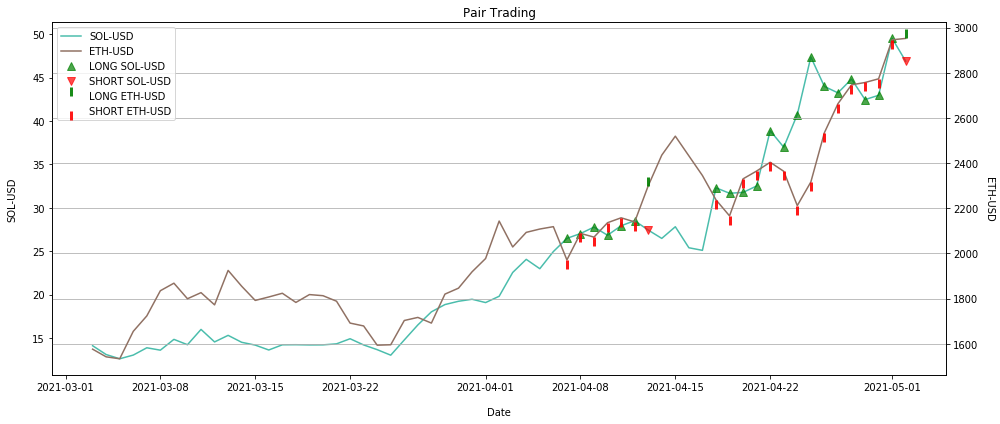

In [29]:
data_portfolio1=pair_trading1(data_portfolio1,'SOL-USD','ETH-USD',1.5)

Number of days =  59
CAGR = 502156.800%


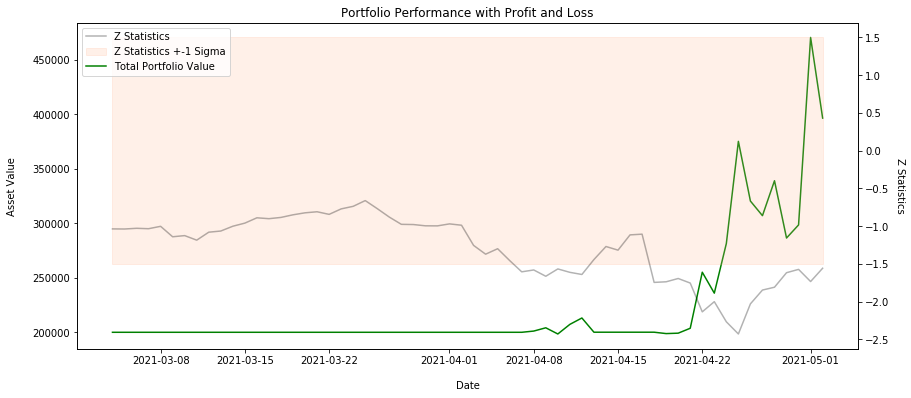

In [34]:
pnl1(data_portfolio1,'ETH-USD','SOL-USD')

In [35]:
pnl10(data_portfolio1,'ETH-USD','SOL-USD')

Number of days =  30.0
CAGR = 459660.455%


Determine GBM pair trading and performance

In [36]:
# functins to determine signals and whether to trade for every day!!!
# notice to change the data into nplog price ratio as well!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=np.log(new_portfolio.iloc[:,0])/np.log(new_portfolio.iloc[:,1])

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['movingzs']=movingzs
    data['signals2'] = -data['signals1']
    data['signals2'][-1] = -data['signals1'][-1]

    return data

In [38]:
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
data_portfolio=combine_stocks(stocks1,start,end)
data_portfolio1_1=pair_signals_gbm(data_portfolio,61,1.5)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


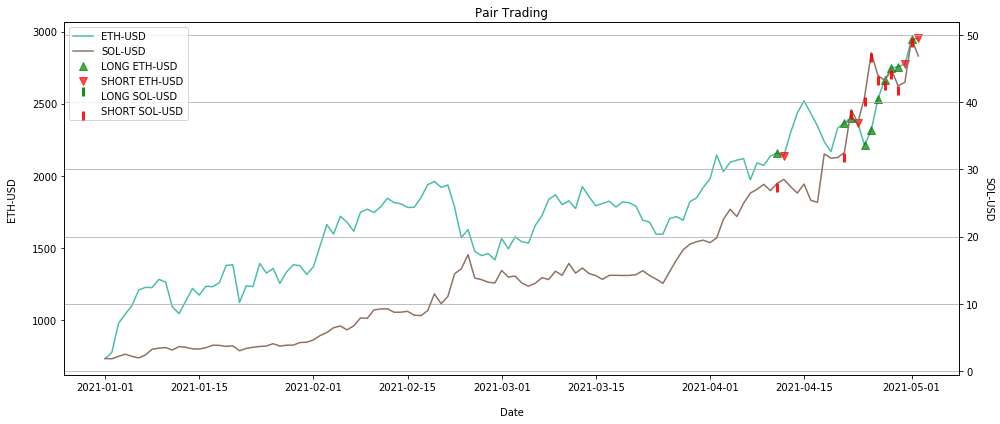

In [39]:
data_portfolio1_1=pair_trading2(data_portfolio1_1,'ETH-USD','SOL-USD',1.5)

Number of days =  60.0
CAGR = 109556.130%


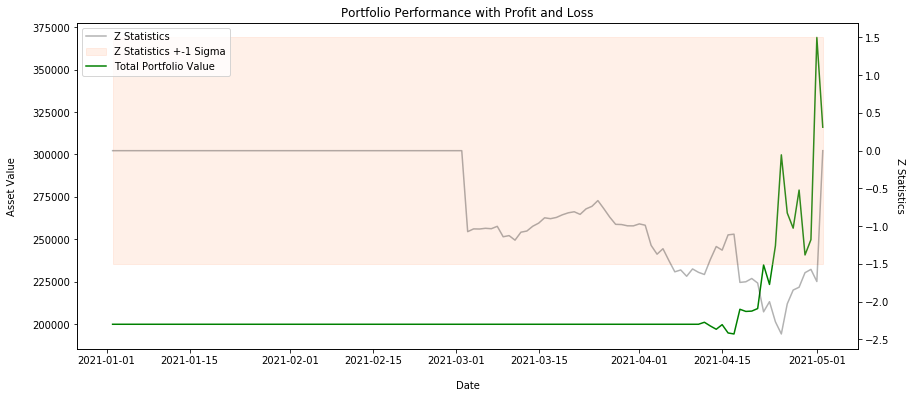

In [40]:
pnl2(data_portfolio1_1,'ETH-USD','SOL-USD')

2021.1.1-2021.6.1

In [41]:
# we plan to evaluate the 3-year data 
# As USD coins have not been put into the market until 2019
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2021,6,2)
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
portfolio1=combine_stocks(stocks1,start,end)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


In [42]:
result = ts.coint(portfolio1['ETH-USD'],portfolio1['SOL-USD'])
result[1]

0.0020279656236047044

Reject null hypothesis and it's cointegrated!

Test stationarity of the price ratio and spread

In [43]:
import numpy as np
portfolio1['log price ratio']=np.log(portfolio1['ETH-USD'])/np.log(portfolio1['SOL-USD'])
portfolio1['price ratio']=portfolio1['ETH-USD']/portfolio1['SOL-USD']
portfolio1['spread']=regr(np.log(portfolio1['SOL-USD']),np.log(portfolio1['ETH-USD']))

In [44]:
adf_t(portfolio1)

ETH-USD         SOL-USD log price ratio     price ratio  \
0  not stationary  not stationary      stationary  not stationary   

           spread  
0  not stationary

Test for pair trading with log ratio first!!!

For normal pair trading

In [107]:
len(portfolio1['ETH-USD'])

154

In [45]:
#notice: because here only log price ratio converge, so we only take log price ratio as spread
def data_prep1(time_period,data,S1,S2):
    #create a column for price ratio
    data['price ratio']=np.log(data[S1])/np.log(data[S2])
    # create columns for moving averages, standard deviations, and z_scores
    averages=[0]*time_period
    sds=[0]*time_period
    z_scores=[0]*time_period
    for i in range(time_period,len(data.iloc[:,0])):
        averages.append(np.mean(data.iloc[i-time_period:i,2]))
        sds.append(np.std(data.iloc[i-time_period:i,2]))
        z_scores.append((data.iloc[i,2]-np.mean(data.iloc[i-time_period:i,2]))/np.std(data.iloc[i-time_period:i,2]))
    data['moving_averages']=averages
    data['moving_stds']=sds
    data['moving_zs']=z_scores
    return data.iloc[time_period:,:]

In [46]:
data_portfolio1=data_prep1(77,portfolio1,'SOL-USD','ETH-USD')

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

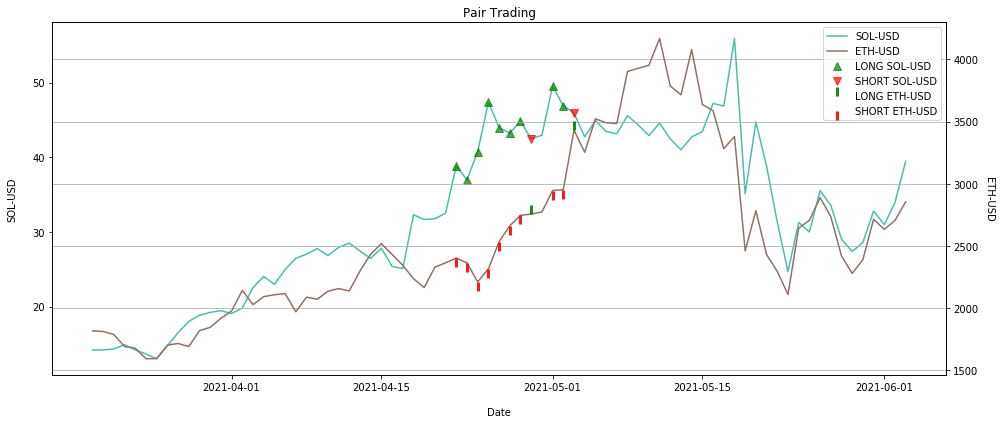

In [47]:
data_portfolio1=pair_trading1(data_portfolio1,'SOL-USD','ETH-USD',1.5)

Number of days =  75
CAGR = 2420.444%


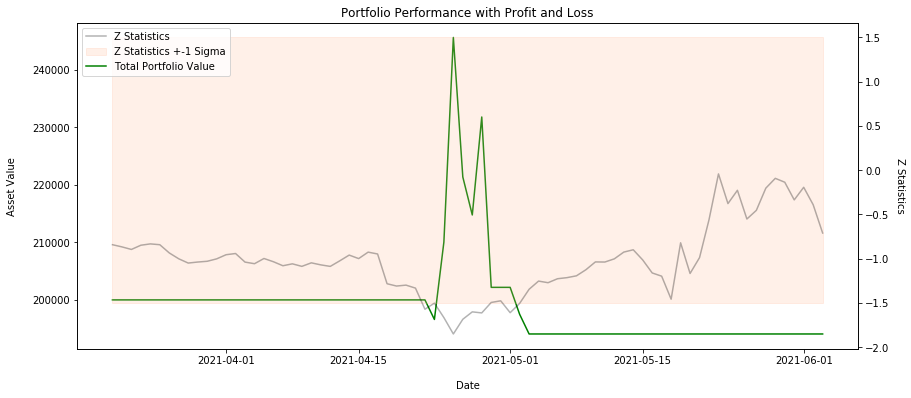

In [48]:
pnl1(data_portfolio1,'ETH-USD','SOL-USD')

For pair trading with GBM

In [49]:
# functins to determine signals and whether to trade for every day!!!
# notice to change the data into nplog price ratio as well!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=np.log(new_portfolio.iloc[:,0])/np.log(new_portfolio.iloc[:,1])

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['movingzs']=movingzs
    data['signals2'] = -data['signals1']
    data['signals2'][-1] = -data['signals1'][-1]

    return data

In [50]:
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
data_portfolio=combine_stocks(stocks1,start,end)
data_portfolio1_1=pair_signals_gbm(data_portfolio,77,1.5)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


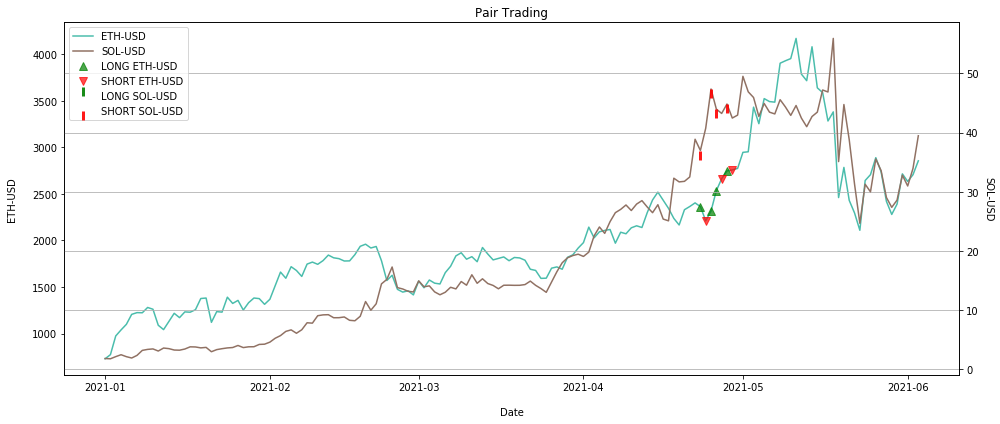

In [51]:
data_portfolio1_1=pair_trading2(data_portfolio1_1,'ETH-USD','SOL-USD',1.5)

Number of days =  76.0
CAGR = 1279.443%


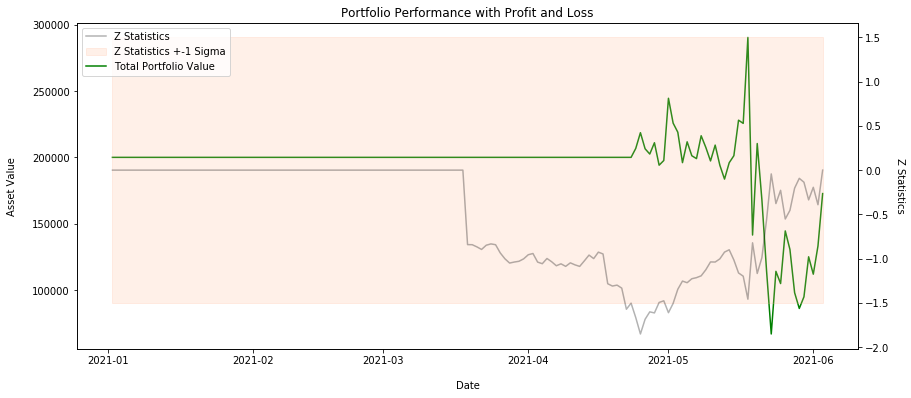

In [52]:
pnl2(data_portfolio1_1,'ETH-USD','SOL-USD')

2021.1.1-2021.7.1

In [54]:
# we plan to evaluate the 3-year data 
# As USD coins have not been put into the market until 2019
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2021,7,2)
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
portfolio1=combine_stocks(stocks1,start,end)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


In [55]:
result = ts.coint(portfolio1['ETH-USD'],portfolio1['SOL-USD'])
result[1]

0.011124998969771165

Reject null hypothesis and it's cointegrated!

Reject null hypothesis and it's cointegrated!

In [56]:
import numpy as np
portfolio1['log price ratio']=np.log(portfolio1['ETH-USD'])/np.log(portfolio1['SOL-USD'])
portfolio1['price ratio']=portfolio1['ETH-USD']/portfolio1['SOL-USD']
portfolio1['spread']=regr(np.log(portfolio1['SOL-USD']),np.log(portfolio1['ETH-USD']))

In [57]:
adf_t(portfolio1)

ETH-USD         SOL-USD log price ratio price ratio          spread
0  not stationary  not stationary      stationary  stationary  not stationary

Test for pair trading with price ratio first!!!

In [58]:
len(portfolio1['ETH-USD'])

184

For normal pair trading!

In [59]:
#notice: because here only log price ratio converge, so we only take log price ratio as spread
def data_prep1(time_period,data,S1,S2):
    #create a column for price ratio
    data['price ratio']=np.log(data[S1])/np.log(data[S2])
    # create columns for moving averages, standard deviations, and z_scores
    averages=[0]*time_period
    sds=[0]*time_period
    z_scores=[0]*time_period
    for i in range(time_period,len(data.iloc[:,0])):
        averages.append(np.mean(data.iloc[i-time_period:i,2]))
        sds.append(np.std(data.iloc[i-time_period:i,2]))
        z_scores.append((data.iloc[i,2]-np.mean(data.iloc[i-time_period:i,2]))/np.std(data.iloc[i-time_period:i,2]))
    data['moving_averages']=averages
    data['moving_stds']=sds
    data['moving_zs']=z_scores
    return data.iloc[time_period:,:]

In [60]:
data_portfolio1=data_prep1(92,portfolio1,'SOL-USD','ETH-USD')

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

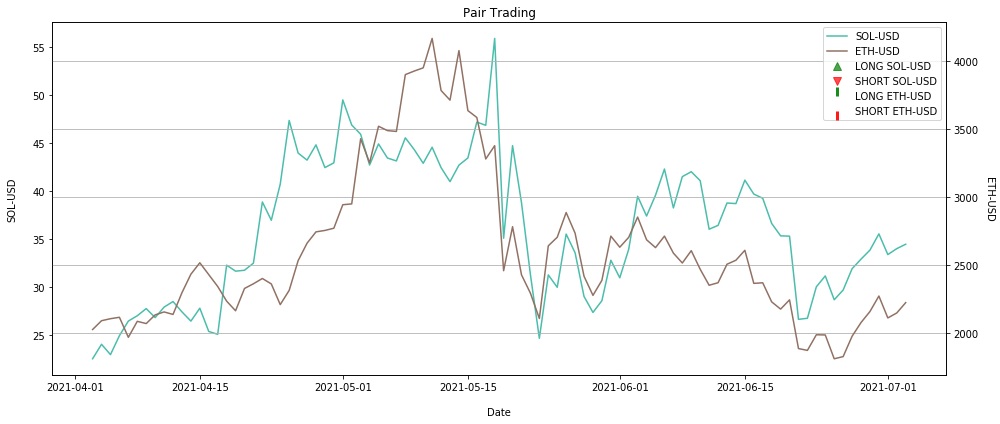

In [61]:
data_portfolio1=pair_trading1(data_portfolio1,'SOL-USD','ETH-USD',1.5)

Number of days =  90
CAGR = 1562.815%


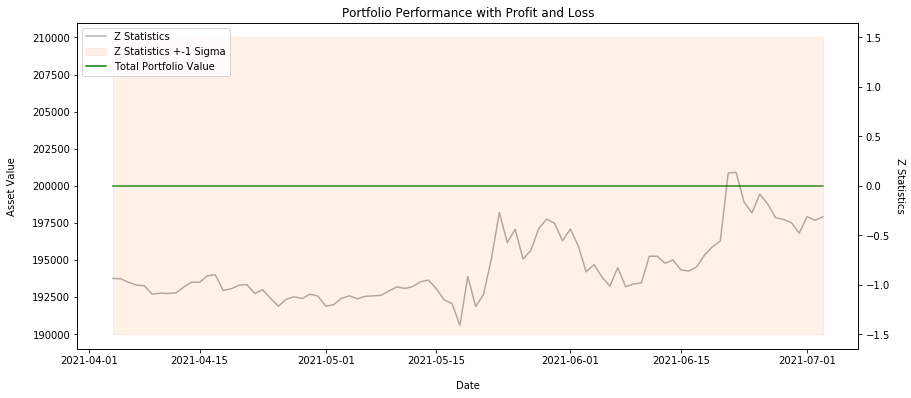

In [62]:
pnl1(data_portfolio1,'ETH-USD','SOL-USD')

For pair trading with GBM!

In [63]:
# functins to determine signals and whether to trade for every day!!!
# notice to change the data into nplog price ratio as well!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=np.log(new_portfolio.iloc[:,0])/np.log(new_portfolio.iloc[:,1])

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['movingzs']=movingzs
    data['signals2'] = -data['signals1']
    data['signals2'][-1] = -data['signals1'][-1]

    return data

In [64]:
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
data_portfolio=combine_stocks(stocks1,start,end)
data_portfolio1_1=pair_signals_gbm(data_portfolio,92,1.5)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


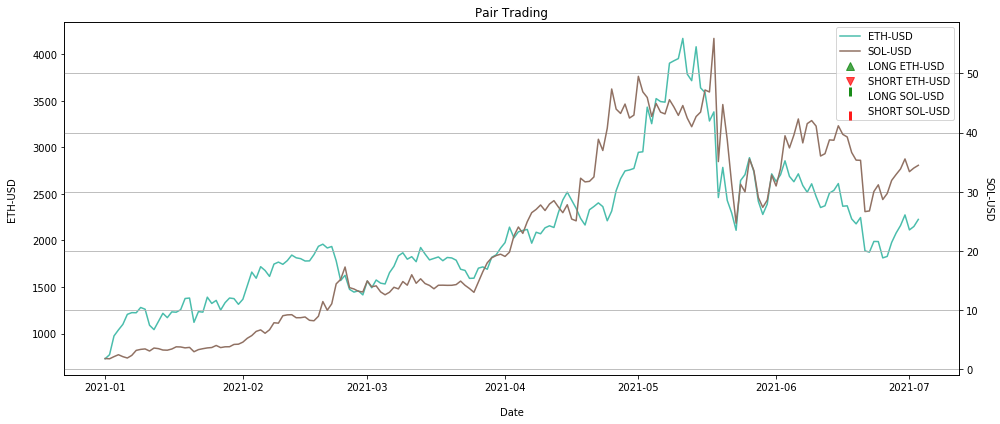

In [65]:
data_portfolio1_1=pair_trading2(data_portfolio1_1,'ETH-USD','SOL-USD',1.5)

Number of days =  91.0
CAGR = 1512.234%


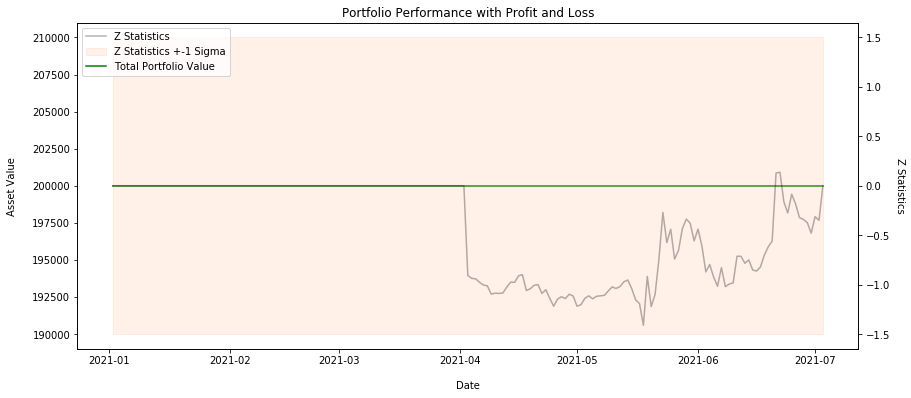

In [66]:
pnl2(data_portfolio1_1,'ETH-USD','SOL-USD')

For price ratio!

In [67]:
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
data_portfolio=combine_stocks(stocks1,start,end)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


For normal pair trading

In [68]:
data_portfolio1=data_prep(92,portfolio1,'ETH-USD','SOL-USD')

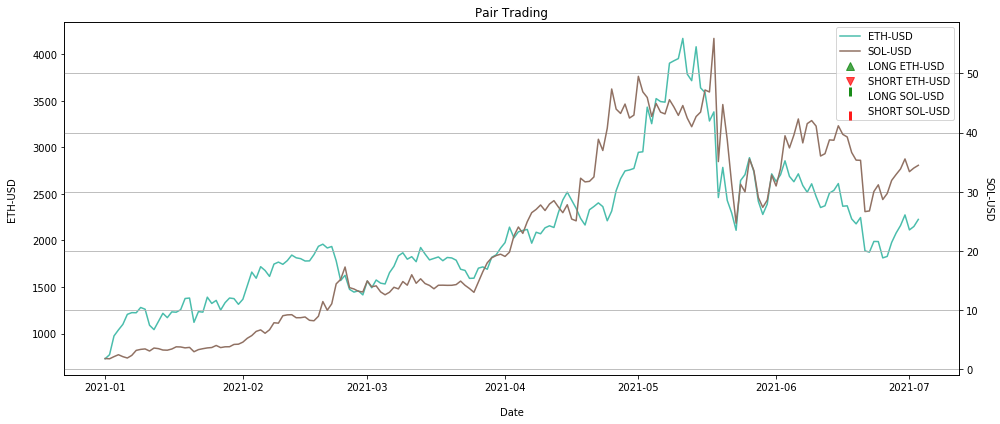

In [69]:
data_portfolio1=pair_trading1(data_portfolio1,'ETH-USD','SOL-USD',1.5)

Number of days =  182
CAGR = 301.526%


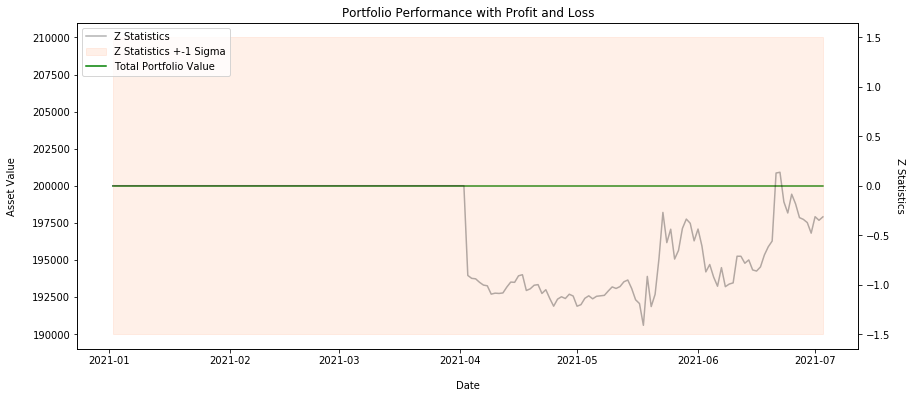

In [70]:
pnl1(data_portfolio1,'ETH-USD','SOL-USD')

pair trading with GBM

In [71]:
import numpy as np
# functins to determine signals and whether to trade for every day!!!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=new_portfolio.iloc[:,0]/new_portfolio.iloc[:,1]

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['signals2'] = -data['signals1']
    data['movingzs']=movingzs
    return data

In [72]:
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
data_portfolio=combine_stocks(stocks1,start,end)
data_portfolio1_1=pair_signals_gbm(data_portfolio,92,1.5)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


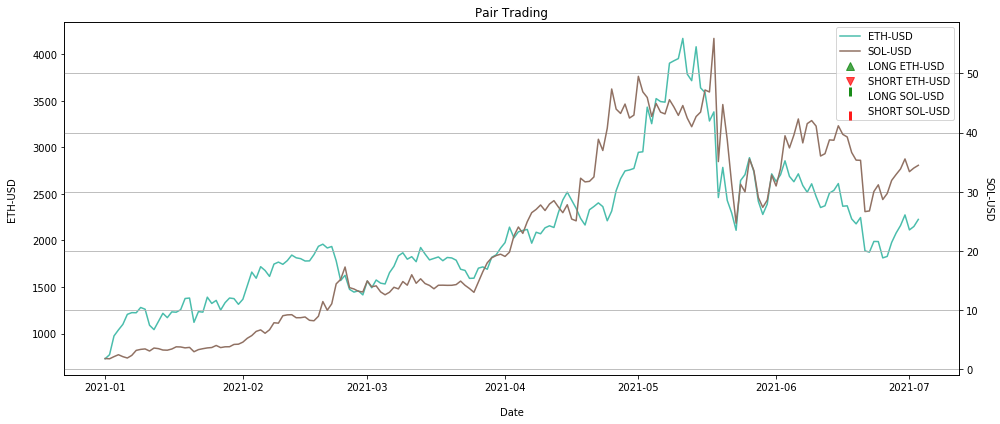

In [73]:
data_portfolio1_1=pair_trading2(data_portfolio1_1,'ETH-USD','SOL-USD',1.5)

Number of days =  91.0
CAGR = 1512.234%


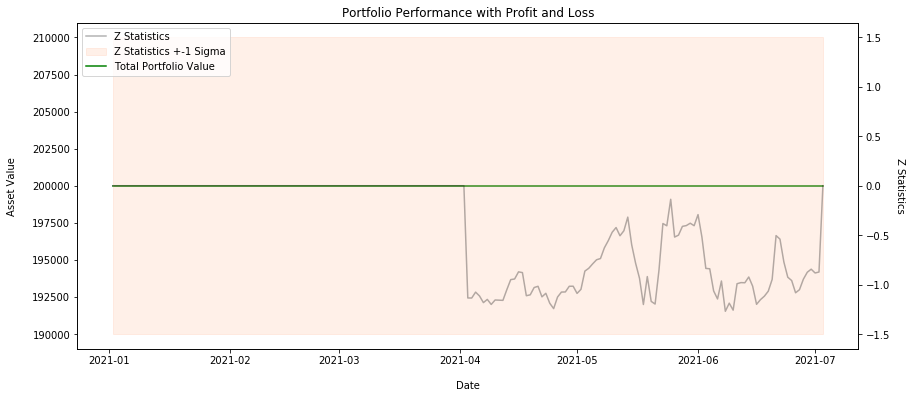

In [74]:
pnl2(data_portfolio1_1,'ETH-USD','SOL-USD')

2021.1.1-2022.1.2

In [75]:
# we plan to evaluate the 3-year data 
# As USD coins have not been put into the market until 2019
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2022,1,2)
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
portfolio1=combine_stocks(stocks1,start,end)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


In [76]:
result = ts.coint(portfolio1['ETH-USD'],portfolio1['SOL-USD'])
result[1]

0.04742443162360974

Reject null hypothesis and it's cointegrated!

Test stationarity of the price ratio and spread

In [77]:
import numpy as np
portfolio1['log price ratio']=np.log(portfolio1['ETH-USD'])/np.log(portfolio1['SOL-USD'])
portfolio1['price ratio']=portfolio1['ETH-USD']/portfolio1['SOL-USD']
portfolio1['spread']=regr(np.log(portfolio1['SOL-USD']),np.log(portfolio1['ETH-USD']))

In [78]:
adf_t(portfolio1)

ETH-USD         SOL-USD log price ratio price ratio          spread
0  not stationary  not stationary      stationary  stationary  not stationary

Test for pair trading with log price ratio first!!!

For normal pair trading!

In [79]:
len(portfolio1['ETH-USD'])

368

In [80]:
#notice: because here only log price ratio converge, so we only take log price ratio as spread
def data_prep1(time_period,data,S1,S2):
    #create a column for price ratio
    data['price ratio']=np.log(data[S1])/np.log(data[S2])
    # create columns for moving averages, standard deviations, and z_scores
    averages=[0]*time_period
    sds=[0]*time_period
    z_scores=[0]*time_period
    for i in range(time_period,len(data.iloc[:,0])):
        averages.append(np.mean(data.iloc[i-time_period:i,2]))
        sds.append(np.std(data.iloc[i-time_period:i,2]))
        z_scores.append((data.iloc[i,2]-np.mean(data.iloc[i-time_period:i,2]))/np.std(data.iloc[i-time_period:i,2]))
    data['moving_averages']=averages
    data['moving_stds']=sds
    data['moving_zs']=z_scores
    return data.iloc[time_period:,:]

In [81]:
data_portfolio1=data_prep1(184,portfolio1,'SOL-USD','ETH-USD')

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

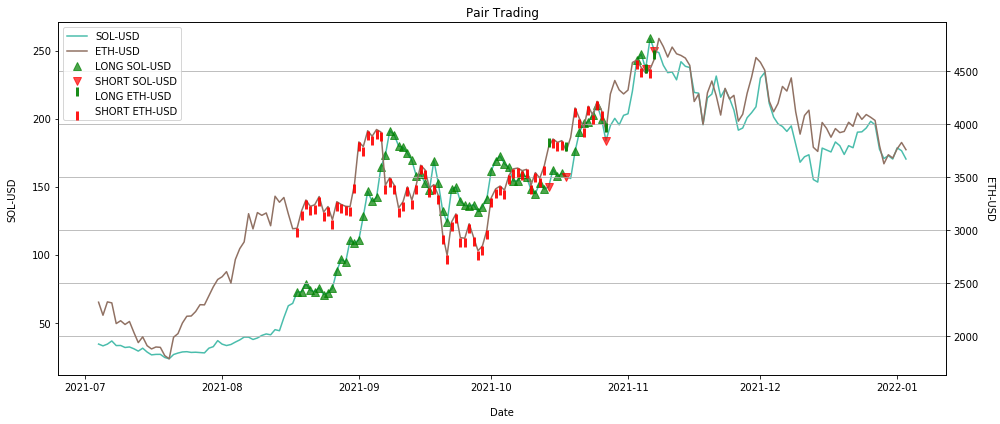

In [82]:
data_portfolio1=pair_trading1(data_portfolio1,'SOL-USD','ETH-USD',1.5)

Number of days =  182
CAGR = 2005.355%


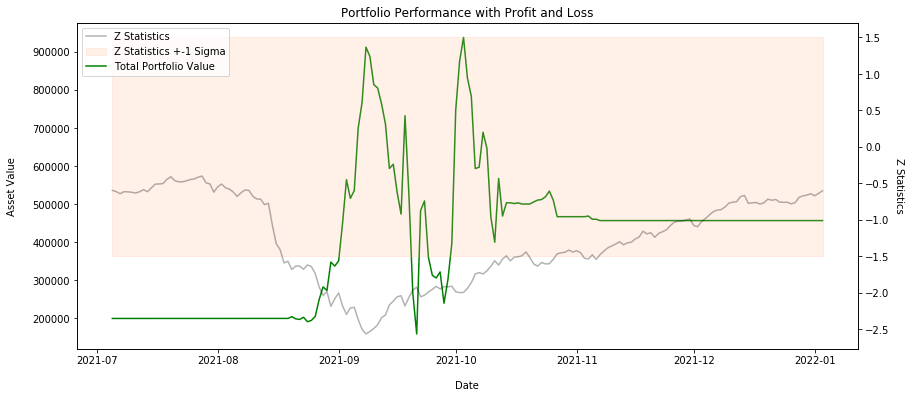

In [83]:
pnl1(data_portfolio1,'ETH-USD','SOL-USD')

For pair trading with GBM!

In [84]:
# functins to determine signals and whether to trade for every day!!!
# notice to change the data into nplog price ratio as well!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=np.log(new_portfolio.iloc[:,0])/np.log(new_portfolio.iloc[:,1])

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['movingzs']=movingzs
    data['signals2'] = -data['signals1']
    data['signals2'][-1] = -data['signals1'][-1]

    return data

In [85]:
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
data_portfolio=combine_stocks(stocks1,start,end)
data_portfolio1_1=pair_signals_gbm(data_portfolio,184,1.5)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


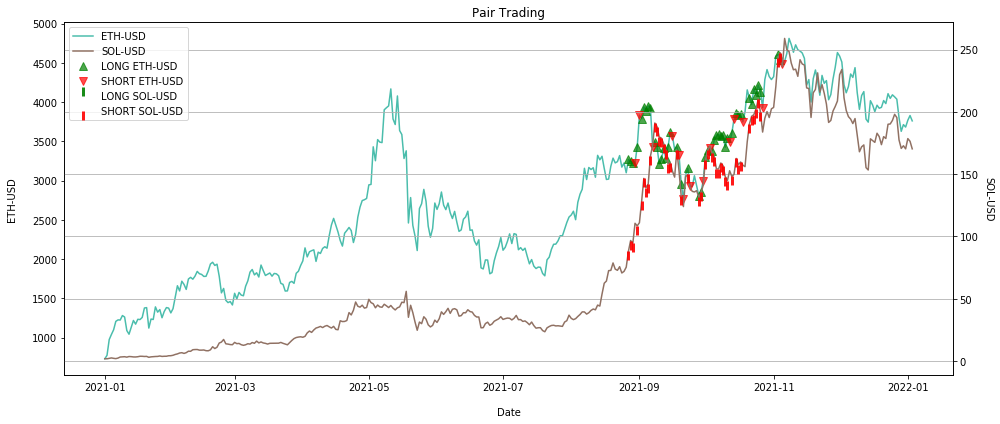

In [86]:
data_portfolio1_1=pair_trading2(data_portfolio1_1,'ETH-USD','SOL-USD',1.5)

Number of days =  183.0
CAGR = 1078.916%


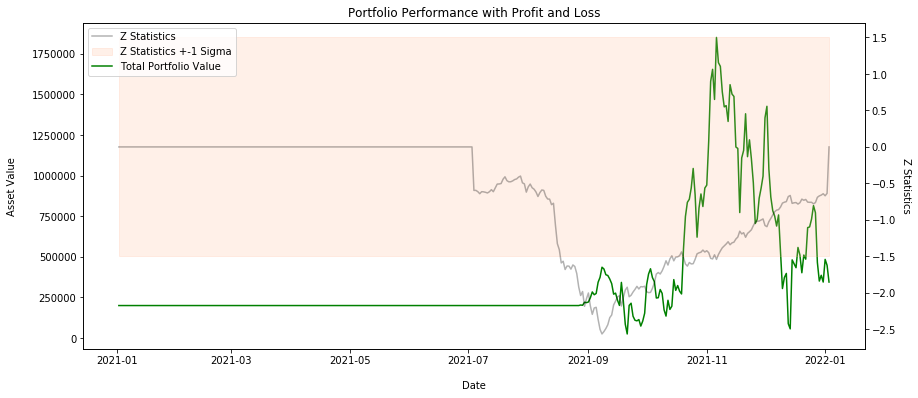

In [87]:
pnl2(data_portfolio1_1,'ETH-USD','SOL-USD')

For price ratio

Normal pair trading

In [88]:
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
data_portfolio=combine_stocks(stocks1,start,end)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


In [89]:
data_portfolio1=data_prep(184,portfolio1,'ETH-USD','SOL-USD')

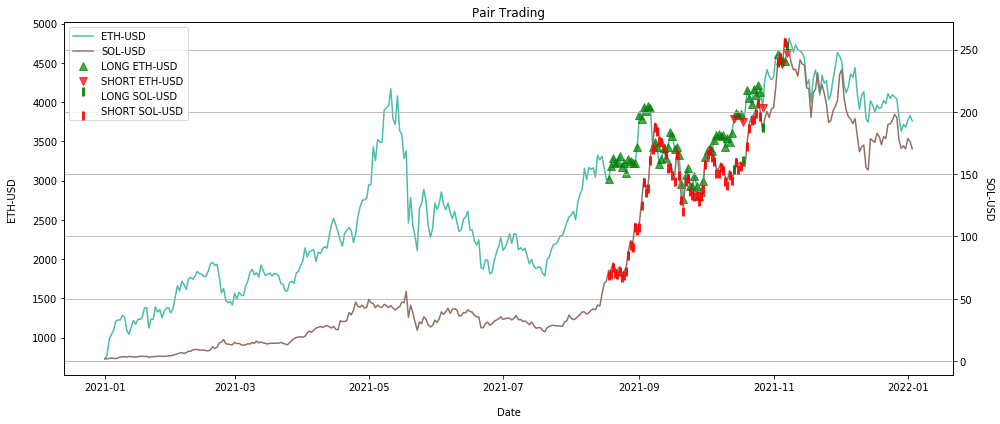

In [90]:
data_portfolio1=pair_trading1(data_portfolio1,'ETH-USD','SOL-USD',1.5)

Number of days =  366
CAGR = 355.037%


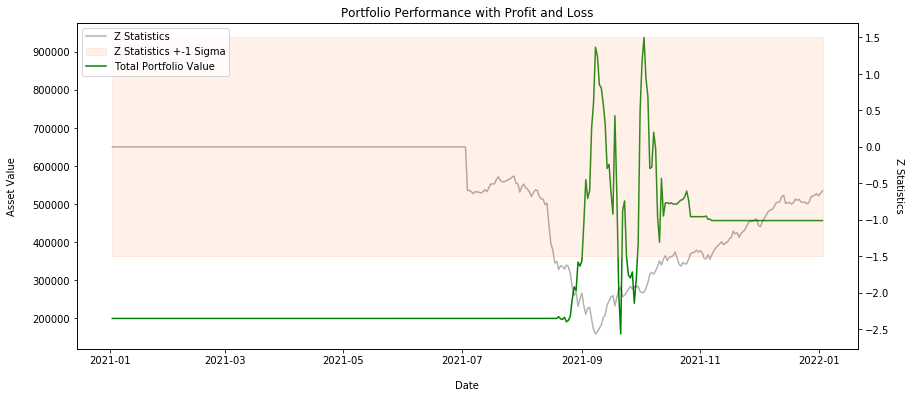

In [91]:
pnl1(data_portfolio1,'ETH-USD','SOL-USD')

Pair trading with GBM

In [92]:
import numpy as np
# functins to determine signals and whether to trade for every day!!!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=new_portfolio.iloc[:,0]/new_portfolio.iloc[:,1]

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['signals2'] = -data['signals1']
    data['movingzs']=movingzs
    return data

In [93]:
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
data_portfolio=combine_stocks(stocks1,start,end)
data_portfolio1_1=pair_signals_gbm(data_portfolio,184,1.5)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [96]:
data_portfolio1_1=pair_trading2(data_portfolio1_1,'ETH-USD','SOL-USD',1.5)

In [97]:
pnl2(data_portfolio1_1,'ETH-USD','SOL-USD')

Number of days =  183.0
CAGR = 2815.237%


2021.1.1-2022.3.1

In [98]:
# we plan to evaluate the 3-year data 
# As USD coins have not been put into the market until 2019
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2022,3,1)
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
portfolio1=combine_stocks(stocks1,start,end)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


In [99]:
result = ts.coint(portfolio1['ETH-USD'],portfolio1['SOL-USD'])
result[1]

0.026915826277764263

Reject null hypothesis and it's cointegrated!

Test stationarity of the price ratio and spread

In [100]:
import numpy as np
portfolio1['log price ratio']=np.log(portfolio1['ETH-USD'])/np.log(portfolio1['SOL-USD'])
portfolio1['price ratio']=portfolio1['ETH-USD']/portfolio1['SOL-USD']
portfolio1['spread']=regr(np.log(portfolio1['SOL-USD']),np.log(portfolio1['ETH-USD']))

In [101]:
adf_t(portfolio1)

ETH-USD         SOL-USD log price ratio price ratio          spread
0  not stationary  not stationary      stationary  stationary  not stationary

In [102]:
len(portfolio1['ETH-USD'])

426

Use log price ratio to do pair trading!!!

Normal pair trading!!!

In [103]:
#notice: because here only log price ratio converge, so we only take log price ratio as spread
def data_prep1(time_period,data,S1,S2):
    #create a column for price ratio
    data['price ratio']=np.log(data[S1])/np.log(data[S2])
    # create columns for moving averages, standard deviations, and z_scores
    averages=[0]*time_period
    sds=[0]*time_period
    z_scores=[0]*time_period
    for i in range(time_period,len(data.iloc[:,0])):
        averages.append(np.mean(data.iloc[i-time_period:i,2]))
        sds.append(np.std(data.iloc[i-time_period:i,2]))
        z_scores.append((data.iloc[i,2]-np.mean(data.iloc[i-time_period:i,2]))/np.std(data.iloc[i-time_period:i,2]))
    data['moving_averages']=averages
    data['moving_stds']=sds
    data['moving_zs']=z_scores
    return data.iloc[time_period:,:]

In [104]:
data_portfolio1=data_prep1(213,portfolio1,'SOL-USD','ETH-USD')

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

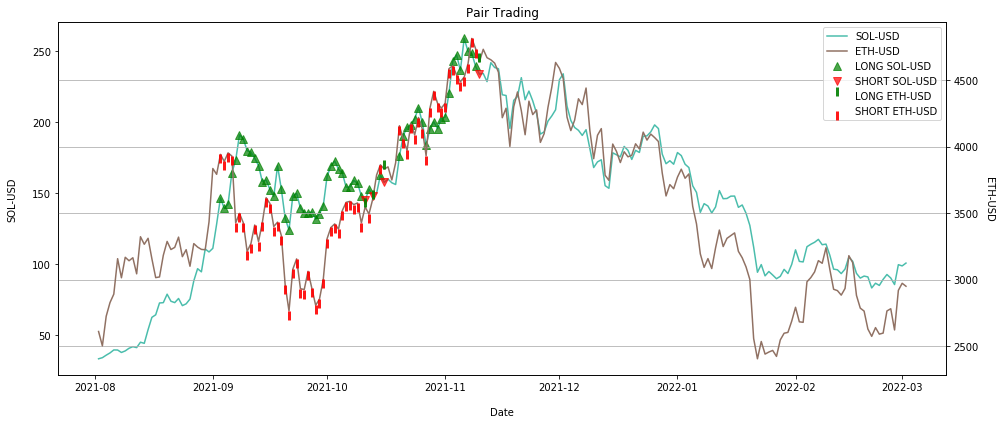

In [105]:
data_portfolio1=pair_trading1(data_portfolio1,'SOL-USD','ETH-USD',1.5)

In [106]:
pnl1(data_portfolio1,'ETH-USD','SOL-USD')

Number of days =  211
CAGR = 238.191%


Pair trading with GBM

In [107]:
# functins to determine signals and whether to trade for every day!!!
# notice to change the data into nplog price ratio as well!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=np.log(new_portfolio.iloc[:,0])/np.log(new_portfolio.iloc[:,1])

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['movingzs']=movingzs
    data['signals2'] = -data['signals1']
    data['signals2'][-1] = -data['signals1'][-1]

    return data

In [108]:
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
data_portfolio=combine_stocks(stocks1,start,end)
data_portfolio1_1=pair_signals_gbm(data_portfolio,213,1.5)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [111]:
data_portfolio1_1=pair_trading2(data_portfolio1_1,'ETH-USD','SOL-USD',1.5)

Number of days =  212.0
CAGR = nan%


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars


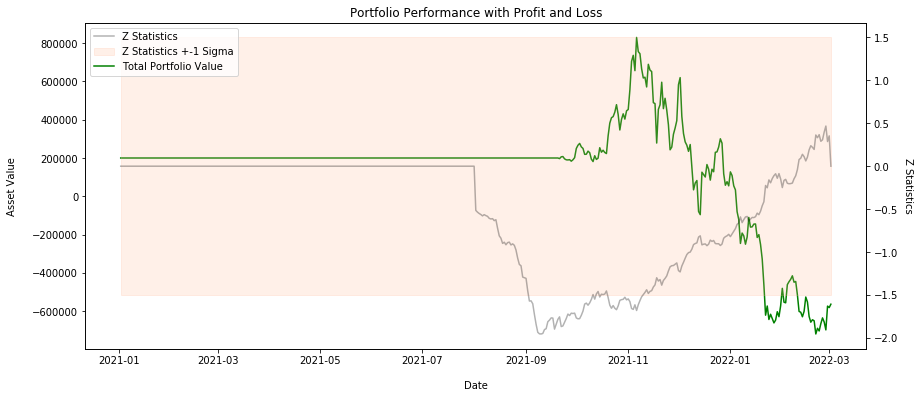

In [112]:
pnl2(data_portfolio1_1,'ETH-USD','SOL-USD')

For price ratio!!!

Normal pair trading

In [113]:
stocks1 = ["ETH-USD","SOL-USD"]
portfolio1=combine_stocks(stocks1,start,end)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


In [114]:
data_portfolio1=data_prep(213,portfolio1,'ETH-USD','SOL-USD')

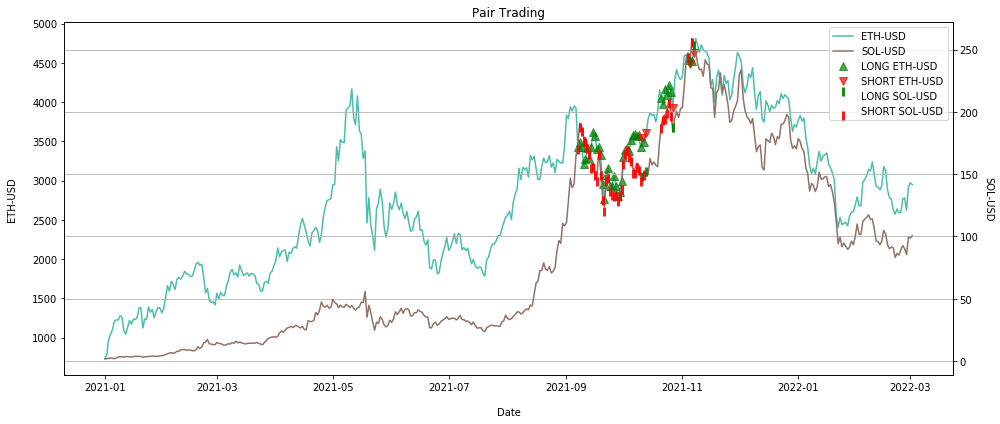

In [115]:
data_portfolio1=pair_trading1(data_portfolio1,'ETH-USD','SOL-USD',1.5)

Number of days =  424
CAGR = -91.595%


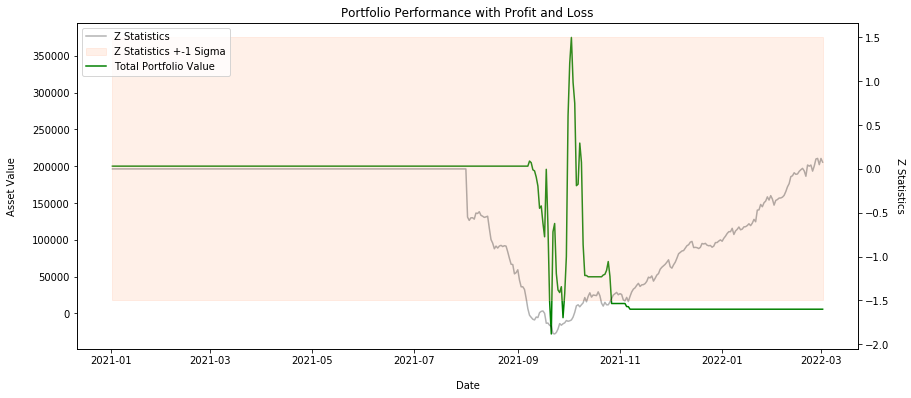

In [116]:
pnl1(data_portfolio1,'ETH-USD','SOL-USD')

Pair Trading with GBM

In [117]:
import numpy as np
# functins to determine signals and whether to trade for every day!!!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=new_portfolio.iloc[:,0]/new_portfolio.iloc[:,1]

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['signals2'] = -data['signals1']
    data['movingzs']=movingzs
    return data

In [118]:
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
data_portfolio=combine_stocks(stocks1,start,end)
data_portfolio1_1=pair_signals_gbm(data_portfolio,213,1.5)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


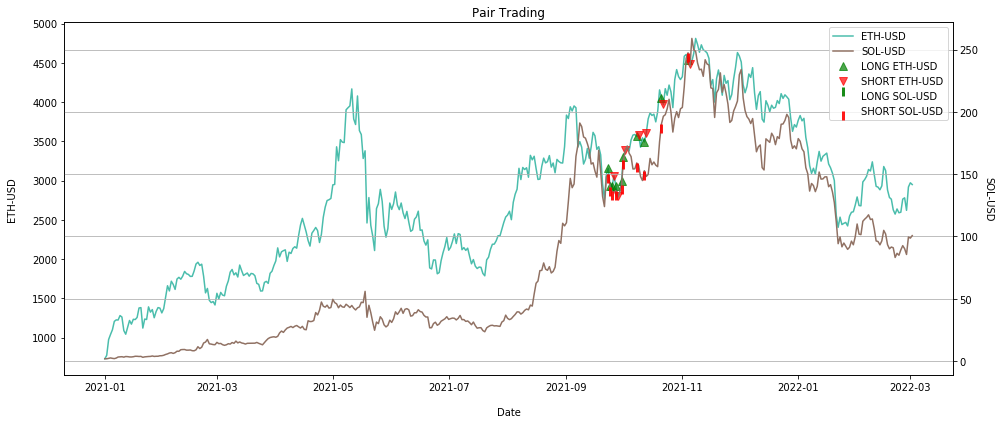

In [119]:
data_portfolio1_1=pair_trading2(data_portfolio1_1,'ETH-USD','SOL-USD',1.5)

Number of days =  212.0
CAGR = nan%


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars


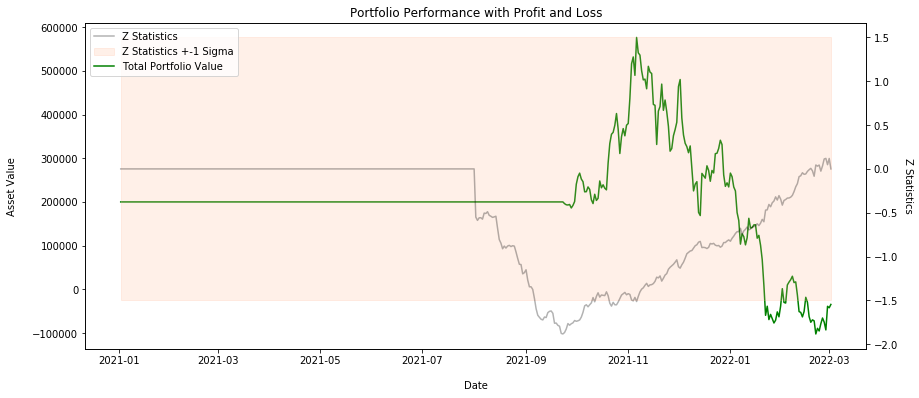

In [120]:
portfolio=pnl2(data_portfolio1_1,'ETH-USD','SOL-USD')

In [122]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = ((portfolio.index[-1] - portfolio.index[0]).days)/2
print('Number of days = ', delta)
YEAR_DAYS = 365
final_portfolio

TypeError: 'NoneType' object is not subscriptable

In [189]:
((-2.7425946012878417)**1.721698113207547)-1

(2.644147083537038-4.357476144131115j)

2021.1.1-2022.4.1

In [123]:
# we plan to evaluate the 3-year data 
# As USD coins have not been put into the market until 2019
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2022,4,2)
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
portfolio1=combine_stocks(stocks1,start,end)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


In [124]:
result = ts.coint(portfolio1['ETH-USD'],portfolio1['SOL-USD'])
result[1]

0.018639270120747727

In [125]:
import numpy as np
portfolio1['log price ratio']=np.log(portfolio1['ETH-USD'])/np.log(portfolio1['SOL-USD'])
portfolio1['price ratio']=portfolio1['ETH-USD']/portfolio1['SOL-USD']
portfolio1['spread']=regr(np.log(portfolio1['SOL-USD']),np.log(portfolio1['ETH-USD']))

In [126]:
adf_t(portfolio1)

ETH-USD         SOL-USD log price ratio price ratio      spread
0  not stationary  not stationary      stationary  stationary  stationary

In [127]:
len(portfolio1['ETH-USD'])

458

For log price ratio

Normal

In [128]:
#notice: because here only log price ratio converge, so we only take log price ratio as spread
def data_prep1(time_period,data,S1,S2):
    #create a column for price ratio
    data['price ratio']=np.log(data[S1])/np.log(data[S2])
    # create columns for moving averages, standard deviations, and z_scores
    averages=[0]*time_period
    sds=[0]*time_period
    z_scores=[0]*time_period
    for i in range(time_period,len(data.iloc[:,0])):
        averages.append(np.mean(data.iloc[i-time_period:i,2]))
        sds.append(np.std(data.iloc[i-time_period:i,2]))
        z_scores.append((data.iloc[i,2]-np.mean(data.iloc[i-time_period:i,2]))/np.std(data.iloc[i-time_period:i,2]))
    data['moving_averages']=averages
    data['moving_stds']=sds
    data['moving_zs']=z_scores
    return data.iloc[time_period:,:]

In [129]:
data_portfolio1=data_prep1(229,portfolio1,'SOL-USD','ETH-USD')

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

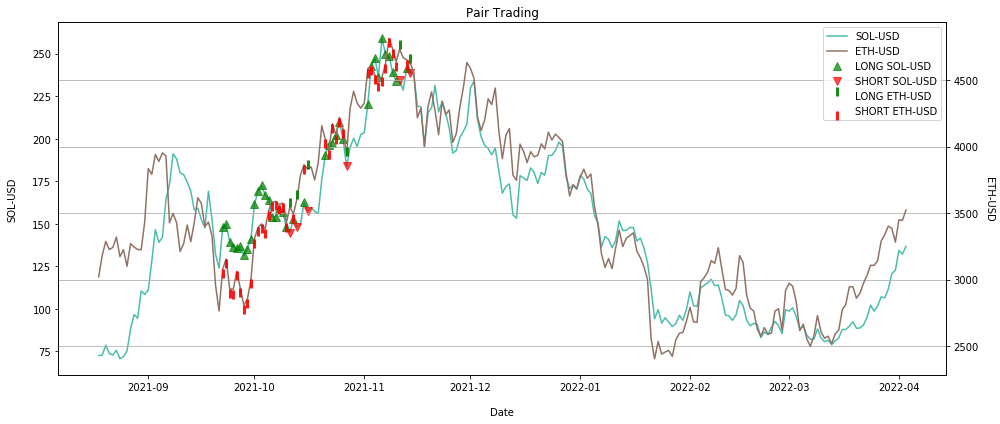

In [130]:
data_portfolio1=pair_trading1(data_portfolio1,'SOL-USD','ETH-USD',1.5)

Number of days =  227
CAGR = -14.962%


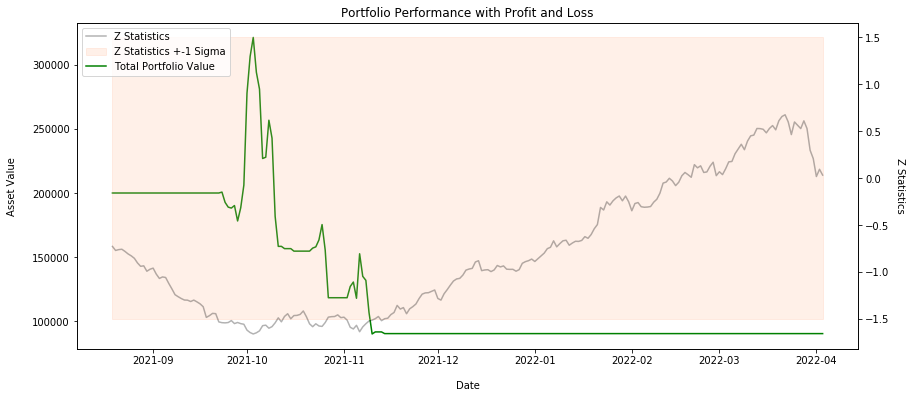

In [131]:
pnl1(data_portfolio1,'ETH-USD','SOL-USD')

Pair trading with GBM

In [132]:
# functins to determine signals and whether to trade for every day!!!
# notice to change the data into nplog price ratio as well!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=np.log(new_portfolio.iloc[:,0])/np.log(new_portfolio.iloc[:,1])

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['movingzs']=movingzs
    data['signals2'] = -data['signals1']
    data['signals2'][-1] = -data['signals1'][-1]

    return data

In [133]:
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
data_portfolio=combine_stocks(stocks1,start,end)
data_portfolio1_1=pair_signals_gbm(data_portfolio,229,1.5)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


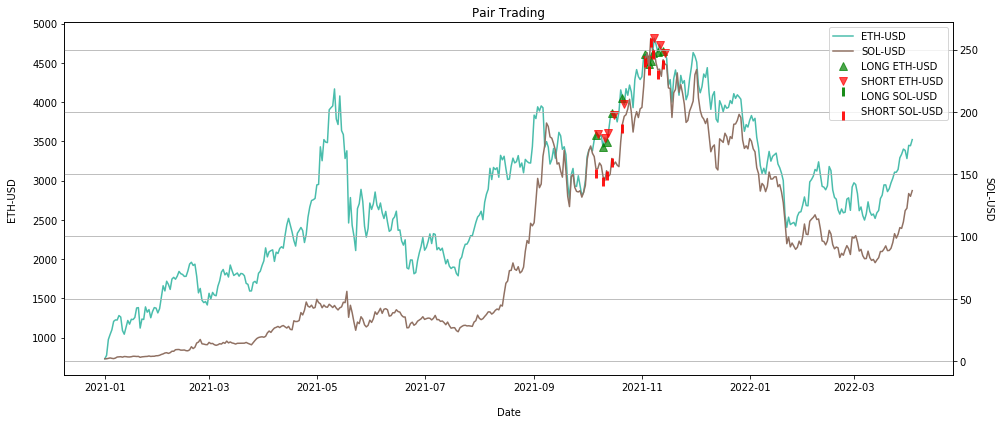

In [137]:
data_portfolio1_1=pair_trading2(data_portfolio1_1,'ETH-USD','SOL-USD',1.5)

(-0.7703806739377587-0.7001247641418971j)
Number of days =  228.0
CAGR = nan%


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars


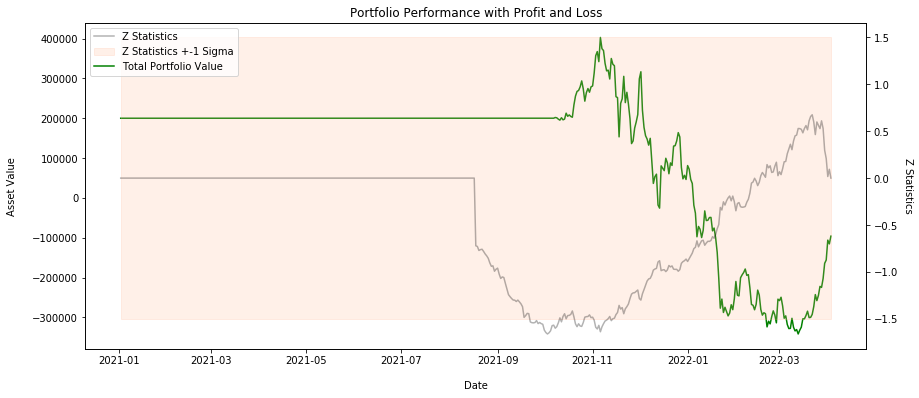

In [141]:
print(((-0.8263143698120117) ** 1.6008771929824561) -1)
portfolio=pnl2(data_portfolio1_1,'ETH-USD','SOL-USD')

In [211]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = ((portfolio.index[-1] - portfolio.index[0]).days)/2
print('Number of days = ', delta)
YEAR_DAYS = 365

Number of days =  228.0


In [212]:
YEAR_DAYS/delta

1.6008771929824561

In [214]:
final_portfolio/100000

-0.8263143698120117

In [140]:
((-0.8263143698120117) ** 1.6008771929824561) -1

(-0.7703806739377587-0.7001247641418971j)

For price ratio

Normal pair trading

In [142]:
stocks1 = ["ETH-USD","SOL-USD"]
portfolio1=combine_stocks(stocks1,start,end)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


In [143]:
data_portfolio1=data_prep(229,portfolio1,'ETH-USD','SOL-USD')

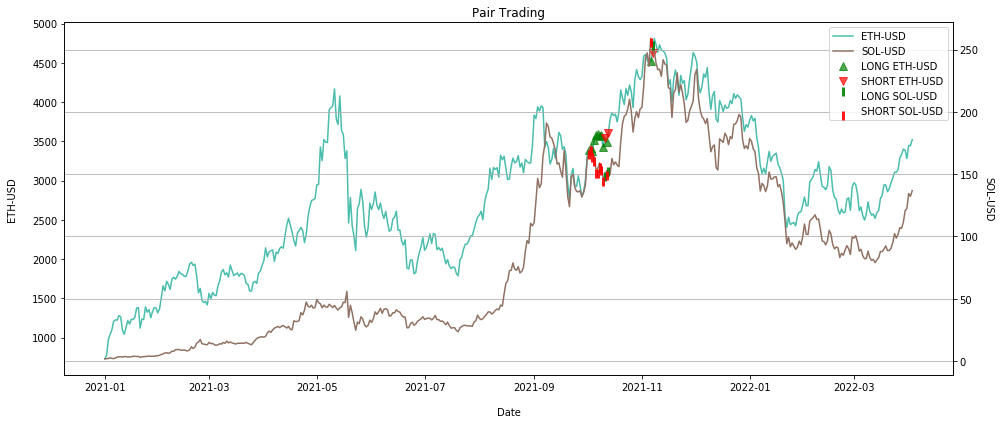

In [144]:
data_portfolio1=pair_trading1(data_portfolio1,'ETH-USD','SOL-USD',1.5)

Number of days =  456
CAGR = 31.124%


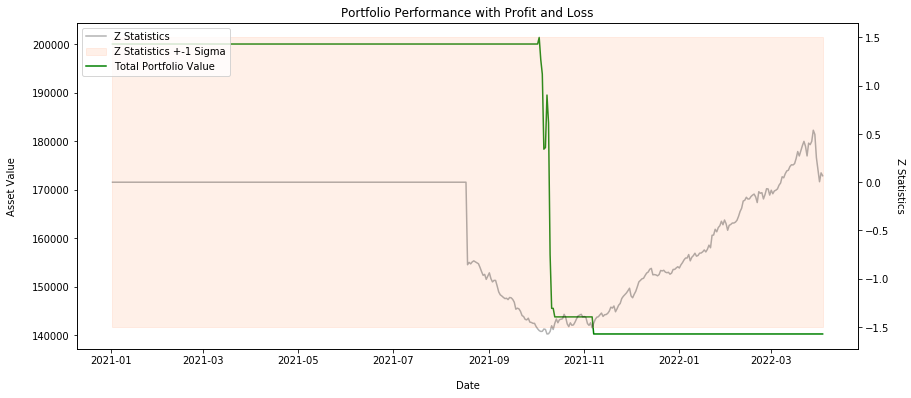

In [145]:
pnl1(data_portfolio1,'ETH-USD','SOL-USD')

For pair trading with GBM

In [146]:
import numpy as np
# functins to determine signals and whether to trade for every day!!!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=new_portfolio.iloc[:,0]/new_portfolio.iloc[:,1]

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['signals2'] = -data['signals1']
    data['movingzs']=movingzs
    return data

In [147]:
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
data_portfolio=combine_stocks(stocks1,start,end)
data_portfolio1_1=pair_signals_gbm(data_portfolio,229,1.5)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


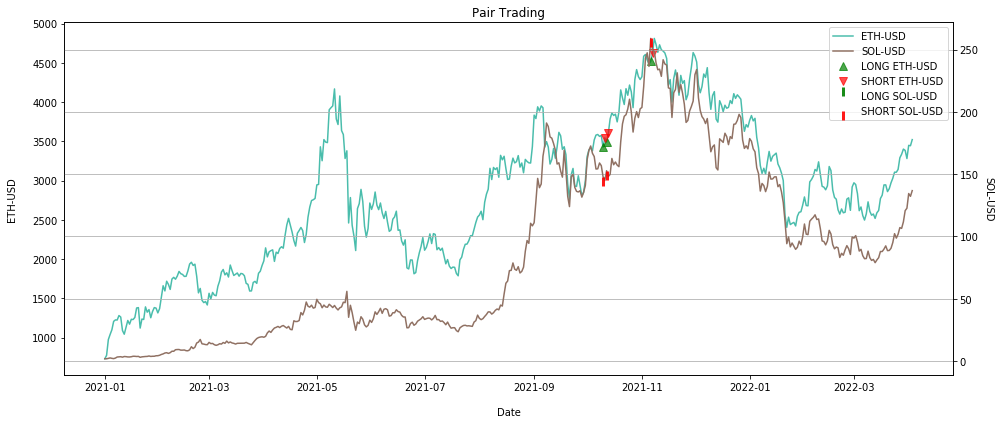

In [148]:
data_portfolio1_1=pair_trading2(data_portfolio1_1,'ETH-USD','SOL-USD',1.5)

Number of days =  228.0
CAGR = 75.966%


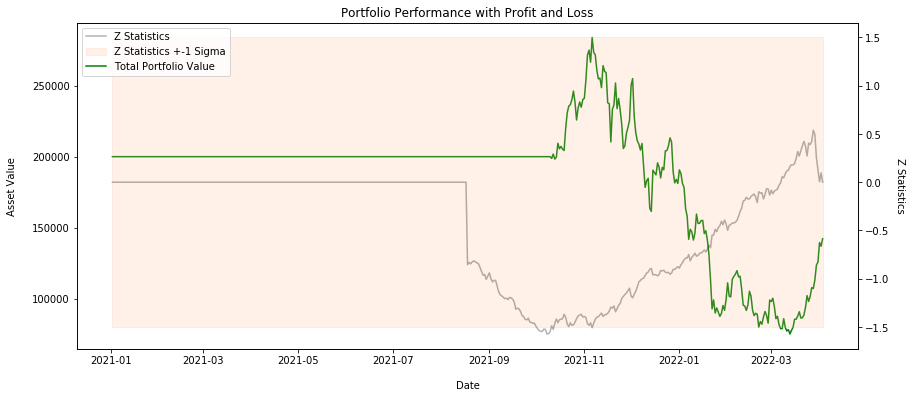

In [149]:
pnl2(data_portfolio1_1,'ETH-USD','SOL-USD')

2021.1.1-2022.6.1

In [150]:
# we plan to evaluate the 3-year data 
# As USD coins have not been put into the market until 2019
start = datetime.datetime(2021,1,1)
end = datetime.datetime(2022,6,1)
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
portfolio1=combine_stocks(stocks1,start,end)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


In [151]:
result = ts.coint(portfolio1['ETH-USD'],portfolio1['SOL-USD'])
result[1]

0.01577901281979772

Reject null hypothesis and it's cointegrated!

Test stationarity of the price ratio and spread

In [152]:
import numpy as np
portfolio1['log price ratio']=np.log(portfolio1['ETH-USD'])/np.log(portfolio1['SOL-USD'])
portfolio1['price ratio']=portfolio1['ETH-USD']/portfolio1['SOL-USD']
portfolio1['spread']=regr(np.log(portfolio1['SOL-USD']),np.log(portfolio1['ETH-USD']))

In [153]:
adf_t(portfolio1)

ETH-USD         SOL-USD log price ratio price ratio          spread
0  not stationary  not stationary      stationary  stationary  not stationary

In [154]:
len(portfolio1['ETH-USD'])

518

Use log price ratio to do pair trading!!!

Normal pair trading!!!

In [155]:
#notice: because here only log price ratio converge, so we only take log price ratio as spread
def data_prep1(time_period,data,S1,S2):
    #create a column for price ratio
    data['price ratio']=np.log(data[S1])/np.log(data[S2])
    # create columns for moving averages, standard deviations, and z_scores
    averages=[0]*time_period
    sds=[0]*time_period
    z_scores=[0]*time_period
    for i in range(time_period,len(data.iloc[:,0])):
        averages.append(np.mean(data.iloc[i-time_period:i,2]))
        sds.append(np.std(data.iloc[i-time_period:i,2]))
        z_scores.append((data.iloc[i,2]-np.mean(data.iloc[i-time_period:i,2]))/np.std(data.iloc[i-time_period:i,2]))
    data['moving_averages']=averages
    data['moving_stds']=sds
    data['moving_zs']=z_scores
    return data.iloc[time_period:,:]

In [156]:
data_portfolio1=data_prep1(259,portfolio1,'SOL-USD','ETH-USD')

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

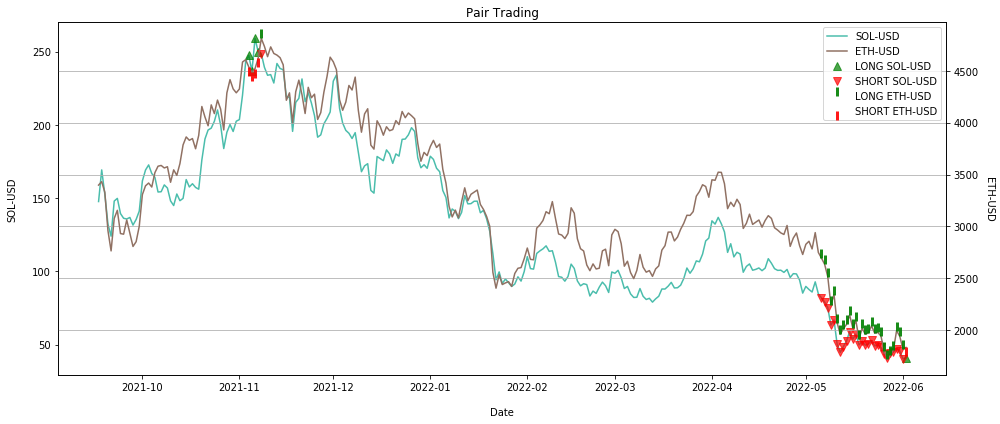

In [157]:
data_portfolio1=pair_trading1(data_portfolio1,'SOL-USD','ETH-USD',1.5)

Number of days =  257
CAGR = 445.112%


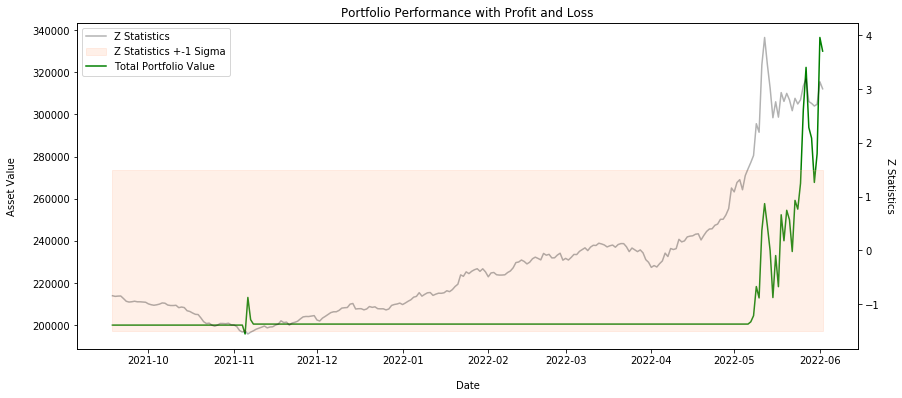

In [158]:
pnl1(data_portfolio1,'ETH-USD','SOL-USD')

Pair trading with GBM

In [159]:
# functins to determine signals and whether to trade for every day!!!
# notice to change the data into nplog price ratio as well!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=np.log(new_portfolio.iloc[:,0])/np.log(new_portfolio.iloc[:,1])

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['movingzs']=movingzs
    data['signals2'] = -data['signals1']
    data['signals2'][-1] = -data['signals1'][-1]

    return data

In [160]:
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
data_portfolio=combine_stocks(stocks1,start,end)
data_portfolio1_1=pair_signals_gbm(data_portfolio,259,1.5)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

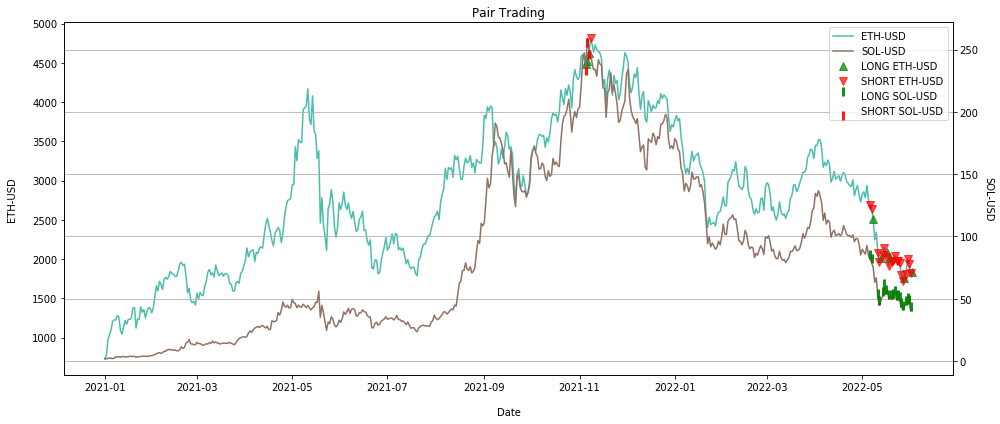

In [161]:
data_portfolio1_1=pair_trading2(data_portfolio1_1,'ETH-USD','SOL-USD',1.5)

Number of days =  258.0
CAGR = -70.264%


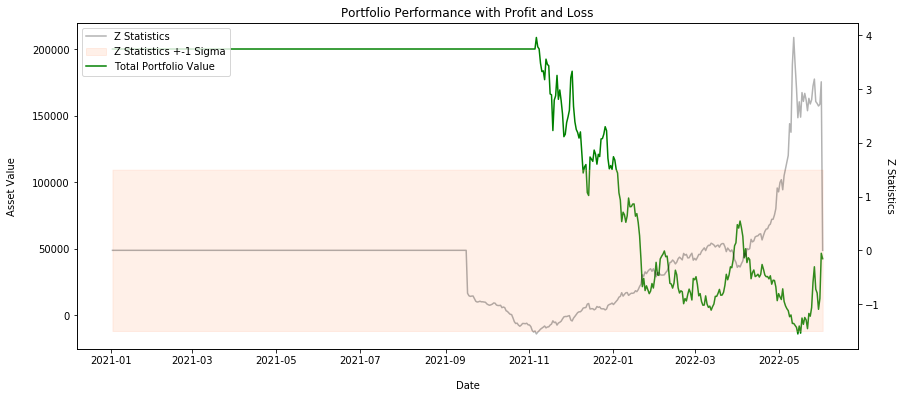

In [162]:
pnl2(data_portfolio1_1,'ETH-USD','SOL-USD')

For price ratio!!!

In [163]:
stocks1 = ["ETH-USD","SOL-USD"]
portfolio1=combine_stocks(stocks1,start,end)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


For normal pair trading!

In [164]:
data_portfolio1=data_prep(259,portfolio1,'ETH-USD','SOL-USD')

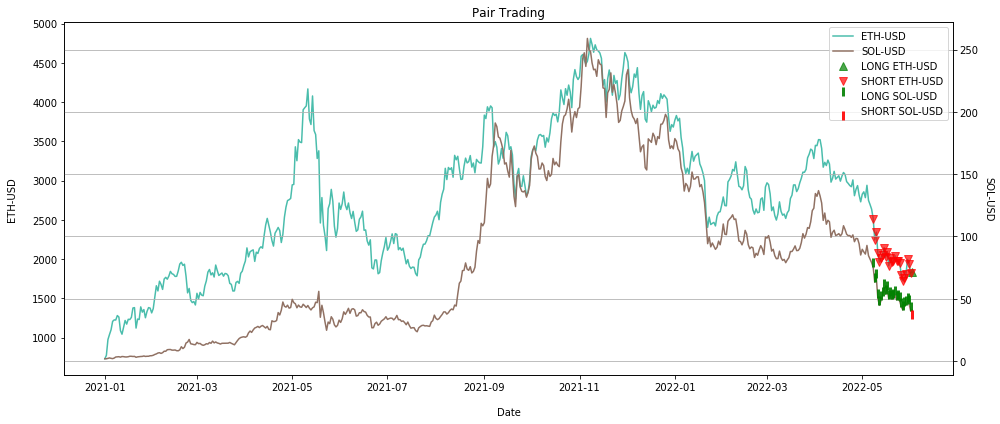

In [165]:
data_portfolio1=pair_trading1(data_portfolio1,'ETH-USD','SOL-USD',1.5)

Number of days =  516
CAGR = 117.046%


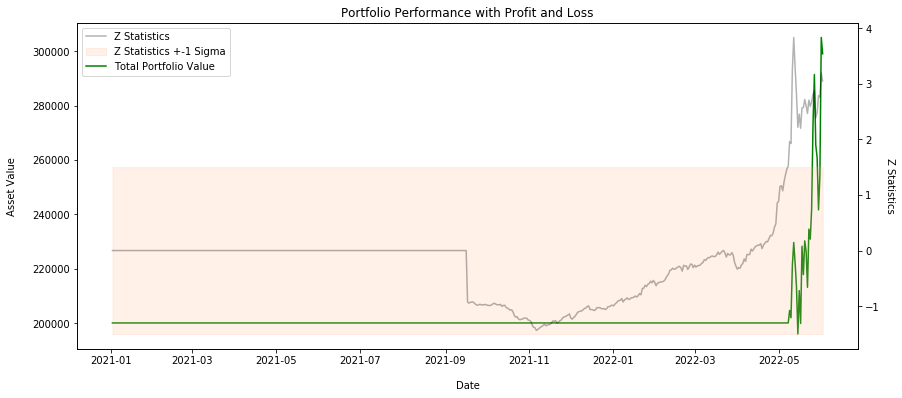

In [166]:
pnl1(data_portfolio1,'ETH-USD','SOL-USD')

For pair trading with GBM!!!

In [167]:
import numpy as np
# functins to determine signals and whether to trade for every day!!!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=new_portfolio.iloc[:,0]/new_portfolio.iloc[:,1]

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['signals2'] = -data['signals1']
    data['movingzs']=movingzs
    return data

In [168]:
# call the function and generate a table with stock adjusted close prices
stocks1 = ["ETH-USD","SOL-USD"]
data_portfolio=combine_stocks(stocks1,start,end)
data_portfolio1_1=pair_signals_gbm(data_portfolio,259,1.5)

                ETH-USD
Date                   
2021-01-01   730.367554
2021-01-02   774.534973
2021-01-03   975.507690
2021-01-04  1040.233032
2021-01-05  1100.006104
             SOL-USD
Date                
2021-01-01  1.842084
2021-01-02  1.799275
2021-01-03  2.161752
2021-01-04  2.485097
2021-01-05  2.157217
                ETH-USD   SOL-USD
Date                             
2021-01-01   730.367554  1.842084
2021-01-02   774.534973  1.799275
2021-01-03   975.507690  2.161752
2021-01-04  1040.233032  2.485097
2021-01-05  1100.006104  2.157217


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


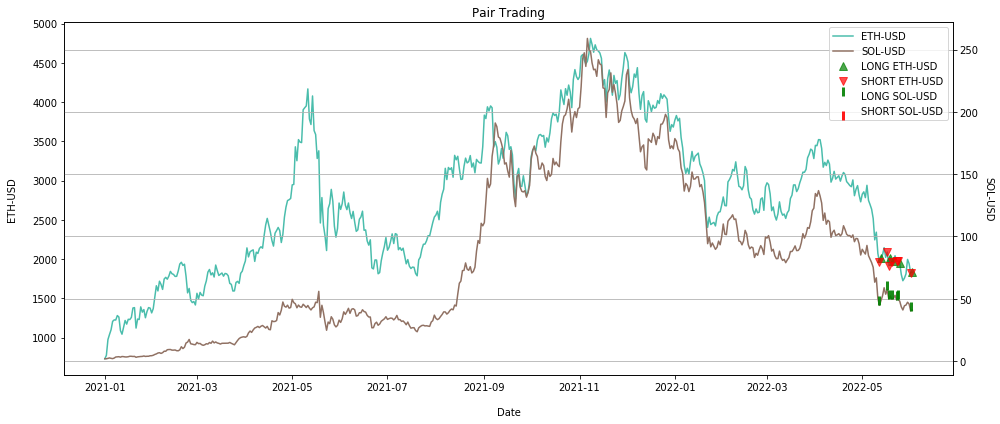

In [169]:
data_portfolio1_1=pair_trading2(data_portfolio1_1,'ETH-USD','SOL-USD',1.5)

Number of days =  258.0
CAGR = 206.634%


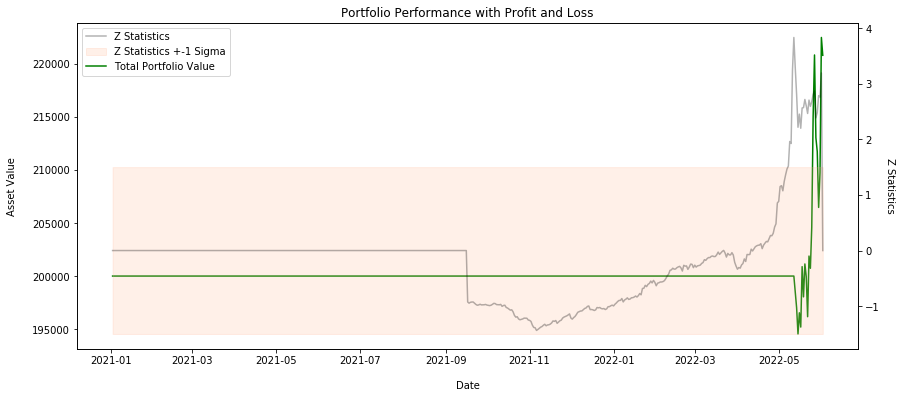

In [170]:
pnl2(data_portfolio1_1,'ETH-USD','SOL-USD')

# BNB&MATIC

2020.1.1-2022.1.1

In [171]:
# we plan to evaluate the 3-year data 
# As USD coins have not been put into the market until 2019
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2022,1,1)
# call the function and generate a table with stock adjusted close prices
# call the function and generate a table with stock adjusted close prices
stocks3 = ["MATIC-USD","BNB-USD"]
portfolio3=combine_stocks(stocks3,start,end)

            MATIC-USD
Date                 
2020-01-01   0.014962
2020-01-02   0.014651
2020-01-03   0.015194
2020-01-04   0.014961
2020-01-05   0.014914
              BNB-USD
Date                 
2020-01-01  13.689083
2020-01-02  13.027011
2020-01-03  13.660452
2020-01-04  13.891512
2020-01-05  14.111019
            MATIC-USD    BNB-USD
Date                            
2020-01-01   0.014962  13.689083
2020-01-02   0.014651  13.027011
2020-01-03   0.015194  13.660452
2020-01-04   0.014961  13.891512
2020-01-05   0.014914  14.111019


Test for cointegration

In [172]:
result = ts.coint(portfolio3['BNB-USD'],portfolio3['MATIC-USD'])
result[1]

0.04491692474881632

Reject null hypothesis and it's cointegrated!!!

Test stationarity of the price ratio and spread

In [173]:
import numpy as np
portfolio3['log price ratio']=np.log(portfolio3['BNB-USD'])/np.log(portfolio3['MATIC-USD'])
portfolio3['price ratio']=portfolio3['BNB-USD']/portfolio3['MATIC-USD']
portfolio3['spread']=regr(np.log(portfolio3['BNB-USD']),np.log(portfolio3['MATIC-USD']))

In [174]:
adf_t(portfolio3)

MATIC-USD         BNB-USD log price ratio     price ratio  \
0  not stationary  not stationary      stationary  not stationary   

           spread  
0  not stationary

In [175]:
len(portfolio3['BNB-USD'])

733

Determine normal pair trading strategy and performance 

In [176]:
data_portfolio3=data_prep1(366,portfolio3,'BNB-USD','MATIC-USD')

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

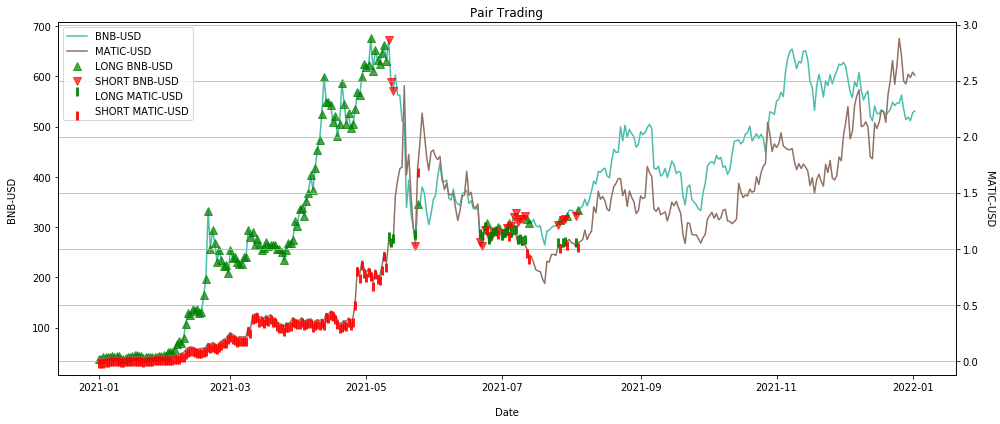

In [177]:
data_portfolio3=pair_trading1(data_portfolio3,'BNB-USD','MATIC-USD',1.5)

Number of days =  365
CAGR = 10198.120%


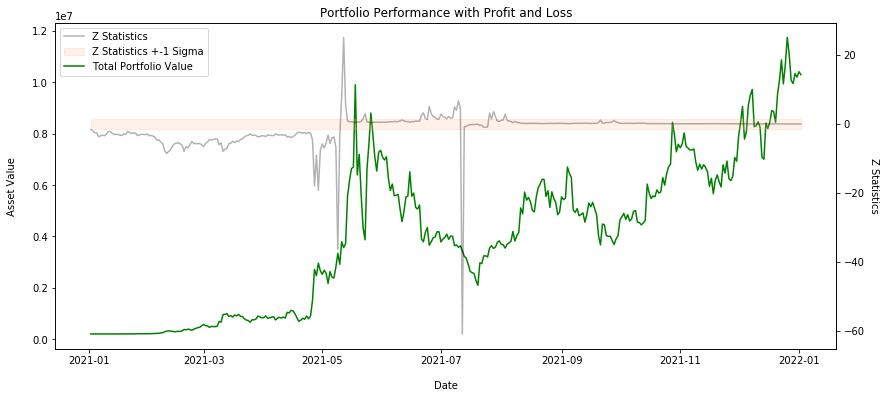

In [178]:
pnl1(data_portfolio3,'BNB-USD','MATIC-USD')

Determine GBM pair trading and performance

In [179]:
# we plan to evaluate the 3-year data 
# As USD coins have not been put into the market until 2019
# call the function and generate a table with stock adjusted close prices
# call the function and generate a table with stock adjusted close prices
stocks3 = ["MATIC-USD","BNB-USD"]
data_portfolio=combine_stocks(stocks3,start,end)

            MATIC-USD
Date                 
2020-01-01   0.014962
2020-01-02   0.014651
2020-01-03   0.015194
2020-01-04   0.014961
2020-01-05   0.014914
              BNB-USD
Date                 
2020-01-01  13.689083
2020-01-02  13.027011
2020-01-03  13.660452
2020-01-04  13.891512
2020-01-05  14.111019
            MATIC-USD    BNB-USD
Date                            
2020-01-01   0.014962  13.689083
2020-01-02   0.014651  13.027011
2020-01-03   0.015194  13.660452
2020-01-04   0.014961  13.891512
2020-01-05   0.014914  14.111019


In [180]:
# functins to determine signals and whether to trade for every day!!!
# notice to change the data into nplog price ratio as well!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*(time_period*2+1)
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=np.log(new_portfolio.iloc[:,0])/np.log(new_portfolio.iloc[:,1])

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['movingzs']=movingzs
    data['signals2'] = -data['signals1']
    data['signals2'][-1] = -data['signals1'][-1]

    return data

In [181]:
data_portfolio3_1=pair_signals_gbm(data_portfolio,366,1.5)

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

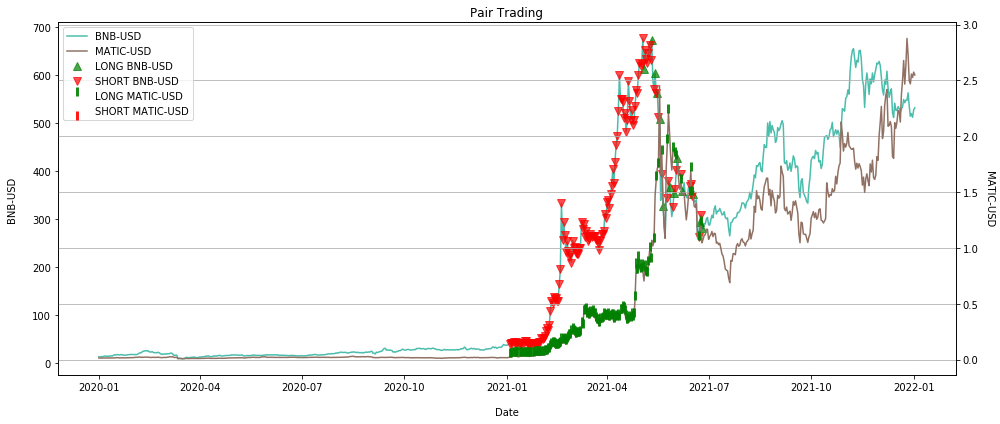

In [182]:
data_portfolio3_1=pair_trading2(data_portfolio3_1,'BNB-USD','MATIC-USD',1.5)

In [187]:
# functions to calculate profit and losses!!!
def pnl2(data,S1,S2):
    '''
    data: output dataframe from previous function
    S1: stock1 name (string)
    S2: stock2 name (string)
    threshold: z-scored threshold
    '''
    # function to calculate returns and do backtesting
    # code to calculate the profit and loss
    # initial capital to calculate the actual pnl
    initial_capital = 100000

    # shares to buy for each position
    positions1 = initial_capital// max(data[S1])
    positions2 = initial_capital// max(data[S2])

    # since there are two assets, we calculate each asset Pnl 
    # separately and in the end we aggregate them into one portfolio
    portfolio = pd.DataFrame()
    portfolio[S1] = data[S1]
    portfolio['holdings1'] = data['positions1'].cumsum() * data[S1] * positions1
    portfolio['cash1'] = initial_capital - (data['positions1'].cumsum() * data[S1] * positions1)
    portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total asset1'].pct_change()
    portfolio['positions1'] = data['positions1']

    # pnl for the 2nd asset
    portfolio[S2] = data[S2]
    portfolio['holdings2'] = (data['positions2']* data[S2] * positions2).cumsum()
    portfolio['cash2'] = initial_capital - (data['positions2'].cumsum() * data[S2] * positions2)
    portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total asset2'].pct_change()
    portfolio['positions2'] = data['positions2']

    # total pnl and z-score
    portfolio['z'] = data['movingzs'] #tells when the trade occurs!!!
    portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
    portfolio['z upper limit'] = 1.5
    portfolio['z lower limit'] = -1.5
    portfolio = portfolio.dropna()

    # plot the asset value change of the portfolio and pnl along with z-score
    fig = plt.figure(figsize=(14,6),)
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    l1, = ax.plot(portfolio['total asset'], c='g')
    l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
    b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],portfolio['z lower limit'], alpha=0.2,color='#ffb48f')
    ax.set_ylabel('Asset Value')
    ax2.set_ylabel('Z Statistics',rotation=270)
    ax.yaxis.labelpad=15
    ax2.yaxis.labelpad=15
    ax.set_xlabel('Date')
    ax.xaxis.labelpad=15
    plt.title('Portfolio Performance with Profit and Loss')
    plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');

    # calculate CAGR
    final_portfolio = portfolio['total asset'].iloc[-1]
    #return final_portfolio

CAGR(-9944.142496144399+84.50012376415313j)


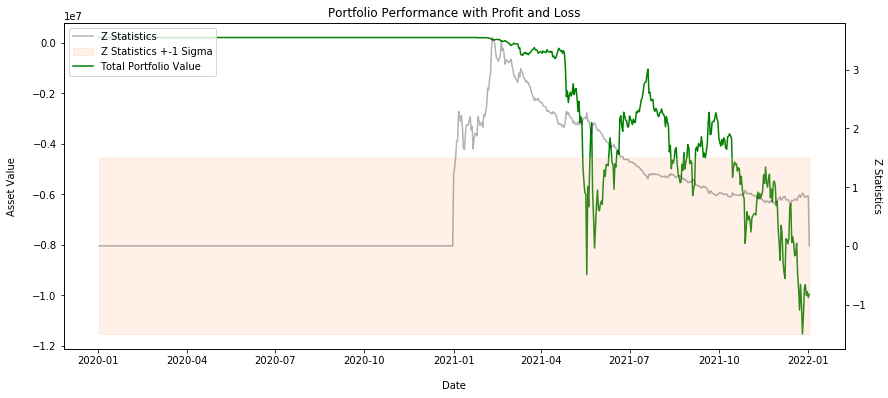

In [189]:
print("CAGR"+str(returns*100))
pnl2(data_portfolio3_1,'BNB-USD','MATIC-USD')

In [186]:
delta = 366
print('Number of days = ', delta)
YEAR_DAYS = 365
returns = (-9969071.15747065/100000) ** (365/366) - 1
returns*100

Number of days =  366


(-9944.142496144399+84.50012376415313j)

A huge loss!!!

2020.1.1-2022.3.1

In [190]:
# we plan to evaluate the 3-year data 
# As USD coins have not been put into the market until 2019
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2022,3,1)
# call the function and generate a table with stock adjusted close prices
# call the function and generate a table with stock adjusted close prices
stocks3 = ["MATIC-USD","BNB-USD"]
portfolio3=combine_stocks(stocks3,start,end)

            MATIC-USD
Date                 
2020-01-01   0.014962
2020-01-02   0.014651
2020-01-03   0.015194
2020-01-04   0.014961
2020-01-05   0.014914
              BNB-USD
Date                 
2020-01-01  13.689083
2020-01-02  13.027011
2020-01-03  13.660452
2020-01-04  13.891512
2020-01-05  14.111019
            MATIC-USD    BNB-USD
Date                            
2020-01-01   0.014962  13.689083
2020-01-02   0.014651  13.027011
2020-01-03   0.015194  13.660452
2020-01-04   0.014961  13.891512
2020-01-05   0.014914  14.111019


In [191]:
result = ts.coint(portfolio3['BNB-USD'],portfolio3['MATIC-USD'])
result[1]

0.04001797658736567

In [192]:
import numpy as np
portfolio3['log price ratio']=np.log(portfolio3['BNB-USD'])/np.log(portfolio3['MATIC-USD'])
portfolio3['price ratio']=portfolio3['BNB-USD']/portfolio3['MATIC-USD']
portfolio3['spread']=regr(np.log(portfolio3['BNB-USD']),np.log(portfolio3['MATIC-USD']))

In [193]:
adf_t(portfolio3)

MATIC-USD         BNB-USD log price ratio     price ratio  \
0  not stationary  not stationary      stationary  not stationary   

           spread  
0  not stationary

In [194]:
len(portfolio3['BNB-USD'])

792

Determine normal pair trading strategy and performance

In [195]:
data_portfolio3=data_prep1(396,portfolio3,'BNB-USD','MATIC-USD')

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

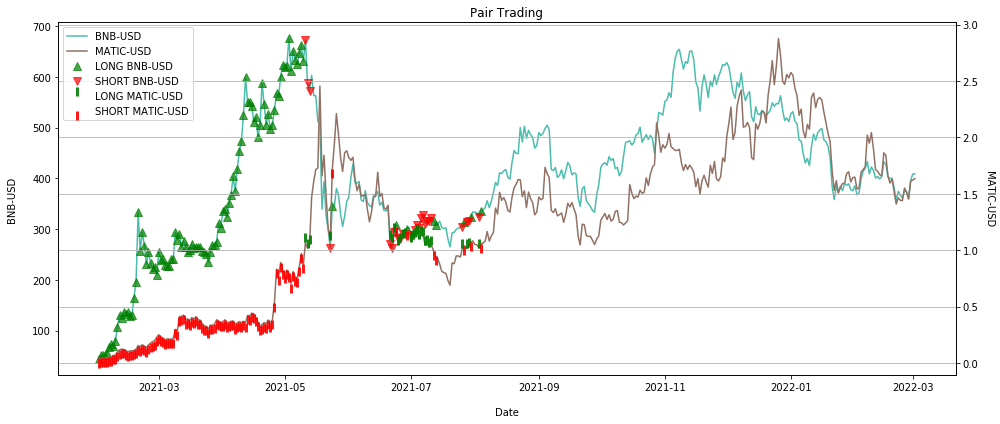

In [196]:
data_portfolio3=pair_trading1(data_portfolio3,'BNB-USD','MATIC-USD',1.5)

Number of days =  394
CAGR = 3383.858%


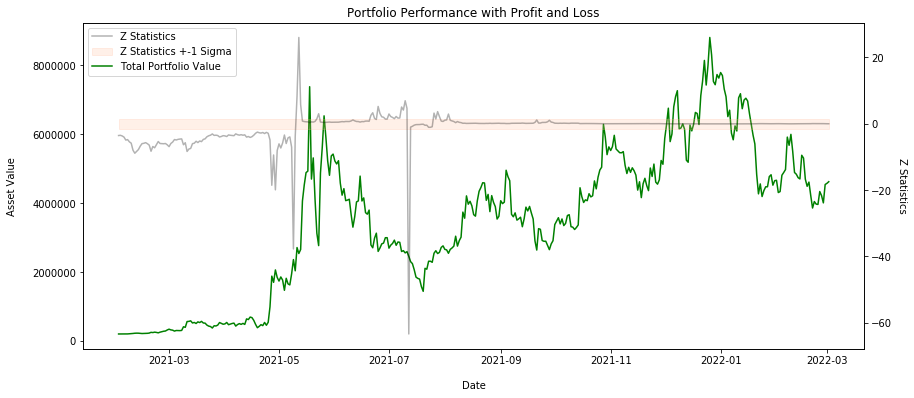

In [197]:
pnl1(data_portfolio3,'BNB-USD','MATIC-USD')

Determine GBM pair trading and performance

In [198]:
# we plan to evaluate the 3-year data 
# As USD coins have not been put into the market until 2019
# call the function and generate a table with stock adjusted close prices
# call the function and generate a table with stock adjusted close prices
stocks3 = ["MATIC-USD","BNB-USD"]
data_portfolio=combine_stocks(stocks3,start,end)

            MATIC-USD
Date                 
2020-01-01   0.014962
2020-01-02   0.014651
2020-01-03   0.015194
2020-01-04   0.014961
2020-01-05   0.014914
              BNB-USD
Date                 
2020-01-01  13.689083
2020-01-02  13.027011
2020-01-03  13.660452
2020-01-04  13.891512
2020-01-05  14.111019
            MATIC-USD    BNB-USD
Date                            
2020-01-01   0.014962  13.689083
2020-01-02   0.014651  13.027011
2020-01-03   0.015194  13.660452
2020-01-04   0.014961  13.891512
2020-01-05   0.014914  14.111019


In [199]:
# functins to determine signals and whether to trade for every day!!!
# notice to change the data into nplog price ratio as well!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*(time_period*2)
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=np.log(new_portfolio.iloc[:,0])/np.log(new_portfolio.iloc[:,1])

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['movingzs']=movingzs
    data['signals2'] = -data['signals1']
    data['signals2'][-1] = -data['signals1'][-1]

    return data

In [200]:
data_portfolio3_1=pair_signals_gbm(data_portfolio,396,1.5)

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

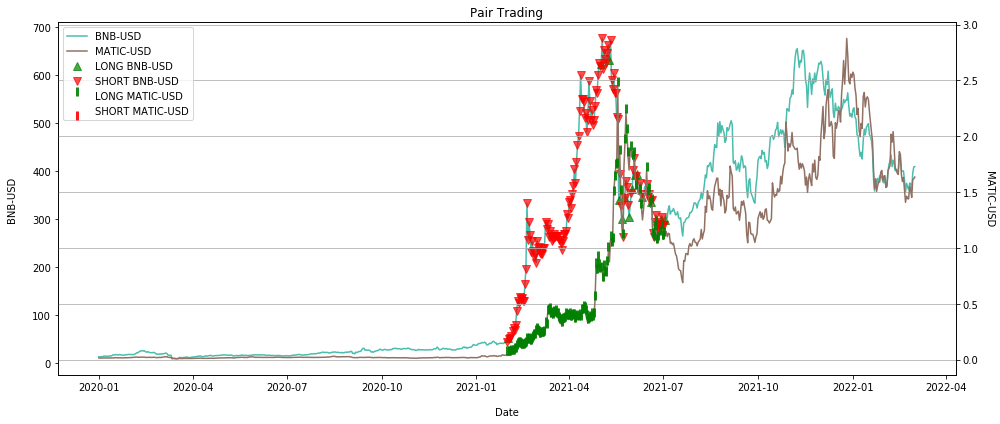

In [201]:
data_portfolio3_1=pair_trading2(data_portfolio3_1,'BNB-USD','MATIC-USD',1.5)

In [205]:
# functions to calculate profit and losses!!!
def pnl2(data,S1,S2):
    '''
    data: output dataframe from previous function
    S1: stock1 name (string)
    S2: stock2 name (string)
    threshold: z-scored threshold
    '''
    # function to calculate returns and do backtesting
    # code to calculate the profit and loss
    # initial capital to calculate the actual pnl
    initial_capital = 100000

    # shares to buy for each position
    positions1 = initial_capital// max(data[S1])
    positions2 = initial_capital// max(data[S2])

    # since there are two assets, we calculate each asset Pnl 
    # separately and in the end we aggregate them into one portfolio
    portfolio = pd.DataFrame()
    portfolio[S1] = data[S1]
    portfolio['holdings1'] = data['positions1'].cumsum() * data[S1] * positions1
    portfolio['cash1'] = initial_capital - (data['positions1'].cumsum() * data[S1] * positions1)
    portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total asset1'].pct_change()
    portfolio['positions1'] = data['positions1']

    # pnl for the 2nd asset
    portfolio[S2] = data[S2]
    portfolio['holdings2'] = (data['positions2']* data[S2] * positions2).cumsum()
    portfolio['cash2'] = initial_capital - (data['positions2'].cumsum() * data[S2] * positions2)
    portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total asset2'].pct_change()
    portfolio['positions2'] = data['positions2']

    # total pnl and z-score
    portfolio['z'] = data['movingzs'] #tells when the trade occurs!!!
    portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
    portfolio['z upper limit'] = 1.5
    portfolio['z lower limit'] = -1.5
    portfolio = portfolio.dropna()

    # plot the asset value change of the portfolio and pnl along with z-score
    fig = plt.figure(figsize=(14,6),)
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    l1, = ax.plot(portfolio['total asset'], c='g')
    l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
    b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],portfolio['z lower limit'], alpha=0.2,color='#ffb48f')
    ax.set_ylabel('Asset Value')
    ax2.set_ylabel('Z Statistics',rotation=270)
    ax.yaxis.labelpad=15
    ax2.yaxis.labelpad=15
    ax.set_xlabel('Date')
    ax.xaxis.labelpad=15
    plt.title('Portfolio Performance with Profit and Loss')
    plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');

    # calculate CAGR
    final_portfolio = portfolio['total asset'].iloc[-1]
    #return final_portfolio

CAGR(-3253.618237387089+791.6022280054934j)


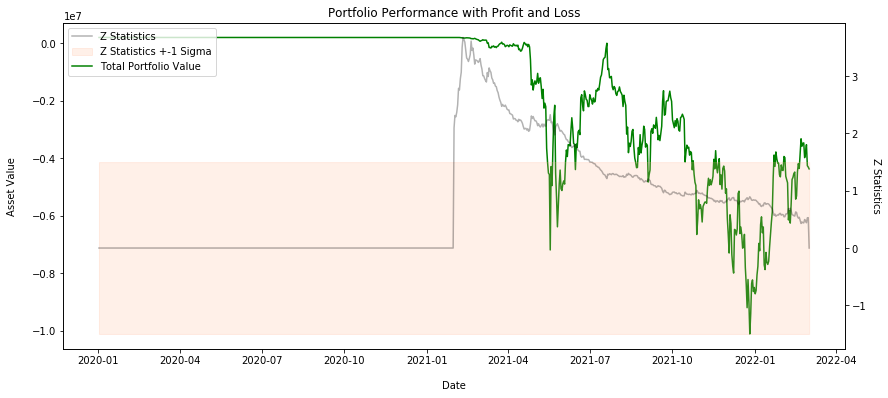

In [206]:
print("CAGR"+str(returns*100))
pnl2(data_portfolio3_1,'BNB-USD','MATIC-USD')

In [204]:
delta = 366
print('Number of days = ', delta)
YEAR_DAYS = 365
returns = (-4370190.800058171/100000) ** (365/396) - 1
returns*100

Number of days =  366


(-3253.618237387089+791.6022280054934j)

2020.1.1-2022.6.1

In [207]:
# we plan to evaluate the 3-year data 
# As USD coins have not been put into the market until 2019
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2022,6,1)
# call the function and generate a table with stock adjusted close prices
# call the function and generate a table with stock adjusted close prices
stocks3 = ["MATIC-USD","BNB-USD"]
portfolio3=combine_stocks(stocks3,start,end)

            MATIC-USD
Date                 
2020-01-01   0.014962
2020-01-02   0.014651
2020-01-03   0.015194
2020-01-04   0.014961
2020-01-05   0.014914
              BNB-USD
Date                 
2020-01-01  13.689083
2020-01-02  13.027011
2020-01-03  13.660452
2020-01-04  13.891512
2020-01-05  14.111019
            MATIC-USD    BNB-USD
Date                            
2020-01-01   0.014962  13.689083
2020-01-02   0.014651  13.027011
2020-01-03   0.015194  13.660452
2020-01-04   0.014961  13.891512
2020-01-05   0.014914  14.111019


In [208]:
result = ts.coint(portfolio3['BNB-USD'],portfolio3['MATIC-USD'])
result[1]

0.028614291079152965

In [209]:
import numpy as np
portfolio3['log price ratio']=np.log(portfolio3['BNB-USD'])/np.log(portfolio3['MATIC-USD'])
portfolio3['price ratio']=portfolio3['BNB-USD']/portfolio3['MATIC-USD']
portfolio3['spread']=regr(np.log(portfolio3['BNB-USD']),np.log(portfolio3['MATIC-USD']))

In [210]:
adf_t(portfolio3)

MATIC-USD         BNB-USD log price ratio     price ratio  \
0  not stationary  not stationary      stationary  not stationary   

           spread  
0  not stationary

In [211]:
len(portfolio3['BNB-USD'])

884

Determine normal pair trading strategy and performance

In [212]:
data_portfolio3=data_prep1(442,portfolio3,'BNB-USD','MATIC-USD')

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

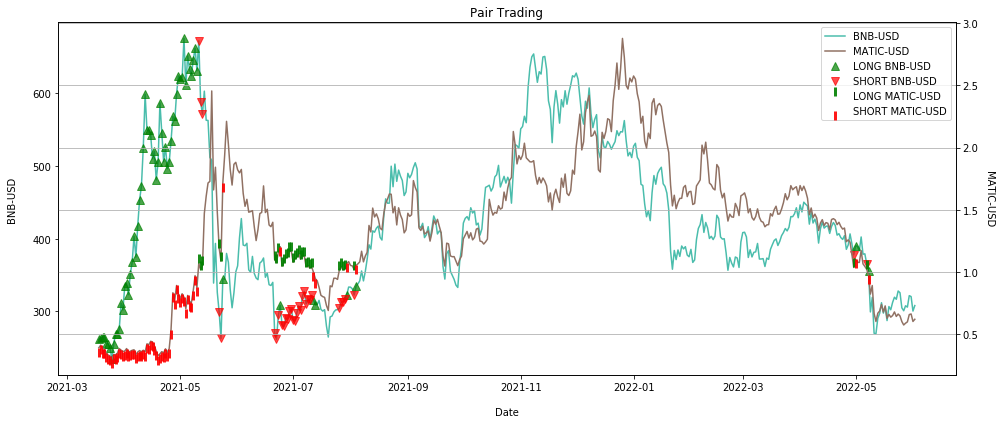

In [213]:
data_portfolio3=pair_trading1(data_portfolio3,'BNB-USD','MATIC-USD',1.5)

Number of days =  440
CAGR = 294.136%


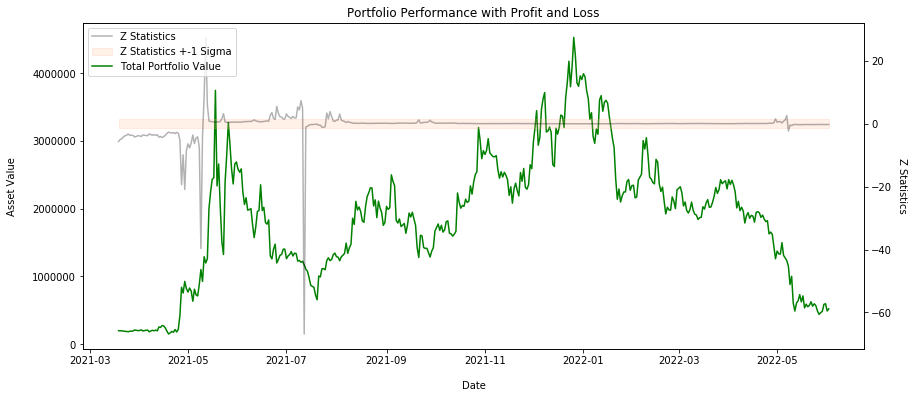

In [214]:
pnl1(data_portfolio3,'BNB-USD','MATIC-USD')

Determine GBM pair trading and performance

In [215]:
# call the function and generate a table with stock adjusted close prices
# call the function and generate a table with stock adjusted close prices
stocks3 = ["MATIC-USD","BNB-USD"]
data_portfolio=combine_stocks(stocks3,start,end)

            MATIC-USD
Date                 
2020-01-01   0.014962
2020-01-02   0.014651
2020-01-03   0.015194
2020-01-04   0.014961
2020-01-05   0.014914
              BNB-USD
Date                 
2020-01-01  13.689083
2020-01-02  13.027011
2020-01-03  13.660452
2020-01-04  13.891512
2020-01-05  14.111019
            MATIC-USD    BNB-USD
Date                            
2020-01-01   0.014962  13.689083
2020-01-02   0.014651  13.027011
2020-01-03   0.015194  13.660452
2020-01-04   0.014961  13.891512
2020-01-05   0.014914  14.111019


In [216]:
# functins to determine signals and whether to trade for every day!!!
# notice to change the data into nplog price ratio as well!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*(time_period*2)
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=np.log(new_portfolio.iloc[:,0])/np.log(new_portfolio.iloc[:,1])

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['movingzs']=movingzs
    data['signals2'] = -data['signals1']
    data['signals2'][-1] = -data['signals1'][-1]

    return data

In [218]:
data_portfolio3_1=pair_signals_gbm(data_portfolio,442,1.5)

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


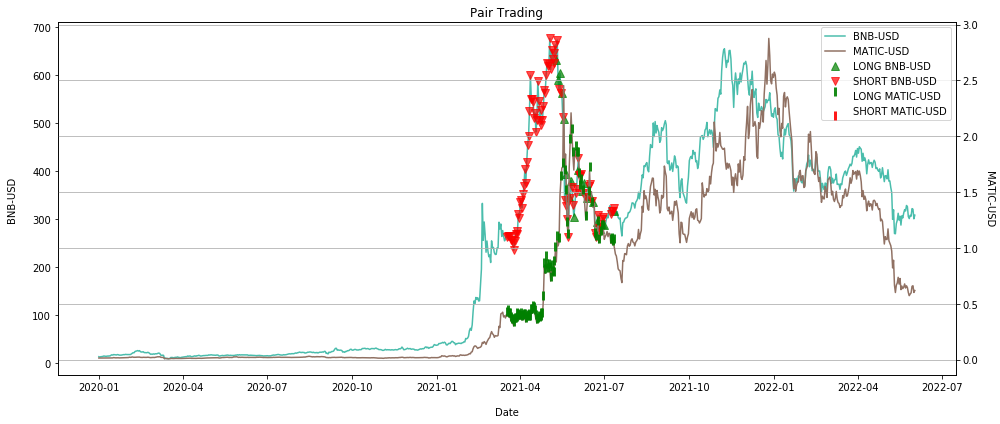

In [219]:
data_portfolio3_1=pair_trading2(data_portfolio3_1,'BNB-USD','MATIC-USD',1.5)

In [224]:
# functions to calculate profit and losses!!!
def pnl2(data,S1,S2):
    '''
    data: output dataframe from previous function
    S1: stock1 name (string)
    S2: stock2 name (string)
    threshold: z-scored threshold
    '''
    # function to calculate returns and do backtesting
    # code to calculate the profit and loss
    # initial capital to calculate the actual pnl
    initial_capital = 100000

    # shares to buy for each position
    positions1 = initial_capital// max(data[S1])
    positions2 = initial_capital// max(data[S2])

    # since there are two assets, we calculate each asset Pnl 
    # separately and in the end we aggregate them into one portfolio
    portfolio = pd.DataFrame()
    portfolio[S1] = data[S1]
    portfolio['holdings1'] = data['positions1'].cumsum() * data[S1] * positions1
    portfolio['cash1'] = initial_capital - (data['positions1'].cumsum() * data[S1] * positions1)
    portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total asset1'].pct_change()
    portfolio['positions1'] = data['positions1']

    # pnl for the 2nd asset
    portfolio[S2] = data[S2]
    portfolio['holdings2'] = (data['positions2']* data[S2] * positions2).cumsum()
    portfolio['cash2'] = initial_capital - (data['positions2'].cumsum() * data[S2] * positions2)
    portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total asset2'].pct_change()
    portfolio['positions2'] = data['positions2']

    # total pnl and z-score
    portfolio['z'] = data['movingzs'] #tells when the trade occurs!!!
    portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
    portfolio['z upper limit'] = 1.5
    portfolio['z lower limit'] = -1.5
    portfolio = portfolio.dropna()

    # plot the asset value change of the portfolio and pnl along with z-score
    fig = plt.figure(figsize=(14,6),)
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    l1, = ax.plot(portfolio['total asset'], c='g')
    l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
    b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],portfolio['z lower limit'], alpha=0.2,color='#ffb48f')
    ax.set_ylabel('Asset Value')
    ax2.set_ylabel('Z Statistics',rotation=270)
    ax.yaxis.labelpad=15
    ax2.yaxis.labelpad=15
    ax.set_xlabel('Date')
    ax.xaxis.labelpad=15
    plt.title('Portfolio Performance with Profit and Loss')
    plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');

    # calculate CAGR
    final_portfolio = portfolio['total asset'].iloc[-1]
    #return final_portfolio

CAGR: 480.37252135079393


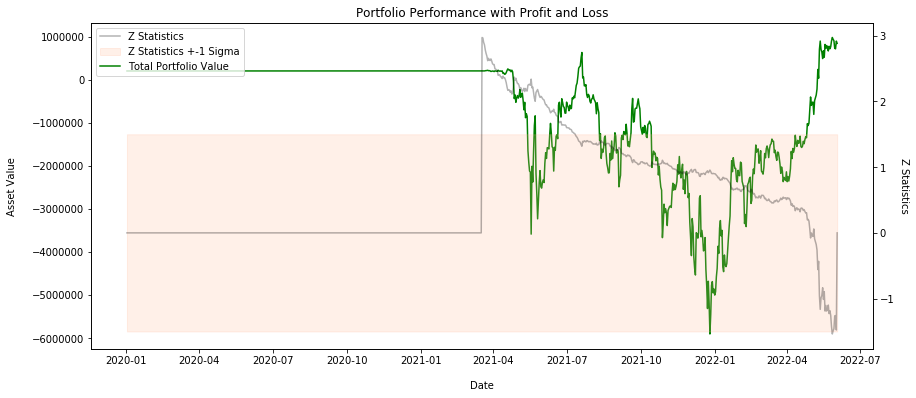

In [226]:
print("CAGR: "+str(returns*100))
pnl2(data_portfolio3_1,'BNB-USD','MATIC-USD')

In [223]:
delta = 366
print('Number of days = ', delta)
YEAR_DAYS = 365
returns = (841041.8376476467/100000) ** (365/442) - 1
returns*100

Number of days =  366


480.37252135079393

In [234]:
( "fish" == "sauce" ) or not ( "sauce" == "SAUCE".lower( ) )


False

2020.1.1-2022.9.1

In [235]:
# we plan to evaluate the 3-year data 
# As USD coins have not been put into the market until 2019
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2022,9,1)
# call the function and generate a table with stock adjusted close prices
# call the function and generate a table with stock adjusted close prices
stocks3 = ["MATIC-USD","BNB-USD"]
portfolio3=combine_stocks(stocks3,start,end)

            MATIC-USD
Date                 
2020-01-01   0.014962
2020-01-02   0.014651
2020-01-03   0.015194
2020-01-04   0.014961
2020-01-05   0.014914
              BNB-USD
Date                 
2020-01-01  13.689083
2020-01-02  13.027011
2020-01-03  13.660452
2020-01-04  13.891512
2020-01-05  14.111019
            MATIC-USD    BNB-USD
Date                            
2020-01-01   0.014962  13.689083
2020-01-02   0.014651  13.027011
2020-01-03   0.015194  13.660452
2020-01-04   0.014961  13.891512
2020-01-05   0.014914  14.111019


In [236]:
result = ts.coint(portfolio3['BNB-USD'],portfolio3['MATIC-USD'])
result[1]

0.014457542125246607

In [237]:
import numpy as np
portfolio3['log price ratio']=np.log(portfolio3['BNB-USD'])/np.log(portfolio3['MATIC-USD'])
portfolio3['price ratio']=portfolio3['BNB-USD']/portfolio3['MATIC-USD']
portfolio3['spread']=regr(np.log(portfolio3['BNB-USD']),np.log(portfolio3['MATIC-USD']))

In [238]:
adf_t(portfolio3)

MATIC-USD         BNB-USD log price ratio     price ratio  \
0  not stationary  not stationary      stationary  not stationary   

           spread  
0  not stationary

In [239]:
len(portfolio3['BNB-USD'])

976

Normal pair trading

In [240]:
data_portfolio3=data_prep1(488,portfolio3,'BNB-USD','MATIC-USD')

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

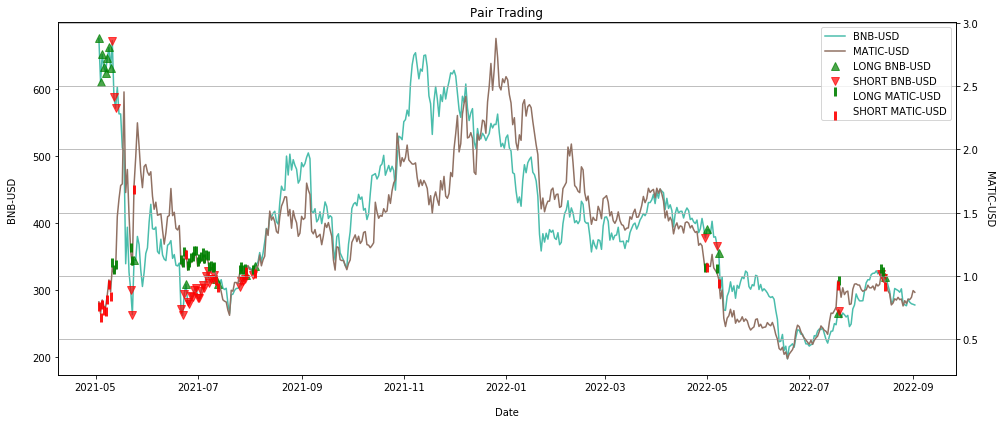

In [241]:
data_portfolio3=pair_trading1(data_portfolio3,'BNB-USD','MATIC-USD',1.5)

Number of days =  486
CAGR = 109.328%


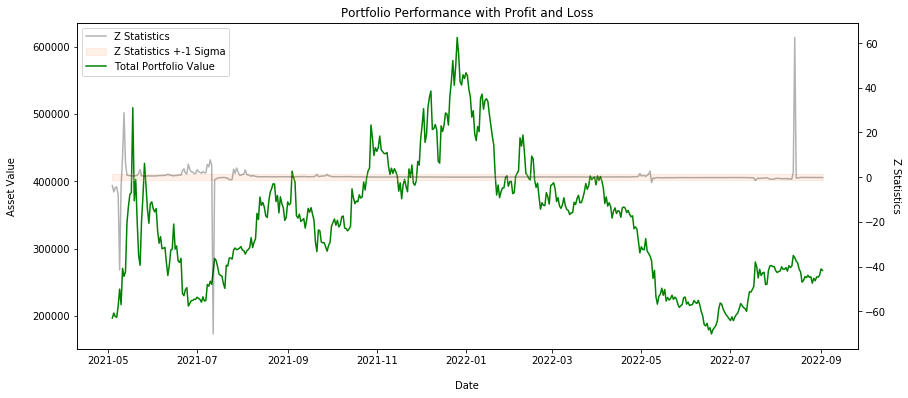

In [242]:
pnl1(data_portfolio3,'BNB-USD','MATIC-USD')

GBM pair trading

In [243]:
# call the function and generate a table with stock adjusted close prices
# call the function and generate a table with stock adjusted close prices
stocks3 = ["MATIC-USD","BNB-USD"]
data_portfolio=combine_stocks(stocks3,start,end)

            MATIC-USD
Date                 
2020-01-01   0.014962
2020-01-02   0.014651
2020-01-03   0.015194
2020-01-04   0.014961
2020-01-05   0.014914
              BNB-USD
Date                 
2020-01-01  13.689083
2020-01-02  13.027011
2020-01-03  13.660452
2020-01-04  13.891512
2020-01-05  14.111019
            MATIC-USD    BNB-USD
Date                            
2020-01-01   0.014962  13.689083
2020-01-02   0.014651  13.027011
2020-01-03   0.015194  13.660452
2020-01-04   0.014961  13.891512
2020-01-05   0.014914  14.111019


In [244]:
# functins to determine signals and whether to trade for every day!!!
# notice to change the data into nplog price ratio as well!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*(time_period*2)
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=np.log(new_portfolio.iloc[:,0])/np.log(new_portfolio.iloc[:,1])

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['movingzs']=movingzs
    data['signals2'] = -data['signals1']
    data['signals2'][-1] = -data['signals1'][-1]

    return data

In [245]:
data_portfolio3_1=pair_signals_gbm(data_portfolio,488,1.5)

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

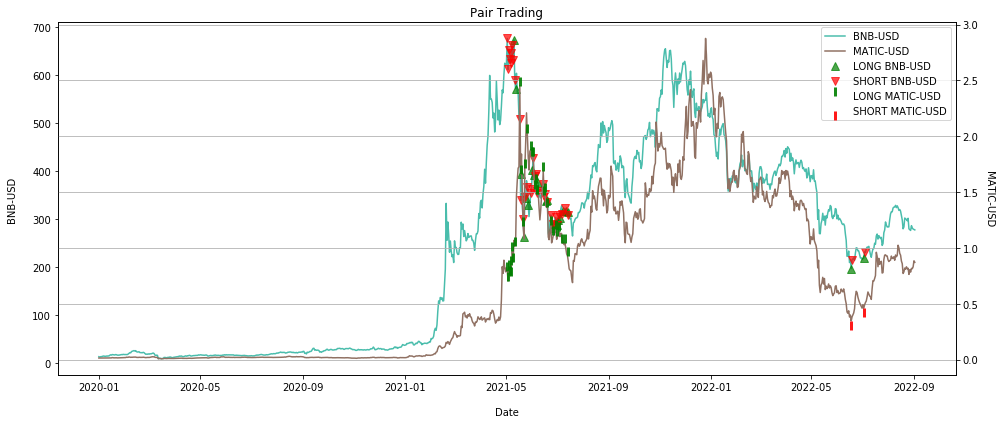

In [246]:
data_portfolio3_1=pair_trading2(data_portfolio3_1,'BNB-USD','MATIC-USD',1.5)

CAGR: 534.2294016258702%


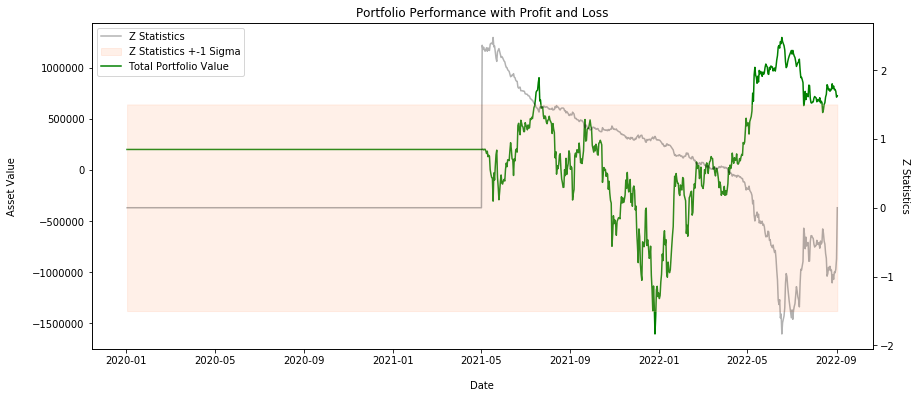

In [249]:
print("CAGR: 534.2294016258702%")
pnl2(data_portfolio3_1,'BNB-USD','MATIC-USD')

In [404]:
delta = 366
print('Number of days = ', delta)
YEAR_DAYS = 365
returns = (637447.3301089108/100000) ** (365/366) - 1
returns*100

Number of days =  366


534.2294016258702

# ADA&DOGE

# BCH&XMR

2021.6.1-2021.8.1

In [250]:
# we plan to evaluate the 3-year data 
# As USD coins have not been put into the market until 2019
start = datetime.datetime(2021,6,1)
end = datetime.datetime(2021,8,2)
# call the function and generate a table with stock adjusted close prices
# call the function and generate a table with stock adjusted close prices
stocks5 = ["BCH-USD","XMR-USD"]
portfolio5=combine_stocks(stocks5,start,end)

               BCH-USD
Date                  
2021-06-01  691.403870
2021-06-02  697.912964
2021-06-03  718.448181
2021-06-04  671.139160
2021-06-05  649.438354
               XMR-USD
Date                  
2021-06-01  265.774841
2021-06-02  294.092072
2021-06-03  308.188782
2021-06-04  287.463715
2021-06-05  264.308289
               BCH-USD     XMR-USD
Date                              
2021-06-01  691.403870  265.774841
2021-06-02  697.912964  294.092072
2021-06-03  718.448181  308.188782
2021-06-04  671.139160  287.463715
2021-06-05  649.438354  264.308289


In [251]:
result = ts.coint(portfolio5['BCH-USD'],portfolio5['XMR-USD'])
result[1]

0.005361168467821254

In [252]:
import numpy as np
portfolio5['log price ratio']=np.log(portfolio5['BCH-USD'])/np.log(portfolio5['XMR-USD'])
portfolio5['price ratio']=portfolio5['BCH-USD']/portfolio5['XMR-USD']
portfolio5['spread']=regr(np.log(portfolio5['BCH-USD']),np.log(portfolio5['XMR-USD']))

In [253]:
adf_t(portfolio5)

BCH-USD         XMR-USD log price ratio price ratio          spread
0  not stationary  not stationary      stationary  stationary  not stationary

Using log price ratio

Normal pair trading

In [254]:
len(portfolio5['BCH-USD'])

64

In [255]:
#notice: because here only log price ratio converge, so we only take log price ratio as spread
def data_prep1(time_period,data,S1,S2):
    #create a column for price ratio
    data['price ratio']=np.log(data[S1])/np.log(data[S2])
    # create columns for moving averages, standard deviations, and z_scores
    averages=[0]*time_period
    sds=[0]*time_period
    z_scores=[0]*time_period
    for i in range(time_period,len(data.iloc[:,0])):
        averages.append(np.mean(data.iloc[i-time_period:i,2]))
        sds.append(np.std(data.iloc[i-time_period:i,2]))
        z_scores.append((data.iloc[i,2]-np.mean(data.iloc[i-time_period:i,2]))/np.std(data.iloc[i-time_period:i,2]))
    data['moving_averages']=averages
    data['moving_stds']=sds
    data['moving_zs']=z_scores
    return data.iloc[time_period:,:]

In [256]:
data_portfolio5=data_prep1(32,portfolio5,'BCH-USD','XMR-USD')

In [257]:
# function to create trading signal table and plot the trading strategy
def pair_trading1(data,S1,S2,threshold):
    '''
    data: output dataframe from previous function
    S1: stock1 name (string)
    S2: stock2 name (string)
    threshold: z-scored threshold
    '''
    # create trading signals
    # create signal - short if z-score is greater than upper limit else long
    data['signals1'] = 0
    data['signals1'] = np.select([data['moving_zs'] > threshold, data['moving_zs'] < -threshold], [-1, 1], default=0)
    data['signals2'] = -data['signals1']

    # calculate positions of every day (1day of holding normally whereas if continuous buying, hold until buying everything)
    positions1=list(data['signals1'])
    positions2=list(data['signals2'])

    for i in range(len(data['signals1'])-1): 
        if positions1[i]!=0 and positions1[i+1]==0:
            if np.where(np.array(positions1[:i+1])==0)[0].size!=0:
                if np.max(np.where(np.array(positions1[:i+1])==0))==i-1:
                    positions1[i+1]=0-positions1[i]
                elif np.max(np.where(np.array(positions1[:i+1])==0))!=i-1:
                    positions1[i+1]=0-sum(positions1[np.max(np.where(np.array(positions1[:i+1])==0))+1:i+1])
        elif positions1[i]!=0 and np.where(np.array(positions1[i:])==0)[0].size==0:
            if np.where(np.array(positions1[:i+1])==0)[0].size!=0:
                if np.max(np.where(np.array(positions1[:i+1])==0))==i-1:
                    positions1[-1]=0-positions1[i]
                elif np.max(np.where(np.array(positions1[:i+1])==0))!=i-1:
                    positions1[-1]=0-sum(positions1[i:-1])
            
            
        
    for i in range(len(data['signals2'])-1): #holding days is 3 in this case
        if positions2[i]!=0 and positions2[i+1]==0:
            if np.where(np.array(positions2[:i+1])==0)[0].size!=0:
                if np.max(np.where(np.array(positions2[:i+1])==0))==i-1:
                    positions2[i+1]=0-positions2[i]
                elif np.max(np.where(np.array(positions2[:i+1])==0))!=i-1:
                    positions2[i+1]=0-sum(positions2[np.max(np.where(np.array(positions2[:i+1])==0))+1:i+1])
        elif positions2[i]!=0 and np.where(np.array(positions2[i:])==0)[0].size==0:
            if np.where(np.array(positions2[:i+1])==0)[0].size!=0:
                if np.max(np.where(np.array(positions2[:i+1])==0))==i-1:
                    positions2[-1]=0-positions2[i]
                elif np.max(np.where(np.array(positions2[:i+1])==0))!=i-1:
                    positions2[-1]=0-sum(positions2[i:-1])

    data['positions1']=np.array(positions1)
    data['positions2']=np.array(positions2)
    # verify datafame head and tail
    # data.head(3).append(data.tail(3))

    # visualize trading signals and position
    fig=plt.figure(figsize=(14,6))
    bx = fig.add_subplot(111)   
    bx2 = bx.twinx()

    #plot two different assets
    l1, = bx.plot(data[S1], c='#4abdac')
    l2, = bx2.plot(data[S2], c='#907163')
    u1, = bx.plot(data[S1][data['positions1'] >0], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
    d1, = bx.plot(data[S1][data['positions1'] <0], lw=0,marker='v',markersize=8, c='r',alpha=0.7)
    u2, = bx2.plot(data[S2][data['positions2'] >0], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)
    d2, = bx2.plot(data[S2][data['positions2'] <0], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)
    bx.set_ylabel(S1,)
    bx2.set_ylabel(S2, rotation=270)
    bx.yaxis.labelpad=15
    bx2.yaxis.labelpad=15
    bx.set_xlabel('Date')
    bx.xaxis.labelpad=15
    plt.legend([l1,l2,u1,d1,u2,d2], [S1,S2,'LONG {}'.format(S1),
            'SHORT {}'.format(S1),
           'LONG {}'.format(S2),
           'SHORT {}'.format(S2)], loc ='best')
    plt.title('Pair Trading')
    plt.xlabel('Date')
    plt.grid(True)

    plt.tight_layout()
    return data




/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

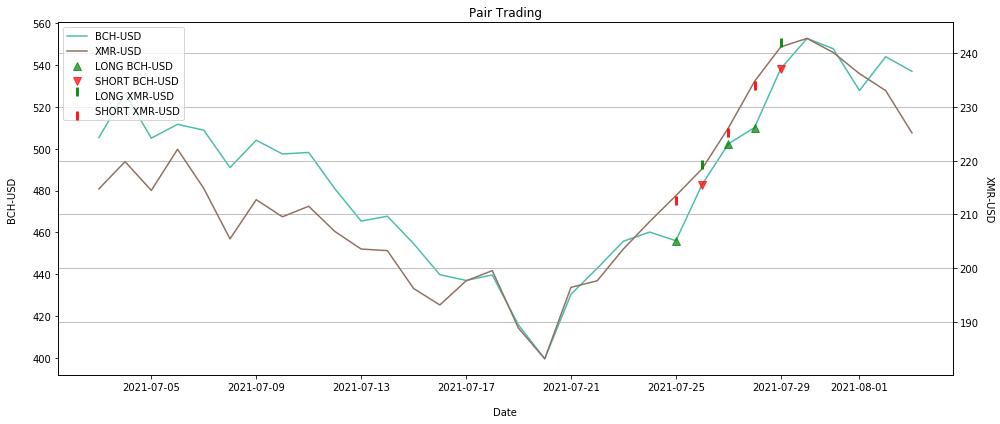

In [258]:
data_portfolio5=pair_trading1(data_portfolio5,'BCH-USD','XMR-USD',1.5)

Number of days =  30
CAGR = 878140.967%


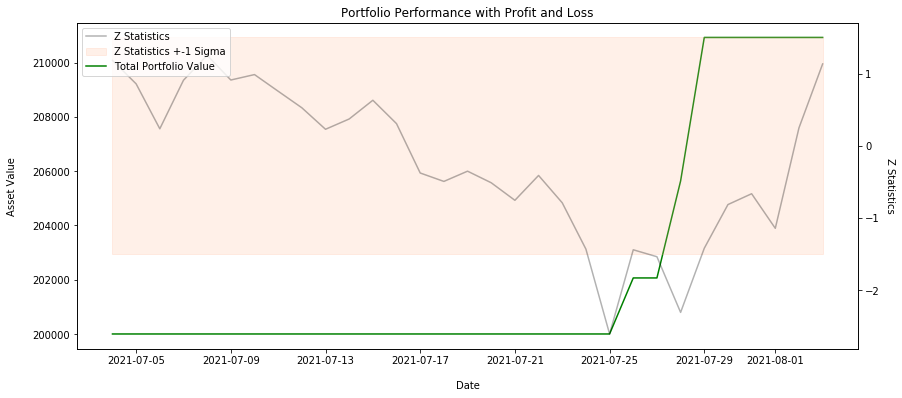

In [259]:
pnl1(data_portfolio5,'BCH-USD','XMR-USD')

In [260]:
' uh '.join( [ 'be', 'good', 'coder' ] )

'be uh good uh coder'

GBM pair trading

In [261]:
# functins to determine signals and whether to trade for every day!!!
# notice to change the data into nplog price ratio as well!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=np.log(new_portfolio.iloc[:,0])/np.log(new_portfolio.iloc[:,1])

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['movingzs']=movingzs
    data['signals2'] = -data['signals1']
    data['signals2'][-1] = -data['signals1'][-1]

    return data

In [262]:
# call the function and generate a table with stock adjusted close prices
stocks5 = ["BCH-USD","XMR-USD"]
data_portfolio=combine_stocks(stocks5,start,end)
data_portfolio5_1=pair_signals_gbm(data_portfolio,32,1.5)

               BCH-USD
Date                  
2021-06-01  691.403870
2021-06-02  697.912964
2021-06-03  718.448181
2021-06-04  671.139160
2021-06-05  649.438354
               XMR-USD
Date                  
2021-06-01  265.774841
2021-06-02  294.092072
2021-06-03  308.188782
2021-06-04  287.463715
2021-06-05  264.308289
               BCH-USD     XMR-USD
Date                              
2021-06-01  691.403870  265.774841
2021-06-02  697.912964  294.092072
2021-06-03  718.448181  308.188782
2021-06-04  671.139160  287.463715
2021-06-05  649.438354  264.308289


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


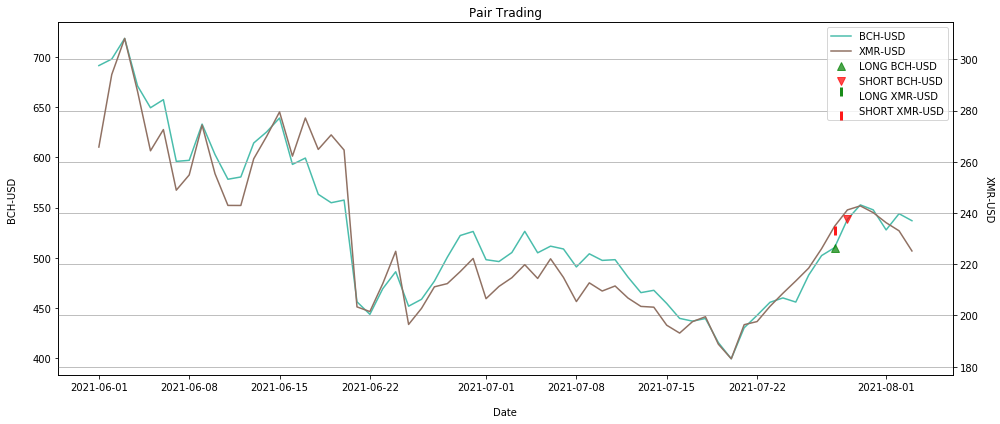

In [263]:
data_portfolio5_1=pair_trading2(data_portfolio5_1,'BCH-USD','XMR-USD',1.5)

In [266]:
# functions to calculate profit and losses!!!
def pnl2(data,S1,S2):
    '''
    data: output dataframe from previous function
    S1: stock1 name (string)
    S2: stock2 name (string)
    threshold: z-scored threshold
    '''
    # function to calculate returns and do backtesting
    # code to calculate the profit and loss
    # initial capital to calculate the actual pnl
    initial_capital = 100000

    # shares to buy for each position
    positions1 = initial_capital// max(data[S1])
    positions2 = initial_capital// max(data[S2])

    # since there are two assets, we calculate each asset Pnl 
    # separately and in the end we aggregate them into one portfolio
    portfolio = pd.DataFrame()
    portfolio[S1] = data[S1]
    portfolio['holdings1'] = data['positions1'].cumsum() * data[S1] * positions1
    portfolio['cash1'] = initial_capital - (data['positions1'].cumsum() * data[S1] * positions1)
    portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total asset1'].pct_change()
    portfolio['positions1'] = data['positions1']

    # pnl for the 2nd asset
    portfolio[S2] = data[S2]
    portfolio['holdings2'] = (data['positions2']* data[S2] * positions2).cumsum()
    portfolio['cash2'] = initial_capital - (data['positions2'].cumsum() * data[S2] * positions2)
    portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total asset2'].pct_change()
    portfolio['positions2'] = data['positions2']

    # total pnl and z-score
    portfolio['z'] = data['movingzs'] #tells when the trade occurs!!!
    portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
    portfolio['z upper limit'] = 1.5
    portfolio['z lower limit'] = -1.5
    portfolio = portfolio.dropna()

    # plot the asset value change of the portfolio and pnl along with z-score
    fig = plt.figure(figsize=(14,6),)
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    l1, = ax.plot(portfolio['total asset'], c='g')
    l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
    b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],portfolio['z lower limit'], alpha=0.2,color='#ffb48f')
    ax.set_ylabel('Asset Value')
    ax2.set_ylabel('Z Statistics',rotation=270)
    ax.yaxis.labelpad=15
    ax2.yaxis.labelpad=15
    ax.set_xlabel('Date')
    ax.xaxis.labelpad=15
    plt.title('Portfolio Performance with Profit and Loss')
    plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');

    # calculate CAGR
    final_portfolio = portfolio['total asset'].iloc[-1]
    delta = ((portfolio.index[-1] - portfolio.index[0]).days)/2
    print('Number of days = ', delta)
    YEAR_DAYS = 365
    returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
    print('CAGR = {:.3f}%' .format(returns * 100))
    #return portfolio

Number of days =  31.0
CAGR = 291127.599%


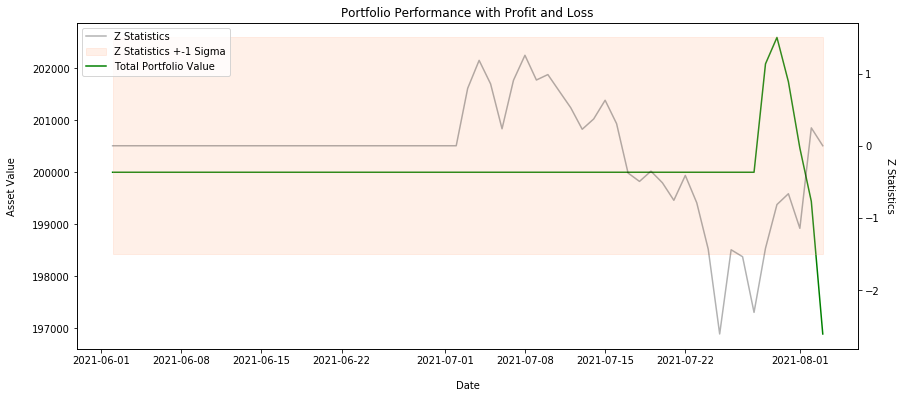

In [267]:
pnl2(data_portfolio5_1,'BCH-USD','XMR-USD')

Using price ratio

In [268]:
stocks5 = ["BCH-USD","XMR-USD"]
portfolio5=combine_stocks(stocks5,start,end)

               BCH-USD
Date                  
2021-06-01  691.403870
2021-06-02  697.912964
2021-06-03  718.448181
2021-06-04  671.139160
2021-06-05  649.438354
               XMR-USD
Date                  
2021-06-01  265.774841
2021-06-02  294.092072
2021-06-03  308.188782
2021-06-04  287.463715
2021-06-05  264.308289
               BCH-USD     XMR-USD
Date                              
2021-06-01  691.403870  265.774841
2021-06-02  697.912964  294.092072
2021-06-03  718.448181  308.188782
2021-06-04  671.139160  287.463715
2021-06-05  649.438354  264.308289


Normal Trading

In [269]:
data_portfolio5=data_prep(32,portfolio5,'BCH-USD','XMR-USD')

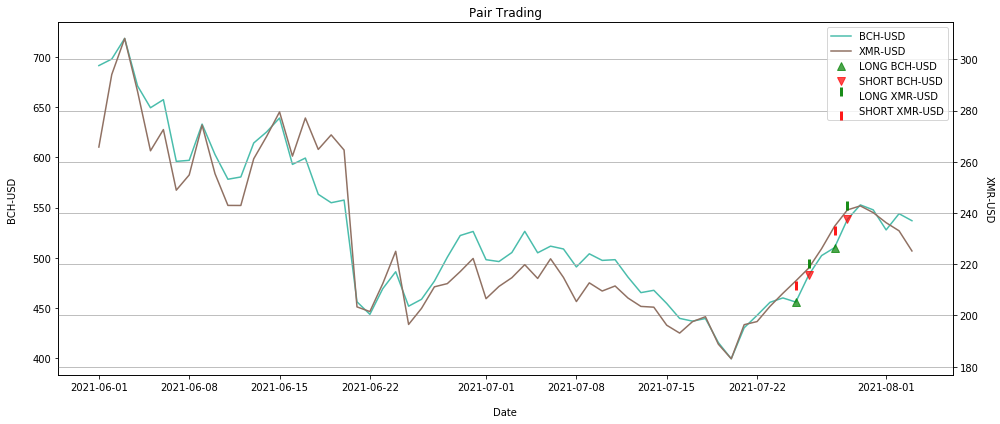

In [270]:
data_portfolio5=pair_trading1(data_portfolio5,'BCH-USD','XMR-USD',1.5)

Number of days =  62
CAGR = 6494.966%


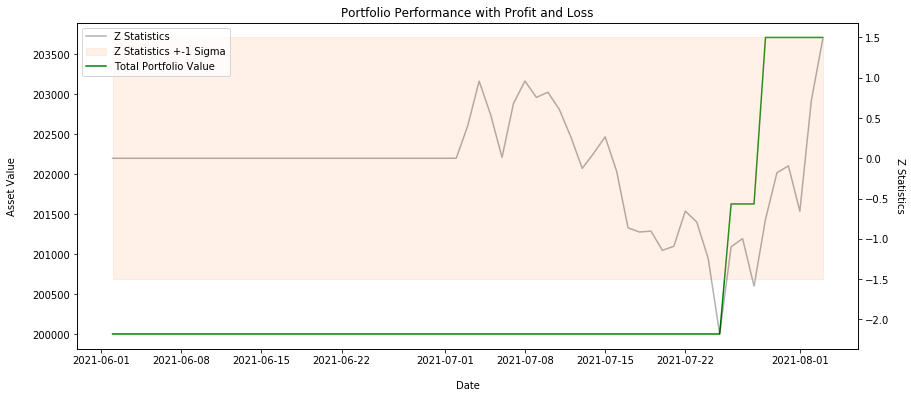

In [271]:
pnl1(data_portfolio5,'BCH-USD','XMR-USD')

GBM pair trading

In [272]:
import numpy as np
# functins to determine signals and whether to trade for every day!!!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=new_portfolio.iloc[:,0]/new_portfolio.iloc[:,1]

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['signals2'] = -data['signals1']
    data['movingzs']=movingzs
    return data

In [273]:
# call the function and generate a table with stock adjusted close prices
stocks5 = ["BCH-USD","XMR-USD"]
data_portfolio=combine_stocks(stocks5,start,end)
data_portfolio5_1=pair_signals_gbm(data_portfolio,32,1.5)

               BCH-USD
Date                  
2021-06-01  691.403870
2021-06-02  697.912964
2021-06-03  718.448181
2021-06-04  671.139160
2021-06-05  649.438354
               XMR-USD
Date                  
2021-06-01  265.774841
2021-06-02  294.092072
2021-06-03  308.188782
2021-06-04  287.463715
2021-06-05  264.308289
               BCH-USD     XMR-USD
Date                              
2021-06-01  691.403870  265.774841
2021-06-02  697.912964  294.092072
2021-06-03  718.448181  308.188782
2021-06-04  671.139160  287.463715
2021-06-05  649.438354  264.308289


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


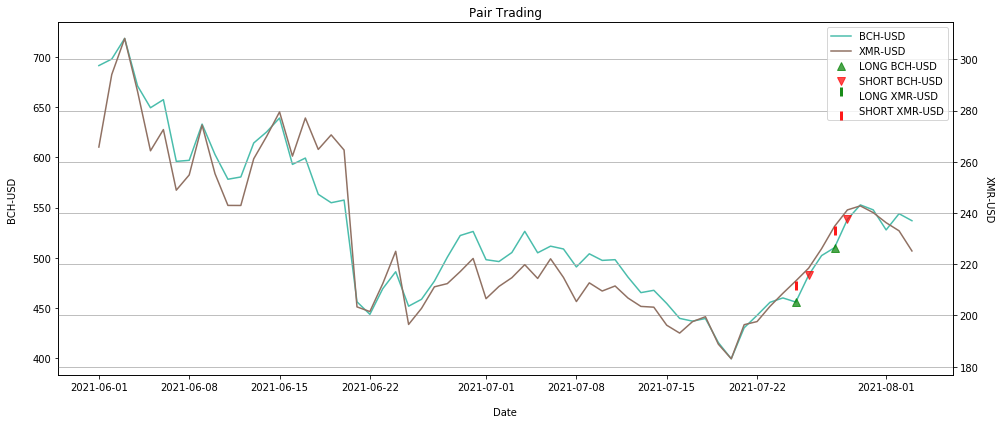

In [274]:
data_portfolio5_1=pair_trading2(data_portfolio5_1,'BCH-USD','XMR-USD',1.5)

Number of days =  31.0
CAGR = 364501.425%


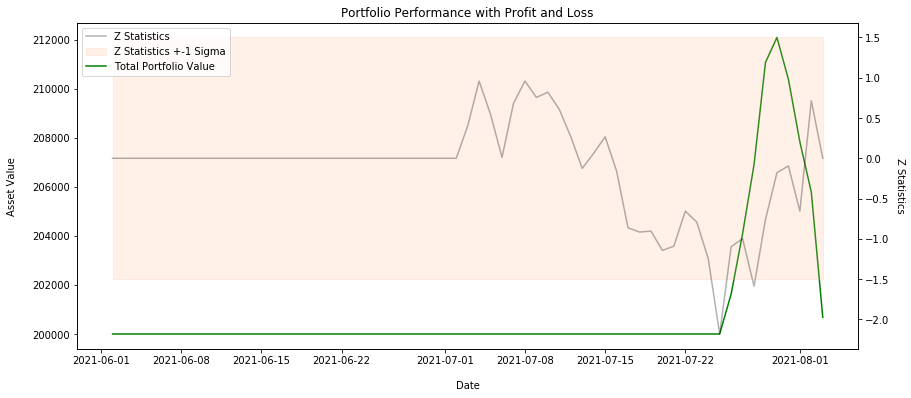

In [275]:
pnl2(data_portfolio5_1,'BCH-USD','XMR-USD')

2021.6.1-2021.9.1

In [342]:
# we plan to evaluate the 3-year data 
# As USD coins have not been put into the market until 2019
start = datetime.datetime(2021,6,1)
end = datetime.datetime(2021,9,1)
# call the function and generate a table with stock adjusted close prices
# call the function and generate a table with stock adjusted close prices
stocks5 = ["BCH-USD","XMR-USD"]
portfolio5=combine_stocks(stocks5,start,end)

               BCH-USD
Date                  
2021-06-01  691.403870
2021-06-02  697.912964
2021-06-03  718.448181
2021-06-04  671.139160
2021-06-05  649.438354
               XMR-USD
Date                  
2021-06-01  265.774841
2021-06-02  294.092072
2021-06-03  308.188782
2021-06-04  287.463715
2021-06-05  264.308289
               BCH-USD     XMR-USD
Date                              
2021-06-01  691.403870  265.774841
2021-06-02  697.912964  294.092072
2021-06-03  718.448181  308.188782
2021-06-04  671.139160  287.463715
2021-06-05  649.438354  264.308289


In [277]:
result = ts.coint(portfolio5['BCH-USD'],portfolio5['XMR-USD'])
result[1]

0.006674246954603816

In [278]:
import numpy as np
portfolio5['log price ratio']=np.log(portfolio5['BCH-USD'])/np.log(portfolio5['XMR-USD'])
portfolio5['price ratio']=portfolio5['BCH-USD']/portfolio5['XMR-USD']
portfolio5['spread']=regr(np.log(portfolio5['BCH-USD']),np.log(portfolio5['XMR-USD']))

In [279]:
adf_t(portfolio5)

BCH-USD         XMR-USD log price ratio price ratio          spread
0  not stationary  not stationary      stationary  stationary  not stationary

Using log price ratio

Normal trading

In [280]:
len(portfolio5['BCH-USD'])

94

In [343]:
data_portfolio5=data_prep1(47,portfolio5,'BCH-USD','XMR-USD')

In [344]:
# function to create trading signal table and plot the trading strategy
def pair_trading1(data,S1,S2,threshold):
    '''
    data: output dataframe from previous function
    S1: stock1 name (string)
    S2: stock2 name (string)
    threshold: z-scored threshold
    '''
    # create trading signals
    # create signal - short if z-score is greater than upper limit else long
    data['signals1'] = 0
    data['signals1'] = np.select([data['moving_zs'] > threshold, data['moving_zs'] < -threshold], [-1, 1], default=0)
    data['signals2'] = -data['signals1']

    # calculate positions of every day (1day of holding normally whereas if continuous buying, hold until buying everything)
    positions1=list(data['signals1'])
    positions2=list(data['signals2'])

    for i in range(len(data['signals1'])-1): 
        if positions1[i]!=0 and positions1[i+1]==0:
            if np.where(np.array(positions1[:i+1])==0)[0].size!=0:
                if np.max(np.where(np.array(positions1[:i+1])==0))==i-1:
                    positions1[i+1]=0-positions1[i]
                elif np.max(np.where(np.array(positions1[:i+1])==0))!=i-1:
                    positions1[i+1]=0-sum(positions1[np.max(np.where(np.array(positions1[:i+1])==0))+1:i+1])
        elif positions1[i]!=0 and np.where(np.array(positions1[i:])==0)[0].size==0:
            if np.where(np.array(positions1[:i+1])==0)[0].size!=0:
                if np.max(np.where(np.array(positions1[:i+1])==0))==i-1:
                    positions1[-1]=0-positions1[i]
                elif np.max(np.where(np.array(positions1[:i+1])==0))!=i-1:
                    positions1[-1]=0-sum(positions1[i:-1])
            
            
        
    for i in range(len(data['signals2'])-1): #holding days is 3 in this case
        if positions2[i]!=0 and positions2[i+1]==0:
            if np.where(np.array(positions2[:i+1])==0)[0].size!=0:
                if np.max(np.where(np.array(positions2[:i+1])==0))==i-1:
                    positions2[i+1]=0-positions2[i]
                elif np.max(np.where(np.array(positions2[:i+1])==0))!=i-1:
                    positions2[i+1]=0-sum(positions2[np.max(np.where(np.array(positions2[:i+1])==0))+1:i+1])
        elif positions2[i]!=0 and np.where(np.array(positions2[i:])==0)[0].size==0:
            if np.where(np.array(positions2[:i+1])==0)[0].size!=0:
                if np.max(np.where(np.array(positions2[:i+1])==0))==i-1:
                    positions2[-1]=0-positions2[i]
                elif np.max(np.where(np.array(positions2[:i+1])==0))!=i-1:
                    positions2[-1]=0-sum(positions2[i:-1])

    data['positions1']=np.array(positions1)
    data['positions2']=np.array(positions2)
    # verify datafame head and tail
    # data.head(3).append(data.tail(3))

    # visualize trading signals and position
    fig=plt.figure(figsize=(14,6))
    bx = fig.add_subplot(111)   
    bx2 = bx.twinx()

    #plot two different assets
    l1, = bx.plot(data[S1], c='#4abdac')
    l2, = bx2.plot(data[S2], c='#907163')
    u1, = bx.plot(data[S1][data['positions1'] >0], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
    d1, = bx.plot(data[S1][data['positions1'] <0], lw=0,marker='v',markersize=8, c='r',alpha=0.7)
    u2, = bx2.plot(data[S2][data['positions2'] >0], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)
    d2, = bx2.plot(data[S2][data['positions2'] <0], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)
    bx.set_ylabel(S1,)
    bx2.set_ylabel(S2, rotation=270)
    bx.yaxis.labelpad=15
    bx2.yaxis.labelpad=15
    bx.set_xlabel('Date')
    bx.xaxis.labelpad=15
    plt.legend([l1,l2,u1,d1,u2,d2], [S1,S2,'LONG {}'.format(S1),
            'SHORT {}'.format(S1),
           'LONG {}'.format(S2),
           'SHORT {}'.format(S2)], loc ='best')
    plt.title('Pair Trading')
    plt.xlabel('Date')
    plt.grid(True)

    plt.tight_layout()
    return data




/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

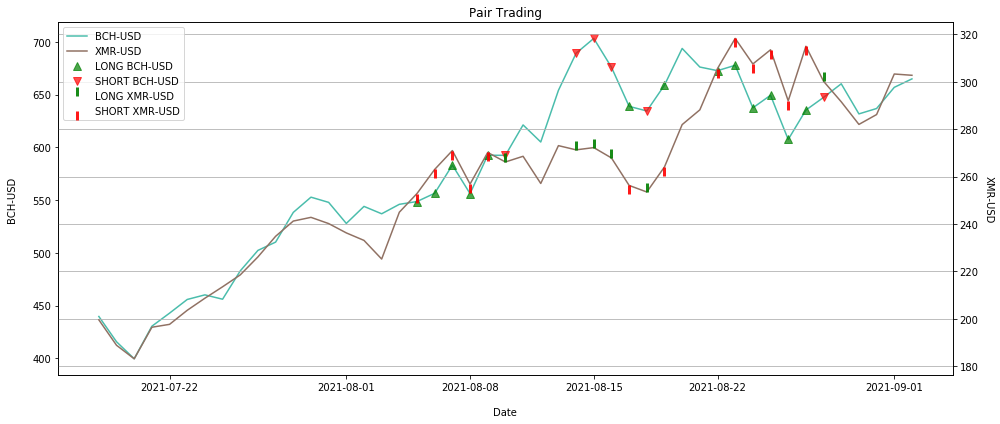

In [345]:
data_portfolio5=pair_trading1(data_portfolio5,'BCH-USD','XMR-USD',1.5)

Number of days =  45
CAGR = 26965.417%


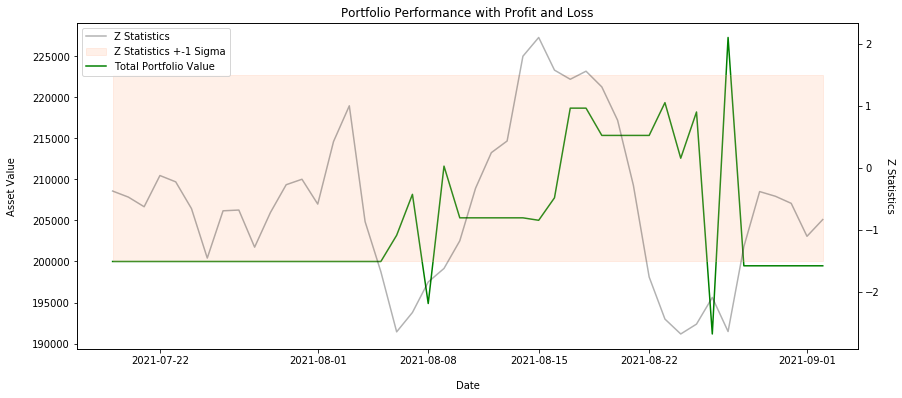

In [346]:
pnl1(data_portfolio5,'BCH-USD','XMR-USD')

GBM pair trading

In [347]:
# functins to determine signals and whether to trade for every day!!!
# notice to change the data into nplog price ratio as well!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=np.log(new_portfolio.iloc[:,0])/np.log(new_portfolio.iloc[:,1])

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['movingzs']=movingzs
    data['signals2'] = -data['signals1']
    data['signals2'][-1] = -data['signals1'][-1]

    return data

In [348]:
# call the function and generate a table with stock adjusted close prices
stocks5 = ["BCH-USD","XMR-USD"]
data_portfolio=combine_stocks(stocks5,start,end)
data_portfolio5_1=pair_signals_gbm(data_portfolio,47,1.5)

               BCH-USD
Date                  
2021-06-01  691.403870
2021-06-02  697.912964
2021-06-03  718.448181
2021-06-04  671.139160
2021-06-05  649.438354
               XMR-USD
Date                  
2021-06-01  265.774841
2021-06-02  294.092072
2021-06-03  308.188782
2021-06-04  287.463715
2021-06-05  264.308289
               BCH-USD     XMR-USD
Date                              
2021-06-01  691.403870  265.774841
2021-06-02  697.912964  294.092072
2021-06-03  718.448181  308.188782
2021-06-04  671.139160  287.463715
2021-06-05  649.438354  264.308289


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

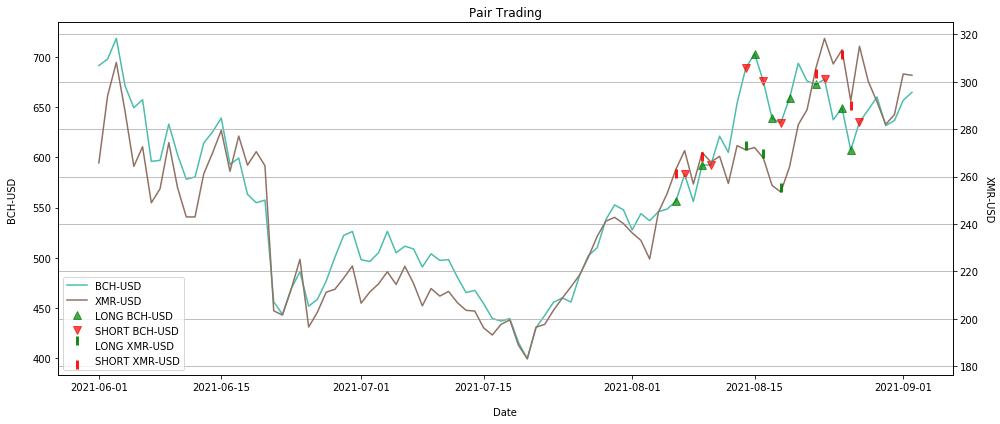

In [349]:
data_portfolio5_1=pair_trading2(data_portfolio5_1,'BCH-USD','XMR-USD',1.5)

In [350]:
# functions to calculate profit and losses!!!
def pnl2(data,S1,S2):
    '''
    data: output dataframe from previous function
    S1: stock1 name (string)
    S2: stock2 name (string)
    threshold: z-scored threshold
    '''
    # function to calculate returns and do backtesting
    # code to calculate the profit and loss
    # initial capital to calculate the actual pnl
    initial_capital = 100000

    # shares to buy for each position
    positions1 = initial_capital// max(data[S1])
    positions2 = initial_capital// max(data[S2])

    # since there are two assets, we calculate each asset Pnl 
    # separately and in the end we aggregate them into one portfolio
    portfolio = pd.DataFrame()
    portfolio[S1] = data[S1]
    portfolio['holdings1'] = data['positions1'].cumsum() * data[S1] * positions1
    portfolio['cash1'] = initial_capital - (data['positions1'].cumsum() * data[S1] * positions1)
    portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total asset1'].pct_change()
    portfolio['positions1'] = data['positions1']

    # pnl for the 2nd asset
    portfolio[S2] = data[S2]
    portfolio['holdings2'] = (data['positions2']* data[S2] * positions2).cumsum()
    portfolio['cash2'] = initial_capital - (data['positions2'].cumsum() * data[S2] * positions2)
    portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total asset2'].pct_change()
    portfolio['positions2'] = data['positions2']

    # total pnl and z-score
    portfolio['z'] = data['movingzs'] #tells when the trade occurs!!!
    portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
    portfolio['z upper limit'] = 1.5
    portfolio['z lower limit'] = -1.5
    portfolio = portfolio.dropna()

    # plot the asset value change of the portfolio and pnl along with z-score
    fig = plt.figure(figsize=(14,6),)
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    l1, = ax.plot(portfolio['total asset'], c='g')
    l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
    b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],portfolio['z lower limit'], alpha=0.2,color='#ffb48f')
    ax.set_ylabel('Asset Value')
    ax2.set_ylabel('Z Statistics',rotation=270)
    ax.yaxis.labelpad=15
    ax2.yaxis.labelpad=15
    ax.set_xlabel('Date')
    ax.xaxis.labelpad=15
    plt.title('Portfolio Performance with Profit and Loss')
    plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');

    # calculate CAGR
    final_portfolio = portfolio['total asset'].iloc[-1]
    delta = ((portfolio.index[-1] - portfolio.index[0]).days)/2
    print('Number of days = ', delta)
    YEAR_DAYS = 365
    returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
    print('CAGR = {:.3f}%' .format(returns * 100))
    #return portfolio

Number of days =  46.0
CAGR = 13370.187%


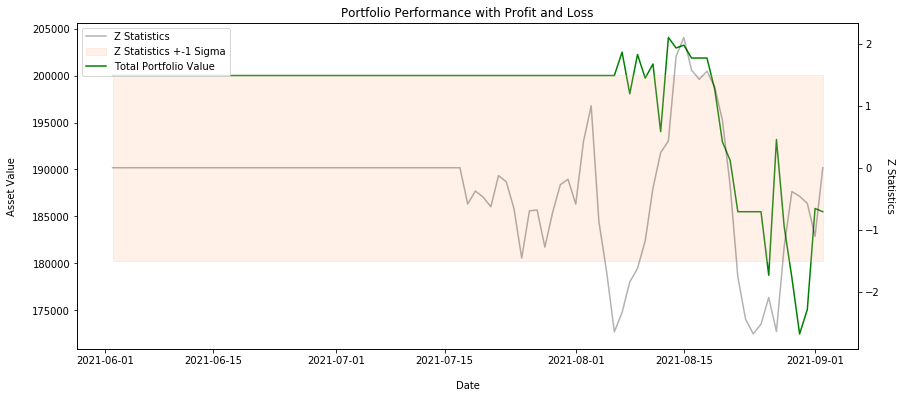

In [351]:
pnl2(data_portfolio5_1,'BCH-USD','XMR-USD')

Using price ratio

Normal trading

In [294]:
stocks5 = ["BCH-USD","XMR-USD"]
portfolio5=combine_stocks(stocks5,start,end)

               BCH-USD
Date                  
2021-06-01  691.403870
2021-06-02  697.912964
2021-06-03  718.448181
2021-06-04  671.139160
2021-06-05  649.438354
               XMR-USD
Date                  
2021-06-01  265.774841
2021-06-02  294.092072
2021-06-03  308.188782
2021-06-04  287.463715
2021-06-05  264.308289
               BCH-USD     XMR-USD
Date                              
2021-06-01  691.403870  265.774841
2021-06-02  697.912964  294.092072
2021-06-03  718.448181  308.188782
2021-06-04  671.139160  287.463715
2021-06-05  649.438354  264.308289


In [295]:
data_portfolio5=data_prep(47,portfolio5,'BCH-USD','XMR-USD')

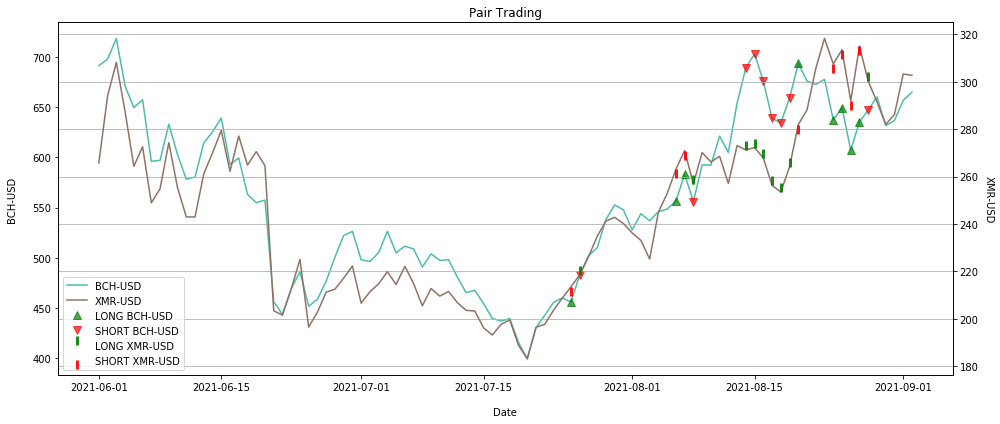

In [296]:
data_portfolio5=pair_trading1(data_portfolio5,'BCH-USD','XMR-USD',1.5)

Number of days =  92
CAGR = 444.175%


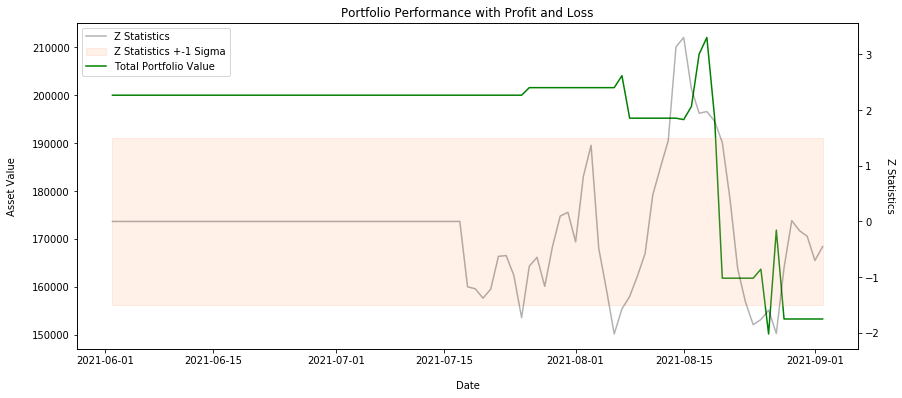

In [297]:
pnl1(data_portfolio5,'BCH-USD','XMR-USD')

GBM pair trading

In [298]:
import numpy as np
# functins to determine signals and whether to trade for every day!!!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=new_portfolio.iloc[:,0]/new_portfolio.iloc[:,1]

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['signals2'] = -data['signals1']
    data['movingzs']=movingzs
    return data

In [299]:
# call the function and generate a table with stock adjusted close prices
stocks5 = ["BCH-USD","XMR-USD"]
data_portfolio=combine_stocks(stocks5,start,end)
data_portfolio5_1=pair_signals_gbm(data_portfolio,47,1.5)

               BCH-USD
Date                  
2021-06-01  691.403870
2021-06-02  697.912964
2021-06-03  718.448181
2021-06-04  671.139160
2021-06-05  649.438354
               XMR-USD
Date                  
2021-06-01  265.774841
2021-06-02  294.092072
2021-06-03  308.188782
2021-06-04  287.463715
2021-06-05  264.308289
               BCH-USD     XMR-USD
Date                              
2021-06-01  691.403870  265.774841
2021-06-02  697.912964  294.092072
2021-06-03  718.448181  308.188782
2021-06-04  671.139160  287.463715
2021-06-05  649.438354  264.308289


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


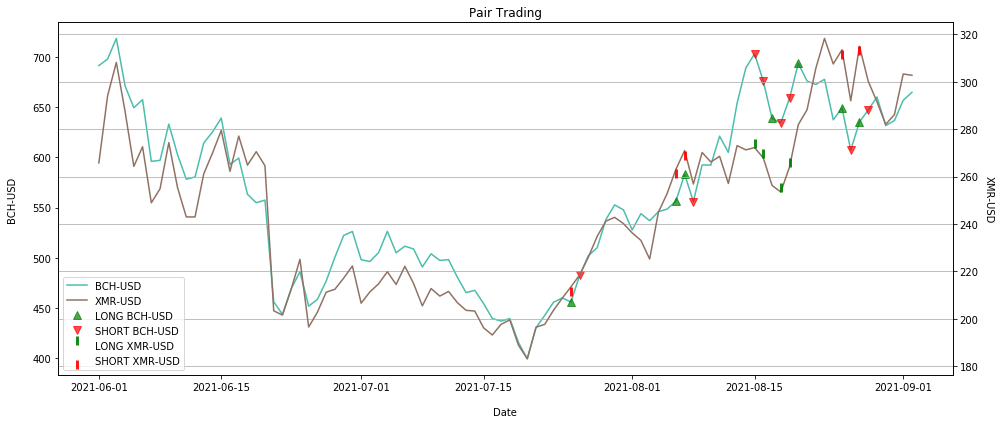

In [302]:
data_portfolio5_1=pair_trading2(data_portfolio5_1,'BCH-USD','XMR-USD',1.5)

Number of days =  46.0
CAGR = 20005.058%


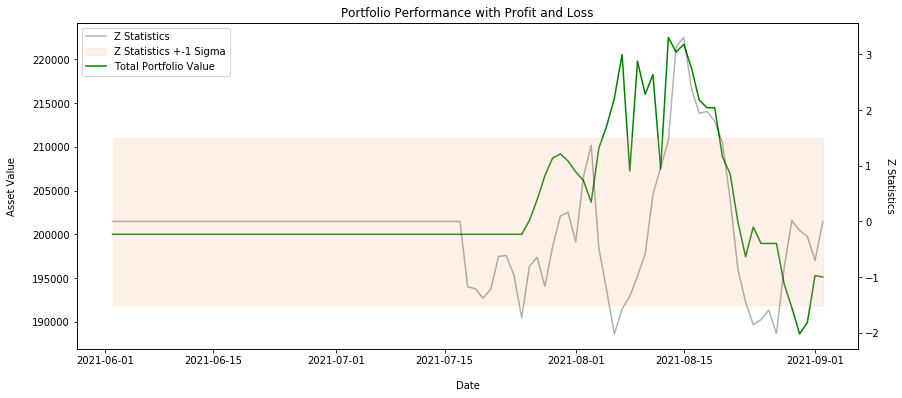

In [303]:
pnl2(data_portfolio5_1,'BCH-USD','XMR-USD')

In [304]:
# we plan to evaluate the 3-year data 
# As USD coins have not been put into the market until 2019
start = datetime.datetime(2021,6,1)
end = datetime.datetime(2022,1,1)
# call the function and generate a table with stock adjusted close prices
# call the function and generate a table with stock adjusted close prices
stocks5 = ["BCH-USD","XMR-USD"]
portfolio5=combine_stocks(stocks5,start,end)

               BCH-USD
Date                  
2021-06-01  691.403870
2021-06-02  697.912964
2021-06-03  718.448181
2021-06-04  671.139160
2021-06-05  649.438354
               XMR-USD
Date                  
2021-06-01  265.774841
2021-06-02  294.092072
2021-06-03  308.188782
2021-06-04  287.463715
2021-06-05  264.308289
               BCH-USD     XMR-USD
Date                              
2021-06-01  691.403870  265.774841
2021-06-02  697.912964  294.092072
2021-06-03  718.448181  308.188782
2021-06-04  671.139160  287.463715
2021-06-05  649.438354  264.308289


Test for cointegration

In [305]:
result = ts.coint(portfolio5['BCH-USD'],portfolio5['XMR-USD'])
result[1]

0.006902110133543827

Test stationarity of the price ratio and spread

In [306]:
import numpy as np
portfolio5['log price ratio']=np.log(portfolio5['BCH-USD'])/np.log(portfolio5['XMR-USD'])
portfolio5['price ratio']=portfolio5['BCH-USD']/portfolio5['XMR-USD']
portfolio5['spread']=regr(np.log(portfolio5['BCH-USD']),np.log(portfolio5['XMR-USD']))

In [307]:
adf_t(portfolio5)

BCH-USD         XMR-USD log price ratio price ratio          spread
0  not stationary  not stationary      stationary  stationary  not stationary

# Using log price ratio

Determine normal pair trading strategy and performance 

In [308]:
len(portfolio5['BCH-USD'])

216

In [309]:
#notice: because here only log price ratio converge, so we only take log price ratio as spread
def data_prep1(time_period,data,S1,S2):
    #create a column for price ratio
    data['price ratio']=np.log(data[S1])/np.log(data[S2])
    # create columns for moving averages, standard deviations, and z_scores
    averages=[0]*time_period
    sds=[0]*time_period
    z_scores=[0]*time_period
    for i in range(time_period,len(data.iloc[:,0])):
        averages.append(np.mean(data.iloc[i-time_period:i,2]))
        sds.append(np.std(data.iloc[i-time_period:i,2]))
        z_scores.append((data.iloc[i,2]-np.mean(data.iloc[i-time_period:i,2]))/np.std(data.iloc[i-time_period:i,2]))
    data['moving_averages']=averages
    data['moving_stds']=sds
    data['moving_zs']=z_scores
    return data.iloc[time_period:,:]

In [310]:
data_portfolio5=data_prep1(108,portfolio5,'BCH-USD','XMR-USD')

In [311]:
# function to create trading signal table and plot the trading strategy
def pair_trading1(data,S1,S2,threshold):
    '''
    data: output dataframe from previous function
    S1: stock1 name (string)
    S2: stock2 name (string)
    threshold: z-scored threshold
    '''
    # create trading signals
    # create signal - short if z-score is greater than upper limit else long
    data['signals1'] = 0
    data['signals1'] = np.select([data['moving_zs'] > threshold, data['moving_zs'] < -threshold], [-1, 1], default=0)
    data['signals2'] = -data['signals1']

    # calculate positions of every day (1day of holding normally whereas if continuous buying, hold until buying everything)
    positions1=list(data['signals1'])
    positions2=list(data['signals2'])

    for i in range(len(data['signals1'])-1): 
        if positions1[i]!=0 and positions1[i+1]==0:
            if np.where(np.array(positions1[:i+1])==0)[0].size!=0:
                if np.max(np.where(np.array(positions1[:i+1])==0))==i-1:
                    positions1[i+1]=0-positions1[i]
                elif np.max(np.where(np.array(positions1[:i+1])==0))!=i-1:
                    positions1[i+1]=0-sum(positions1[np.max(np.where(np.array(positions1[:i+1])==0))+1:i+1])
        elif positions1[i]!=0 and np.where(np.array(positions1[i:])==0)[0].size==0:
            if np.where(np.array(positions1[:i+1])==0)[0].size!=0:
                if np.max(np.where(np.array(positions1[:i+1])==0))==i-1:
                    positions1[-1]=0-positions1[i]
                elif np.max(np.where(np.array(positions1[:i+1])==0))!=i-1:
                    positions1[-1]=0-sum(positions1[i:-1])
            
            
        
    for i in range(len(data['signals2'])-1): #holding days is 3 in this case
        if positions2[i]!=0 and positions2[i+1]==0:
            if np.where(np.array(positions2[:i+1])==0)[0].size!=0:
                if np.max(np.where(np.array(positions2[:i+1])==0))==i-1:
                    positions2[i+1]=0-positions2[i]
                elif np.max(np.where(np.array(positions2[:i+1])==0))!=i-1:
                    positions2[i+1]=0-sum(positions2[np.max(np.where(np.array(positions2[:i+1])==0))+1:i+1])
        elif positions2[i]!=0 and np.where(np.array(positions2[i:])==0)[0].size==0:
            if np.where(np.array(positions2[:i+1])==0)[0].size!=0:
                if np.max(np.where(np.array(positions2[:i+1])==0))==i-1:
                    positions2[-1]=0-positions2[i]
                elif np.max(np.where(np.array(positions2[:i+1])==0))!=i-1:
                    positions2[-1]=0-sum(positions2[i:-1])

    data['positions1']=np.array(positions1)
    data['positions2']=np.array(positions2)
    # verify datafame head and tail
    # data.head(3).append(data.tail(3))

    # visualize trading signals and position
    fig=plt.figure(figsize=(14,6))
    bx = fig.add_subplot(111)   
    bx2 = bx.twinx()

    #plot two different assets
    l1, = bx.plot(data[S1], c='#4abdac')
    l2, = bx2.plot(data[S2], c='#907163')
    u1, = bx.plot(data[S1][data['positions1'] >0], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
    d1, = bx.plot(data[S1][data['positions1'] <0], lw=0,marker='v',markersize=8, c='r',alpha=0.7)
    u2, = bx2.plot(data[S2][data['positions2'] >0], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)
    d2, = bx2.plot(data[S2][data['positions2'] <0], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)
    bx.set_ylabel(S1,)
    bx2.set_ylabel(S2, rotation=270)
    bx.yaxis.labelpad=15
    bx2.yaxis.labelpad=15
    bx.set_xlabel('Date')
    bx.xaxis.labelpad=15
    plt.legend([l1,l2,u1,d1,u2,d2], [S1,S2,'LONG {}'.format(S1),
            'SHORT {}'.format(S1),
           'LONG {}'.format(S2),
           'SHORT {}'.format(S2)], loc ='best')
    plt.title('Pair Trading')
    plt.xlabel('Date')
    plt.grid(True)

    plt.tight_layout()
    return data



/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

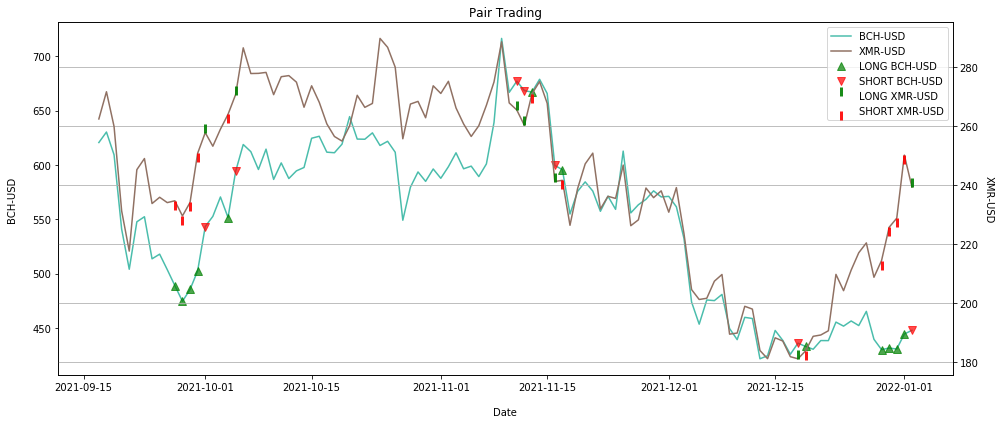

In [312]:
data_portfolio5=pair_trading1(data_portfolio5,'BCH-USD','XMR-USD',1.5)

Number of days =  106
CAGR = 1855.648%


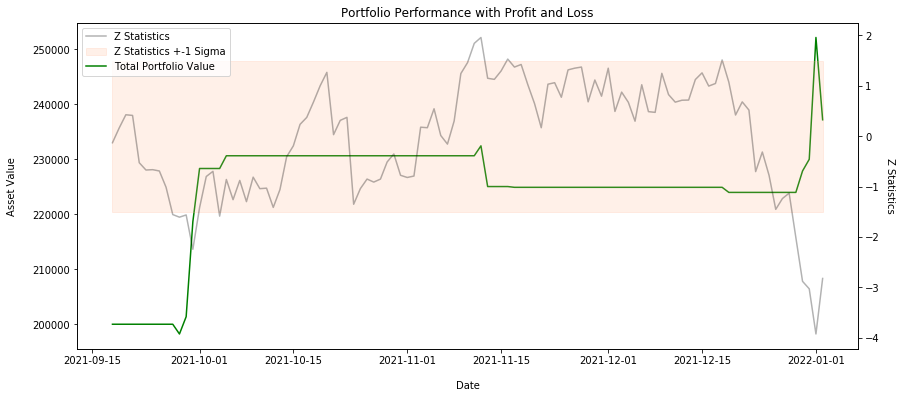

In [313]:
pnl1(data_portfolio5,'BCH-USD','XMR-USD')

Determine GBM pair trading and performance

In [314]:
# functins to determine signals and whether to trade for every day!!!
# notice to change the data into nplog price ratio as well!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=np.log(new_portfolio.iloc[:,0])/np.log(new_portfolio.iloc[:,1])

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['movingzs']=movingzs
    data['signals2'] = -data['signals1']
    data['signals2'][-1] = -data['signals1'][-1]

    return data

In [315]:
# call the function and generate a table with stock adjusted close prices
stocks5 = ["BCH-USD","XMR-USD"]
data_portfolio=combine_stocks(stocks5,start,end)
data_portfolio5_1=pair_signals_gbm(data_portfolio,108,1.5)

               BCH-USD
Date                  
2021-06-01  691.403870
2021-06-02  697.912964
2021-06-03  718.448181
2021-06-04  671.139160
2021-06-05  649.438354
               XMR-USD
Date                  
2021-06-01  265.774841
2021-06-02  294.092072
2021-06-03  308.188782
2021-06-04  287.463715
2021-06-05  264.308289
               BCH-USD     XMR-USD
Date                              
2021-06-01  691.403870  265.774841
2021-06-02  697.912964  294.092072
2021-06-03  718.448181  308.188782
2021-06-04  671.139160  287.463715
2021-06-05  649.438354  264.308289


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

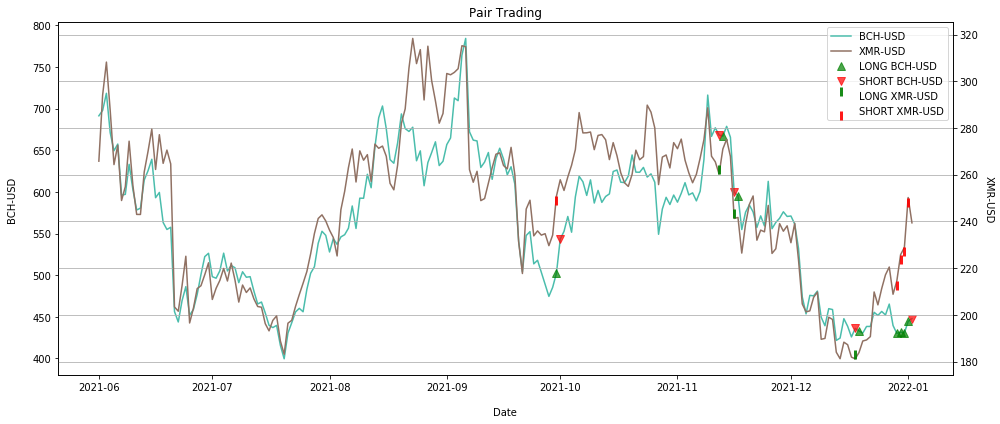

In [316]:
data_portfolio5_1=pair_trading2(data_portfolio5_1,'BCH-USD','XMR-USD',1.5)

In [319]:
# functions to calculate profit and losses!!!
def pnl2(data,S1,S2):
    '''
    data: output dataframe from previous function
    S1: stock1 name (string)
    S2: stock2 name (string)
    threshold: z-scored threshold
    '''
    # function to calculate returns and do backtesting
    # code to calculate the profit and loss
    # initial capital to calculate the actual pnl
    initial_capital = 100000

    # shares to buy for each position
    positions1 = initial_capital// max(data[S1])
    positions2 = initial_capital// max(data[S2])

    # since there are two assets, we calculate each asset Pnl 
    # separately and in the end we aggregate them into one portfolio
    portfolio = pd.DataFrame()
    portfolio[S1] = data[S1]
    portfolio['holdings1'] = data['positions1'].cumsum() * data[S1] * positions1
    portfolio['cash1'] = initial_capital - (data['positions1'].cumsum() * data[S1] * positions1)
    portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total asset1'].pct_change()
    portfolio['positions1'] = data['positions1']

    # pnl for the 2nd asset
    portfolio[S2] = data[S2]
    portfolio['holdings2'] = (data['positions2']* data[S2] * positions2).cumsum()
    portfolio['cash2'] = initial_capital - (data['positions2'].cumsum() * data[S2] * positions2)
    portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total asset2'].pct_change()
    portfolio['positions2'] = data['positions2']

    # total pnl and z-score
    portfolio['z'] = data['movingzs'] #tells when the trade occurs!!!
    portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
    portfolio['z upper limit'] = 1.5
    portfolio['z lower limit'] = -1.5
    portfolio = portfolio.dropna()

    # plot the asset value change of the portfolio and pnl along with z-score
    fig = plt.figure(figsize=(14,6),)
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    l1, = ax.plot(portfolio['total asset'], c='g')
    l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
    b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],portfolio['z lower limit'], alpha=0.2,color='#ffb48f')
    ax.set_ylabel('Asset Value')
    ax2.set_ylabel('Z Statistics',rotation=270)
    ax.yaxis.labelpad=15
    ax2.yaxis.labelpad=15
    ax.set_xlabel('Date')
    ax.xaxis.labelpad=15
    plt.title('Portfolio Performance with Profit and Loss')
    plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');

    # calculate CAGR
    final_portfolio = portfolio['total asset'].iloc[-1]
    delta = ((portfolio.index[-1] - portfolio.index[0]).days)/2
    print('Number of days = ', delta)
    YEAR_DAYS = 365
    returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
    print('CAGR = {:.3f}%' .format(returns * 100))
    #return portfolio

Number of days =  107.0
CAGR = 915.534%


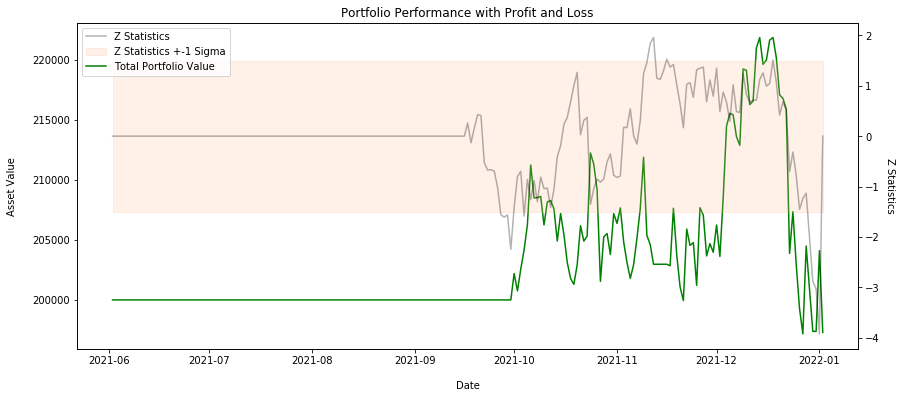

In [320]:
pnl2(data_portfolio5_1,'BCH-USD','XMR-USD')

# Using price ratio

In [321]:
stocks5 = ["BCH-USD","XMR-USD"]
portfolio5=combine_stocks(stocks5,start,end)

               BCH-USD
Date                  
2021-06-01  691.403870
2021-06-02  697.912964
2021-06-03  718.448181
2021-06-04  671.139160
2021-06-05  649.438354
               XMR-USD
Date                  
2021-06-01  265.774841
2021-06-02  294.092072
2021-06-03  308.188782
2021-06-04  287.463715
2021-06-05  264.308289
               BCH-USD     XMR-USD
Date                              
2021-06-01  691.403870  265.774841
2021-06-02  697.912964  294.092072
2021-06-03  718.448181  308.188782
2021-06-04  671.139160  287.463715
2021-06-05  649.438354  264.308289


Using normal pair trading to test!

In [322]:
data_portfolio5=data_prep(108,portfolio5,'BCH-USD','XMR-USD')

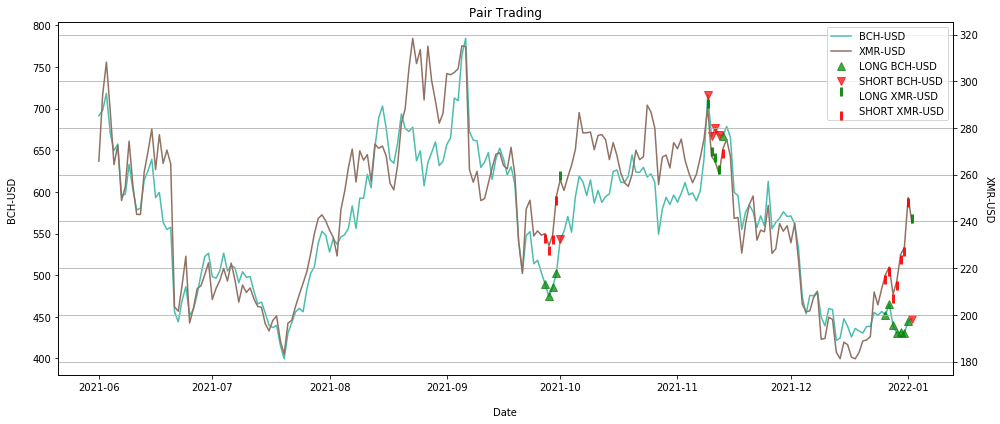

In [323]:
data_portfolio5=pair_trading1(data_portfolio5,'BCH-USD','XMR-USD',1.5)

Number of days =  214
CAGR = 409.418%


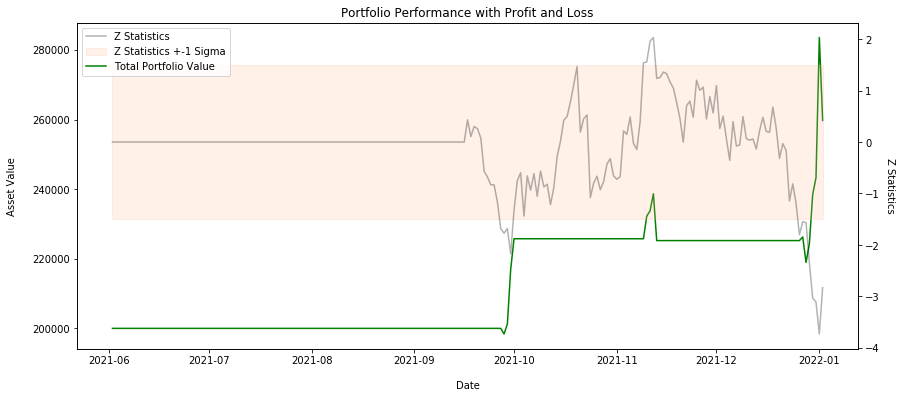

In [324]:
pnl1(data_portfolio5,'BCH-USD','XMR-USD')

Using GBM pair trading to test

In [325]:
import numpy as np
# functins to determine signals and whether to trade for every day!!!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=new_portfolio.iloc[:,0]/new_portfolio.iloc[:,1]

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['signals2'] = -data['signals1']
    data['movingzs']=movingzs
    return data

In [326]:
# call the function and generate a table with stock adjusted close prices
stocks5 = ["BCH-USD","XMR-USD"]
data_portfolio=combine_stocks(stocks5,start,end)
data_portfolio5_1=pair_signals_gbm(data_portfolio,108,1.5)

               BCH-USD
Date                  
2021-06-01  691.403870
2021-06-02  697.912964
2021-06-03  718.448181
2021-06-04  671.139160
2021-06-05  649.438354
               XMR-USD
Date                  
2021-06-01  265.774841
2021-06-02  294.092072
2021-06-03  308.188782
2021-06-04  287.463715
2021-06-05  264.308289
               BCH-USD     XMR-USD
Date                              
2021-06-01  691.403870  265.774841
2021-06-02  697.912964  294.092072
2021-06-03  718.448181  308.188782
2021-06-04  671.139160  287.463715
2021-06-05  649.438354  264.308289


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


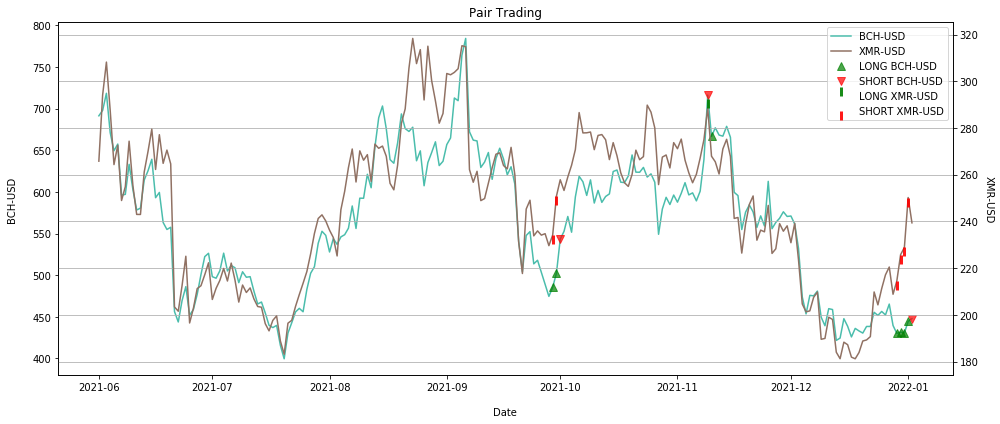

In [327]:
data_portfolio5_1=pair_trading2(data_portfolio5_1,'BCH-USD','XMR-USD',1.5)

Number of days =  107.0
CAGR = 1502.326%


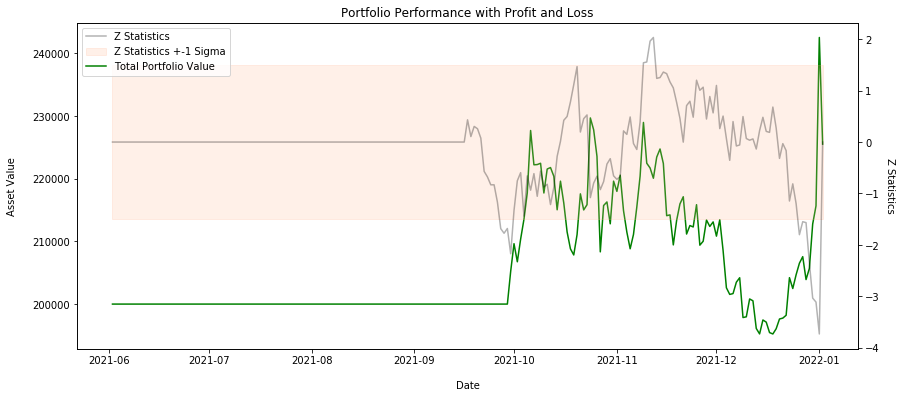

In [328]:
pnl2(data_portfolio5_1,'BCH-USD','XMR-USD')

In [329]:
start = datetime.datetime(2021,6,1)
end = datetime.datetime(2022,3,2)
# call the function and generate a table with stock adjusted close prices
# call the function and generate a table with stock adjusted close prices
stocks5 = ["BCH-USD","XMR-USD"]
portfolio5=combine_stocks(stocks5,start,end)

               BCH-USD
Date                  
2021-06-01  691.403870
2021-06-02  697.912964
2021-06-03  718.448181
2021-06-04  671.139160
2021-06-05  649.438354
               XMR-USD
Date                  
2021-06-01  265.774841
2021-06-02  294.092072
2021-06-03  308.188782
2021-06-04  287.463715
2021-06-05  264.308289
               BCH-USD     XMR-USD
Date                              
2021-06-01  691.403870  265.774841
2021-06-02  697.912964  294.092072
2021-06-03  718.448181  308.188782
2021-06-04  671.139160  287.463715
2021-06-05  649.438354  264.308289


In [330]:
result = ts.coint(portfolio5['BCH-USD'],portfolio5['XMR-USD'])
result[1]

0.004883738255273769

In [331]:
import numpy as np
portfolio5['log price ratio']=np.log(portfolio5['BCH-USD'])/np.log(portfolio5['XMR-USD'])
portfolio5['price ratio']=portfolio5['BCH-USD']/portfolio5['XMR-USD']
portfolio5['spread']=regr(np.log(portfolio5['BCH-USD']),np.log(portfolio5['XMR-USD']))

In [332]:
adf_t(portfolio5)

BCH-USD         XMR-USD log price ratio     price ratio  \
0  not stationary  not stationary      stationary  not stationary   

           spread  
0  not stationary

In [333]:
len(portfolio5['BCH-USD'])

276

normal trading

In [334]:
data_portfolio5=data_prep1(138,portfolio5,'BCH-USD','XMR-USD')

/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

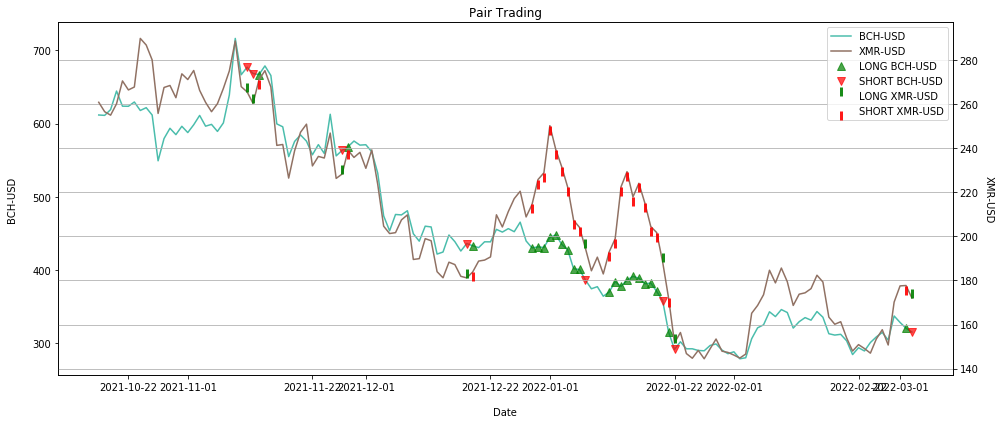

In [335]:
data_portfolio5=pair_trading1(data_portfolio5,'BCH-USD','XMR-USD',1.5)

Number of days =  136
CAGR = -99.522%


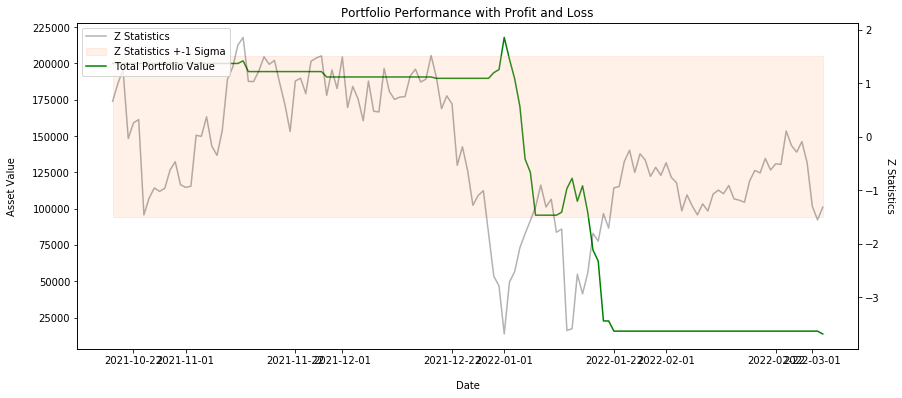

In [336]:
pnl1(data_portfolio5,'BCH-USD','XMR-USD')

GBM pair trading

In [337]:
# functins to determine signals and whether to trade for every day!!!
# notice to change the data into nplog price ratio as well!
def pair_signals_gbm(data,time_period,threshold):
    '''
    data: both historical and actual data
    time_period: days of forecasting
    threshold:z-scored threshold
    '''
    #data should be the entire data set containing both actual and historical data
    #create a column for price ratio
    # data_portfolio['price ratio']=data_portfolio['ETH-USD']/data_portfolio['SOL-USD']
    # create columns for moving averages, standard deviations, and z_scores
    data['signals1'] = 0
    movingzs=[0]*time_period*2
    for i in range(time_period,len(data.iloc[:,0])-1): #有时可减一
        new_portfolio=data.copy()
        # this is every single day during the forecasting period
        # each i represent a single starting day
        # firstly, we need to calculate forecasted price setting each single rolling day as S0
        # this is the forecasting for first stock
        #calculate the input
        S0_1=inputs_get(data,time_period,i,0)[0]
        dt_1=inputs_get(data,time_period,i,0)[1]
        T_1=inputs_get(data,time_period,i,0)[2]
        N_1=inputs_get(data,time_period,i,0)[3]
        t_1=inputs_get(data,time_period,i,0)[4]
        mu_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[0]
        sigma_1=mean_and_sigma(data.iloc[i-time_period:i+1,:],0)[1]
        cov_1=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre1=forecast_multi(S0_1,t_1,mu_1,sigma_1,cov_1,T_1,N_1,2)
        new_portfolio.iloc[i:,0]=portfolio_pre1

        # this is the forecasting for second stock
        S0_2=inputs_get(data,time_period,i,1)[0]
        dt_2=inputs_get(data,time_period,i,1)[1]
        T_2=inputs_get(data,time_period,i,1)[2]
        N_2=inputs_get(data,time_period,i,1)[3]
        t_2=inputs_get(data,time_period,i,1)[4]
        mu_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[0]
        sigma_2=mean_and_sigma(data.iloc[i-time_period:i+1,:],1)[1]
        cov_2=cov_stocks(data.iloc[i-time_period:i+1,:])
        portfolio_pre2=forecast_multi(S0_2,t_2,mu_2,sigma_2,cov_2,T_2,N_2,2)
        new_portfolio.iloc[i:,1]=portfolio_pre2

        #this is the forecasted price ratio in each loop
        new_portfolio['price ratio']=np.log(new_portfolio.iloc[:,0])/np.log(new_portfolio.iloc[:,1])

        averages=[0]*time_period
        sds=[0]*time_period
        z_scores=[0]*time_period
        # this is to calculate the z-score of forecasted price in each loop and different starting day
        for j in range(time_period,len(new_portfolio.iloc[:,0])):
            averages.append(np.mean(new_portfolio.iloc[j-time_period:j,3]))
            sds.append(np.std(new_portfolio.iloc[j-time_period:j,3]))
            z_scores.append((new_portfolio.iloc[j,3]-np.mean(new_portfolio.iloc[j-time_period:j,3]))/np.std(new_portfolio.iloc[j-time_period:j,3]))
        new_portfolio['moving_averages']=averages
        new_portfolio['moving_stds']=sds
        new_portfolio['moving_zs']=z_scores #this is the new portfolio for each new day with following forecasted prices
        # for each i, determine if it's out of threshold and if tomorrow is a better trading day!!!
        data_portfolio['signals1'][i]=signals(new_portfolio,i,threshold)
        movingzs[i]=new_portfolio['moving_zs'][i]
    data['movingzs']=movingzs
    data['signals2'] = -data['signals1']
    data['signals2'][-1] = -data['signals1'][-1]

    return data

In [338]:
# call the function and generate a table with stock adjusted close prices
stocks5 = ["BCH-USD","XMR-USD"]
data_portfolio=combine_stocks(stocks5,start,end)
data_portfolio5_1=pair_signals_gbm(data_portfolio,138,1.5)

               BCH-USD
Date                  
2021-06-01  691.403870
2021-06-02  697.912964
2021-06-03  718.448181
2021-06-04  671.139160
2021-06-05  649.438354
               XMR-USD
Date                  
2021-06-01  265.774841
2021-06-02  294.092072
2021-06-03  308.188782
2021-06-04  287.463715
2021-06-05  264.308289
               BCH-USD     XMR-USD
Date                              
2021-06-01  691.403870  265.774841
2021-06-02  697.912964  294.092072
2021-06-03  718.448181  308.188782
2021-06-04  671.139160  287.463715
2021-06-05  649.438354  264.308289


/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/beckybian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


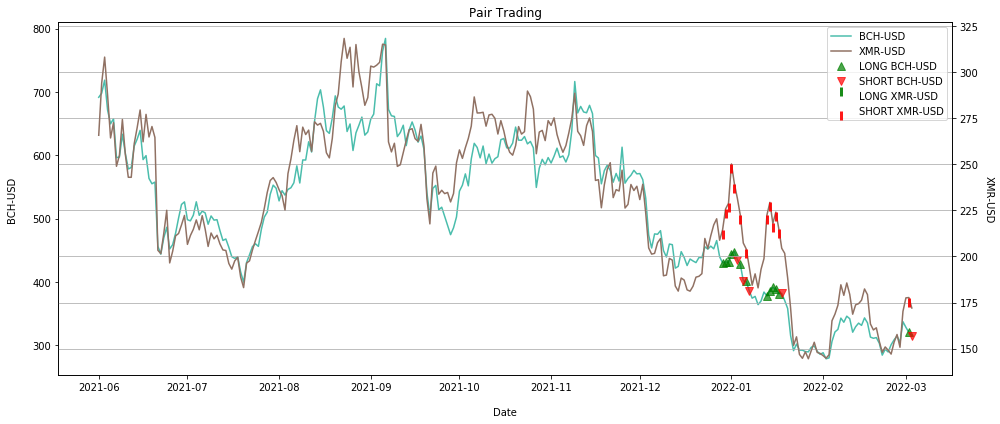

In [339]:
data_portfolio5_1=pair_trading2(data_portfolio5_1,'BCH-USD','XMR-USD',1.5)

In [340]:
# functions to calculate profit and losses!!!
def pnl2(data,S1,S2):
    '''
    data: output dataframe from previous function
    S1: stock1 name (string)
    S2: stock2 name (string)
    threshold: z-scored threshold
    '''
    # function to calculate returns and do backtesting
    # code to calculate the profit and loss
    # initial capital to calculate the actual pnl
    initial_capital = 100000

    # shares to buy for each position
    positions1 = initial_capital// max(data[S1])
    positions2 = initial_capital// max(data[S2])

    # since there are two assets, we calculate each asset Pnl 
    # separately and in the end we aggregate them into one portfolio
    portfolio = pd.DataFrame()
    portfolio[S1] = data[S1]
    portfolio['holdings1'] = data['positions1'].cumsum() * data[S1] * positions1
    portfolio['cash1'] = initial_capital - (data['positions1'].cumsum() * data[S1] * positions1)
    portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
    portfolio['return1'] = portfolio['total asset1'].pct_change()
    portfolio['positions1'] = data['positions1']

    # pnl for the 2nd asset
    portfolio[S2] = data[S2]
    portfolio['holdings2'] = (data['positions2']* data[S2] * positions2).cumsum()
    portfolio['cash2'] = initial_capital - (data['positions2'].cumsum() * data[S2] * positions2)
    portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
    portfolio['return2'] = portfolio['total asset2'].pct_change()
    portfolio['positions2'] = data['positions2']

    # total pnl and z-score
    portfolio['z'] = data['movingzs'] #tells when the trade occurs!!!
    portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
    portfolio['z upper limit'] = 1.5
    portfolio['z lower limit'] = -1.5
    portfolio = portfolio.dropna()

    # plot the asset value change of the portfolio and pnl along with z-score
    fig = plt.figure(figsize=(14,6),)
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    l1, = ax.plot(portfolio['total asset'], c='g')
    l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
    b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],portfolio['z lower limit'], alpha=0.2,color='#ffb48f')
    ax.set_ylabel('Asset Value')
    ax2.set_ylabel('Z Statistics',rotation=270)
    ax.yaxis.labelpad=15
    ax2.yaxis.labelpad=15
    ax.set_xlabel('Date')
    ax.xaxis.labelpad=15
    plt.title('Portfolio Performance with Profit and Loss')
    plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');

    # calculate CAGR
    final_portfolio = portfolio['total asset'].iloc[-1]
    delta = ((portfolio.index[-1] - portfolio.index[0]).days)/2
    print('Number of days = ', delta)
    YEAR_DAYS = 365
    returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
    print('CAGR = {:.3f}%' .format(returns * 100))
    #return portfolio

Number of days =  137.0
CAGR = -100.000%


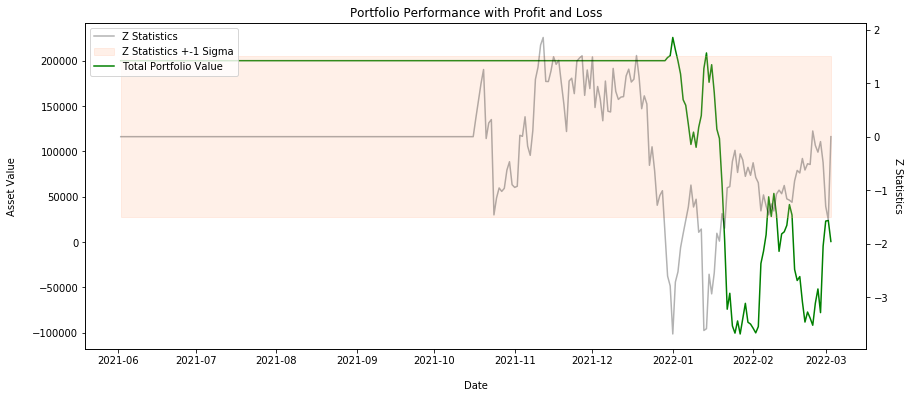

In [341]:
pnl2(data_portfolio5_1,'BCH-USD','XMR-USD')

# Conclusion so far

- For log price ratio, GBM pair trading works worse than normal pair trading
- For price ratio, it seems like GBM pair trading works better than normal pair trading
- Overall, log price ratio works better than price ratio

# Next:

- Test for influence of different time periods
- Test for more cointegrated pairs with both price ratio and log price ratio

# Finding other cointegrated pairs